In [1]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
mnist = input_data.read_data_sets("data/", one_hot=False)
print(mnist)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x10fffe198>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c3ec9f588>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c3ec9f8d0>)


In [12]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
eps = 500

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 26 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [4]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [5]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [6]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3ed17860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
Y_tr = Y_tr - 1
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt.
INFO:tensorflow:loss = 3.2675347, step = 1
INFO:tensorflow:global_step/sec: 2.24235
INFO:tensorflow:loss = 0.9724793, step = 101 (44.597 sec)
INFO:tensorflow:global_step/sec: 2.12084
INFO:tensorflow:loss = 0.8497113, step = 201 (47.151 sec)
INFO:tensorflow:global_step/sec: 2.21198
INFO:tensorflow:loss = 0.7792031, step = 301 (45.214 sec)
INFO:tensorflow:global_step/sec: 2.27645
INFO:tensorflow:loss = 0.7087915, step = 401 (43.922 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt.
INFO:tensorflow:Loss for final step: 0.8081349.


In [8]:
# Evaluate the Model
# Define the input function for evaluating
yt = mnist.test.labels
yt = yt - 1
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=yt,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-06-18:13:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-06-18:13:22
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.8047596, global_step = 500, loss = 0.65575016
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500


{'accuracy': 0.8047596, 'loss': 0.65575016, 'global_step': 500}

In [13]:
write = 1
if write==1:
    f = open("results/shade.txt", 'w')

n_images = len(mnist.test.labels)
# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]
test_label = test_label - 1

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []

accMat = []

In [14]:


val = 0.0001
for j in range(0,eps):
    X_test = X_test_backup
    y_test = Y_test_backup
    mValue = val*j
    X_test = (X_test + (mValue))%1
    # Prepare the input data
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': X_test}, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))

    accuracy = 0.0

    # Display
    for i in range(n_images):
#         plt.imshow(np.reshape(X_test[i], [28, 28]), cmap='gray')
#         plt.show()
        if (preds[i] == y_test[i]):
            accuracy = accuracy + 1/n_images
#         print("Model prediction:", preds[i], "  Correct value:", y_test[i])
    print("Accuracy is: ", accuracy)
    yBackup.append(y_test)
    pBackup.append(preds)
    accMat.append(accuracy)
    if write==1:
        f.write(str(mValue)+"\t"+str(accuracy)+"\n")
if write==1:
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7974519230770312
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7974038461539542
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
A

Accuracy is:  0.7959134615385686
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7958653846154916
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7958653846154916
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorf

INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7142788461538969
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.71423076923082
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.71423076923082
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensor

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7133173076923578
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7132211538462039
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7130288461538961
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6908653846154192
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6904807692308036
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6903846153846497
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6645192307692472
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6644230769230933
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6643750000000164
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6623076923077073
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6621634615384764
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6619711538461686
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6315384615384553
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6309134615384548
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6304807692307622
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6139903846153663
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6124519230769037
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.6112499999999798
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.5040384615383674
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.5019711538460583
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.5004326923075957
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.4297596153845512
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.4280769230768597
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.42610576923070675
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3761538461538069
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3734615384615005
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.37105769230765545
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3316346153845969
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.33129807692305857
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.33110576923075097
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm00

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3266346153845992
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3263942307692147
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3262019230769071
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3054807692307629
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3053365384615322
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.3050480769230708
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.28302884615385027
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.28288461538461956
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.28259615384615816
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.2787019230769292
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.2785096153846216
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.2784134615384678
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.2517788461538648
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.2515384615384803
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.2512980769230958
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.24769230769232695
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.23682692307694111
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.2366346153846334
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm00

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.23346153846155612
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.23346153846155612
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.23346153846155612
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.22576923076924757
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.22572115384617064
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpu4meciiw/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.22562500000001678
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0

In [15]:
yTotal = [0]*num_classes

for y in y_test:
    if y!=0:
        yTotal[y] = yTotal[y]+1
yTotal[0]=1
print(yTotal)
aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*num_classes for i in range(num_classes)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    

[1, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800]


Ymatrix for rotation 0
577.000000 8.000000 5.000000 20.000000 8.000000 5.000000 13.000000 9.000000 4.000000 6.000000 1.000000 2.000000 2.000000 18.000000 27.000000 12.000000 47.000000 5.000000 0.000000 5.000000 10.000000 0.000000 6.000000 0.000000 2.000000 8.000000 
0.019000 0.812000 0.000000 0.018000 0.003000 0.003000 0.040000 0.024000 0.004000 0.004000 0.003000 0.009000 0.001000 0.003000 0.013000 0.000000 0.011000 0.001000 0.019000 0.000000 0.003000 0.000000 0.000000 0.001000 0.001000 0.011000 
0.004000 0.000000 0.915000 0.001000 0.025000 0.005000 0.005000 0.000000 0.006000 0.000000 0.004000 0.004000 0.000000 0.000000 0.005000 0.001000 0.004000 0.007000 0.000000 0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.005000 
0.036000 0.028000 0.001000 0.651000 0.000000 0.000000 0.011000 0.007000 0.004000 0.061000 0.003000 0.010000 0.000000 0.016000 0.1090

577.000000 8.000000 5.000000 20.000000 8.000000 5.000000 13.000000 9.000000 4.000000 6.000000 1.000000 2.000000 2.000000 18.000000 27.000000 12.000000 47.000000 5.000000 0.000000 5.000000 10.000000 0.000000 6.000000 0.000000 2.000000 8.000000 
0.019000 0.812000 0.000000 0.018000 0.003000 0.003000 0.040000 0.024000 0.004000 0.004000 0.003000 0.009000 0.001000 0.003000 0.013000 0.000000 0.011000 0.001000 0.019000 0.000000 0.003000 0.000000 0.000000 0.001000 0.001000 0.011000 
0.005000 0.000000 0.915000 0.001000 0.025000 0.005000 0.005000 0.000000 0.006000 0.000000 0.004000 0.004000 0.000000 0.000000 0.005000 0.001000 0.004000 0.007000 0.000000 0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.004000 
0.036000 0.028000 0.001000 0.650000 0.000000 0.000000 0.011000 0.007000 0.004000 0.062000 0.003000 0.010000 0.000000 0.016000 0.109000 0.009000 0.022000 0.000000 0.007000 0.001000 0.004000 0.003000 0.003000 0.000000 0.011000 0.003000 
0.041000 0.000000 0.090000 0.003000 0.738000 0.0280

0.036000 0.001000 0.001000 0.007000 0.000000 0.005000 0.000000 0.014000 0.014000 0.006000 0.022000 0.003000 0.000000 0.003000 0.000000 0.000000 0.007000 0.007000 0.003000 0.025000 0.000000 0.006000 0.000000 0.801000 0.029000 0.009000 
0.003000 0.005000 0.000000 0.006000 0.000000 0.001000 0.009000 0.006000 0.037000 0.013000 0.001000 0.003000 0.001000 0.003000 0.001000 0.003000 0.015000 0.000000 0.007000 0.018000 0.004000 0.025000 0.003000 0.024000 0.814000 0.000000 
0.019000 0.001000 0.004000 0.001000 0.004000 0.001000 0.005000 0.000000 0.014000 0.005000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.005000 0.000000 0.001000 0.021000 0.003000 0.000000 0.000000 0.007000 0.003000 0.896000 


Ymatrix for rotation 6
577.000000 8.000000 5.000000 20.000000 8.000000 5.000000 13.000000 9.000000 4.000000 6.000000 1.000000 2.000000 2.000000 18.000000 27.000000 12.000000 47.000000 5.000000 0.000000 5.000000 10.000000 0.000000 6.000000 0.000000 2.000000 8.000000 
0.019000 0.812000 0.000000

0.015000 0.000000 0.000000 0.009000 0.000000 0.000000 0.004000 0.009000 0.003000 0.025000 0.003000 0.006000 0.000000 0.009000 0.015000 0.000000 0.001000 0.000000 0.001000 0.000000 0.840000 0.037000 0.016000 0.001000 0.006000 0.000000 
0.000000 0.000000 0.000000 0.007000 0.000000 0.000000 0.000000 0.004000 0.003000 0.031000 0.000000 0.004000 0.003000 0.041000 0.000000 0.000000 0.000000 0.013000 0.000000 0.009000 0.072000 0.741000 0.009000 0.001000 0.062000 0.000000 
0.001000 0.003000 0.000000 0.014000 0.000000 0.000000 0.000000 0.003000 0.000000 0.006000 0.001000 0.000000 0.001000 0.018000 0.000000 0.000000 0.001000 0.000000 0.000000 0.001000 0.026000 0.011000 0.912000 0.000000 0.001000 0.000000 
0.036000 0.001000 0.001000 0.007000 0.000000 0.005000 0.000000 0.014000 0.014000 0.006000 0.022000 0.003000 0.000000 0.003000 0.000000 0.000000 0.007000 0.007000 0.003000 0.025000 0.000000 0.006000 0.000000 0.801000 0.029000 0.009000 
0.003000 0.005000 0.000000 0.006000 0.000000 0.001000 0.0090

0.010000 0.004000 0.000000 0.000000 0.000000 0.004000 0.018000 0.000000 0.000000 0.030000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.007000 0.000000 0.920000 0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.006000 0.001000 0.004000 0.001000 0.004000 0.013000 0.006000 0.009000 0.031000 0.019000 0.004000 0.004000 0.001000 0.003000 0.003000 0.000000 0.003000 0.007000 0.004000 0.860000 0.000000 0.000000 0.001000 0.004000 0.007000 0.006000 
0.015000 0.000000 0.000000 0.009000 0.000000 0.000000 0.004000 0.009000 0.003000 0.025000 0.003000 0.006000 0.000000 0.009000 0.015000 0.000000 0.001000 0.000000 0.001000 0.000000 0.840000 0.037000 0.016000 0.001000 0.006000 0.000000 
0.000000 0.000000 0.000000 0.007000 0.000000 0.000000 0.000000 0.004000 0.003000 0.031000 0.000000 0.004000 0.003000 0.041000 0.000000 0.000000 0.000000 0.013000 0.000000 0.009000 0.072000 0.741000 0.009000 0.001000 0.062000 0.000000 
0.001000 0.003000 0.000000 0.014000 0.000000 0.000000 0.0000

0.010000 0.000000 0.000000 0.003000 0.001000 0.005000 0.001000 0.001000 0.004000 0.000000 0.000000 0.001000 0.000000 0.005000 0.001000 0.930000 0.014000 0.020000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.001000 
0.058000 0.004000 0.003000 0.006000 0.004000 0.018000 0.070000 0.001000 0.010000 0.003000 0.001000 0.003000 0.000000 0.005000 0.020000 0.007000 0.744000 0.000000 0.001000 0.022000 0.001000 0.001000 0.004000 0.000000 0.009000 0.006000 
0.046000 0.004000 0.010000 0.001000 0.019000 0.031000 0.000000 0.001000 0.013000 0.001000 0.006000 0.001000 0.003000 0.004000 0.001000 0.028000 0.009000 0.680000 0.001000 0.111000 0.000000 0.004000 0.000000 0.007000 0.006000 0.013000 
0.010000 0.004000 0.000000 0.000000 0.000000 0.004000 0.018000 0.000000 0.000000 0.030000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.007000 0.000000 0.920000 0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.006000 0.001000 0.004000 0.001000 0.004000 0.013000 0.0060

0.003000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.010000 0.000000 0.000000 0.001000 0.000000 0.826000 0.100000 0.000000 0.000000 0.000000 0.005000 0.000000 0.011000 0.001000 0.005000 0.033000 0.000000 0.004000 0.000000 
0.019000 0.000000 0.001000 0.004000 0.003000 0.000000 0.000000 0.013000 0.000000 0.007000 0.000000 0.000000 0.036000 0.843000 0.004000 0.001000 0.001000 0.015000 0.000000 0.005000 0.001000 0.010000 0.031000 0.006000 0.000000 0.000000 
0.021000 0.000000 0.001000 0.006000 0.001000 0.001000 0.016000 0.000000 0.001000 0.004000 0.000000 0.000000 0.000000 0.004000 0.929000 0.003000 0.009000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.000000 0.001000 0.001000 
0.010000 0.000000 0.000000 0.003000 0.001000 0.005000 0.001000 0.001000 0.004000 0.000000 0.000000 0.001000 0.000000 0.005000 0.001000 0.930000 0.014000 0.020000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.001000 
0.058000 0.004000 0.003000 0.006000 0.004000 0.018000 0.0700

0.014000 0.021000 0.011000 0.001000 0.004000 0.013000 0.001000 0.083000 0.007000 0.000000 0.730000 0.014000 0.001000 0.004000 0.000000 0.004000 0.009000 0.037000 0.000000 0.006000 0.003000 0.001000 0.000000 0.025000 0.009000 0.003000 
0.001000 0.000000 0.014000 0.001000 0.000000 0.000000 0.000000 0.004000 0.435000 0.007000 0.006000 0.516000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.001000 0.009000 0.000000 0.000000 0.000000 0.003000 0.001000 
0.003000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.010000 0.000000 0.000000 0.001000 0.000000 0.826000 0.100000 0.000000 0.000000 0.000000 0.005000 0.000000 0.011000 0.001000 0.005000 0.033000 0.000000 0.004000 0.000000 
0.019000 0.000000 0.001000 0.004000 0.003000 0.000000 0.000000 0.013000 0.000000 0.007000 0.000000 0.000000 0.036000 0.843000 0.004000 0.001000 0.001000 0.015000 0.000000 0.005000 0.001000 0.010000 0.031000 0.006000 0.000000 0.000000 
0.021000 0.000000 0.001000 0.006000 0.001000 0.001000 0.0160

0.016000 0.029000 0.001000 0.003000 0.000000 0.000000 0.001000 0.787000 0.009000 0.003000 0.007000 0.021000 0.009000 0.066000 0.001000 0.000000 0.003000 0.000000 0.000000 0.003000 0.013000 0.000000 0.016000 0.007000 0.005000 0.000000 
0.003000 0.000000 0.001000 0.000000 0.001000 0.001000 0.005000 0.001000 0.814000 0.045000 0.001000 0.099000 0.000000 0.000000 0.000000 0.001000 0.004000 0.000000 0.003000 0.010000 0.003000 0.000000 0.000000 0.003000 0.000000 0.006000 
0.003000 0.006000 0.000000 0.005000 0.000000 0.004000 0.006000 0.003000 0.031000 0.890000 0.000000 0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.024000 0.021000 0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 
0.014000 0.021000 0.011000 0.001000 0.004000 0.013000 0.001000 0.083000 0.007000 0.000000 0.729000 0.014000 0.001000 0.004000 0.000000 0.004000 0.009000 0.037000 0.000000 0.006000 0.003000 0.001000 0.000000 0.025000 0.010000 0.003000 
0.001000 0.000000 0.014000 0.001000 0.000000 0.000000 0.0000

0.043000 0.000000 0.091000 0.003000 0.735000 0.028000 0.004000 0.000000 0.003000 0.000000 0.001000 0.004000 0.000000 0.000000 0.010000 0.006000 0.020000 0.025000 0.006000 0.014000 0.001000 0.000000 0.000000 0.000000 0.000000 0.007000 
0.005000 0.000000 0.000000 0.000000 0.003000 0.844000 0.009000 0.000000 0.005000 0.003000 0.000000 0.001000 0.000000 0.000000 0.000000 0.020000 0.005000 0.020000 0.010000 0.065000 0.000000 0.000000 0.000000 0.000000 0.004000 0.007000 
0.025000 0.021000 0.016000 0.005000 0.001000 0.024000 0.561000 0.003000 0.001000 0.026000 0.001000 0.003000 0.000000 0.004000 0.003000 0.003000 0.211000 0.000000 0.060000 0.005000 0.003000 0.000000 0.001000 0.005000 0.015000 0.004000 
0.016000 0.029000 0.001000 0.003000 0.000000 0.000000 0.001000 0.787000 0.009000 0.003000 0.007000 0.021000 0.009000 0.066000 0.001000 0.000000 0.003000 0.000000 0.000000 0.003000 0.013000 0.000000 0.016000 0.007000 0.005000 0.000000 
0.003000 0.000000 0.001000 0.000000 0.001000 0.000000 0.0050

0.005000 0.000000 0.915000 0.001000 0.025000 0.005000 0.005000 0.000000 0.006000 0.000000 0.004000 0.004000 0.000000 0.000000 0.005000 0.001000 0.004000 0.007000 0.000000 0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.004000 
0.036000 0.026000 0.000000 0.652000 0.000000 0.000000 0.011000 0.007000 0.005000 0.062000 0.003000 0.009000 0.000000 0.015000 0.107000 0.010000 0.024000 0.000000 0.007000 0.001000 0.004000 0.003000 0.003000 0.000000 0.011000 0.003000 
0.043000 0.000000 0.092000 0.003000 0.734000 0.028000 0.004000 0.000000 0.003000 0.000000 0.001000 0.004000 0.000000 0.000000 0.010000 0.006000 0.020000 0.025000 0.006000 0.014000 0.001000 0.000000 0.000000 0.000000 0.000000 0.007000 
0.005000 0.000000 0.000000 0.000000 0.003000 0.844000 0.009000 0.000000 0.005000 0.003000 0.000000 0.001000 0.000000 0.000000 0.000000 0.020000 0.005000 0.020000 0.010000 0.065000 0.000000 0.000000 0.000000 0.000000 0.004000 0.007000 
0.025000 0.021000 0.016000 0.005000 0.001000 0.024000 0.5610

0.019000 0.001000 0.004000 0.003000 0.004000 0.001000 0.005000 0.000000 0.014000 0.005000 0.000000 0.010000 0.000000 0.000000 0.000000 0.001000 0.006000 0.000000 0.001000 0.021000 0.003000 0.000000 0.000000 0.007000 0.003000 0.892000 


Ymatrix for rotation 32
578.000000 7.000000 5.000000 20.000000 8.000000 4.000000 13.000000 10.000000 4.000000 6.000000 1.000000 2.000000 2.000000 18.000000 27.000000 12.000000 47.000000 5.000000 0.000000 5.000000 10.000000 0.000000 6.000000 0.000000 2.000000 8.000000 
0.019000 0.810000 0.000000 0.018000 0.003000 0.003000 0.040000 0.024000 0.004000 0.004000 0.003000 0.009000 0.001000 0.003000 0.013000 0.000000 0.011000 0.001000 0.021000 0.000000 0.003000 0.000000 0.000000 0.001000 0.001000 0.011000 
0.005000 0.000000 0.914000 0.003000 0.025000 0.005000 0.005000 0.000000 0.006000 0.000000 0.004000 0.004000 0.000000 0.000000 0.005000 0.001000 0.004000 0.007000 0.000000 0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.004000 
0.036000 0.026000 0.0000

0.041000 0.000000 0.092000 0.003000 0.734000 0.028000 0.004000 0.000000 0.003000 0.000000 0.001000 0.004000 0.000000 0.000000 0.010000 0.006000 0.020000 0.025000 0.006000 0.014000 0.001000 0.000000 0.000000 0.000000 0.000000 0.009000 
0.005000 0.000000 0.000000 0.000000 0.003000 0.844000 0.009000 0.000000 0.005000 0.003000 0.000000 0.001000 0.000000 0.000000 0.000000 0.020000 0.005000 0.020000 0.010000 0.065000 0.000000 0.000000 0.000000 0.000000 0.004000 0.007000 
0.025000 0.021000 0.016000 0.005000 0.001000 0.024000 0.561000 0.003000 0.001000 0.026000 0.001000 0.003000 0.000000 0.004000 0.003000 0.003000 0.211000 0.000000 0.060000 0.005000 0.003000 0.000000 0.001000 0.005000 0.015000 0.004000 
0.016000 0.029000 0.001000 0.003000 0.000000 0.000000 0.001000 0.787000 0.009000 0.003000 0.007000 0.021000 0.009000 0.066000 0.001000 0.000000 0.003000 0.000000 0.000000 0.003000 0.013000 0.000000 0.016000 0.007000 0.005000 0.000000 
0.003000 0.000000 0.001000 0.000000 0.001000 0.000000 0.0050

0.020000 0.810000 0.000000 0.018000 0.003000 0.003000 0.040000 0.024000 0.004000 0.004000 0.003000 0.009000 0.001000 0.003000 0.013000 0.000000 0.011000 0.001000 0.021000 0.000000 0.001000 0.000000 0.000000 0.001000 0.001000 0.011000 
0.005000 0.000000 0.914000 0.003000 0.025000 0.005000 0.005000 0.000000 0.006000 0.000000 0.004000 0.004000 0.000000 0.000000 0.005000 0.001000 0.004000 0.007000 0.000000 0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.004000 
0.036000 0.026000 0.000000 0.652000 0.000000 0.000000 0.011000 0.007000 0.005000 0.062000 0.003000 0.009000 0.000000 0.015000 0.107000 0.010000 0.024000 0.000000 0.007000 0.001000 0.004000 0.003000 0.003000 0.000000 0.011000 0.003000 
0.043000 0.000000 0.092000 0.003000 0.731000 0.028000 0.004000 0.000000 0.003000 0.000000 0.001000 0.004000 0.000000 0.000000 0.010000 0.007000 0.019000 0.025000 0.006000 0.015000 0.001000 0.000000 0.000000 0.000000 0.000000 0.009000 
0.005000 0.000000 0.000000 0.000000 0.003000 0.844000 0.0090

0.003000 0.005000 0.000000 0.006000 0.000000 0.001000 0.007000 0.006000 0.039000 0.014000 0.000000 0.003000 0.001000 0.004000 0.001000 0.003000 0.014000 0.001000 0.007000 0.018000 0.004000 0.028000 0.003000 0.022000 0.811000 0.000000 
0.019000 0.001000 0.004000 0.003000 0.004000 0.001000 0.005000 0.000000 0.014000 0.005000 0.000000 0.010000 0.000000 0.000000 0.000000 0.001000 0.006000 0.000000 0.001000 0.021000 0.003000 0.000000 0.000000 0.007000 0.003000 0.892000 


Ymatrix for rotation 40
585.000000 4.000000 3.000000 22.000000 6.000000 6.000000 19.000000 5.000000 7.000000 9.000000 0.000000 1.000000 1.000000 18.000000 18.000000 10.000000 60.000000 6.000000 0.000000 4.000000 5.000000 0.000000 3.000000 1.000000 2.000000 5.000000 
0.036000 0.604000 0.000000 0.025000 0.003000 0.004000 0.106000 0.029000 0.006000 0.033000 0.003000 0.010000 0.003000 0.004000 0.007000 0.000000 0.022000 0.003000 0.071000 0.003000 0.003000 0.000000 0.003000 0.003000 0.004000 0.019000 
0.019000 0.001000 0.809000

0.003000 0.001000 0.000000 0.015000 0.000000 0.000000 0.000000 0.001000 0.000000 0.013000 0.000000 0.000000 0.001000 0.025000 0.000000 0.000000 0.001000 0.001000 0.001000 0.001000 0.029000 0.013000 0.881000 0.001000 0.013000 0.000000 
0.083000 0.006000 0.001000 0.015000 0.000000 0.004000 0.007000 0.014000 0.015000 0.013000 0.022000 0.009000 0.001000 0.007000 0.000000 0.000000 0.001000 0.007000 0.004000 0.045000 0.000000 0.010000 0.000000 0.667000 0.058000 0.010000 
0.001000 0.005000 0.000000 0.007000 0.000000 0.001000 0.018000 0.004000 0.055000 0.016000 0.000000 0.005000 0.001000 0.001000 0.000000 0.004000 0.011000 0.000000 0.006000 0.037000 0.003000 0.028000 0.004000 0.010000 0.781000 0.001000 
0.029000 0.001000 0.004000 0.005000 0.003000 0.001000 0.006000 0.000000 0.025000 0.006000 0.000000 0.011000 0.000000 0.000000 0.000000 0.003000 0.011000 0.007000 0.001000 0.029000 0.003000 0.000000 0.000000 0.004000 0.003000 0.849000 


Ymatrix for rotation 43
585.000000 4.000000 3.000000 22.00

0.005000 0.001000 0.001000 0.000000 0.004000 0.018000 0.011000 0.006000 0.034000 0.025000 0.001000 0.004000 0.000000 0.003000 0.004000 0.005000 0.005000 0.011000 0.004000 0.839000 0.000000 0.000000 0.000000 0.001000 0.014000 0.005000 
0.028000 0.004000 0.000000 0.010000 0.000000 0.000000 0.010000 0.022000 0.005000 0.050000 0.007000 0.007000 0.000000 0.024000 0.011000 0.000000 0.005000 0.000000 0.001000 0.004000 0.723000 0.034000 0.046000 0.003000 0.005000 0.001000 
0.003000 0.003000 0.000000 0.006000 0.000000 0.001000 0.000000 0.005000 0.004000 0.044000 0.000000 0.006000 0.001000 0.037000 0.000000 0.001000 0.001000 0.004000 0.000000 0.033000 0.062000 0.659000 0.018000 0.004000 0.109000 0.000000 
0.003000 0.001000 0.000000 0.015000 0.000000 0.000000 0.000000 0.001000 0.000000 0.013000 0.000000 0.000000 0.001000 0.025000 0.000000 0.000000 0.001000 0.001000 0.001000 0.001000 0.029000 0.013000 0.881000 0.001000 0.013000 0.000000 
0.083000 0.006000 0.001000 0.015000 0.000000 0.004000 0.0070

0.060000 0.000000 0.003000 0.005000 0.003000 0.030000 0.119000 0.001000 0.016000 0.007000 0.000000 0.001000 0.000000 0.006000 0.021000 0.014000 0.662000 0.001000 0.003000 0.022000 0.004000 0.001000 0.003000 0.000000 0.013000 0.005000 
0.075000 0.001000 0.011000 0.003000 0.013000 0.044000 0.006000 0.003000 0.018000 0.001000 0.006000 0.000000 0.003000 0.013000 0.000000 0.041000 0.021000 0.510000 0.000000 0.188000 0.000000 0.010000 0.001000 0.005000 0.015000 0.014000 
0.011000 0.013000 0.000000 0.000000 0.000000 0.005000 0.059000 0.000000 0.000000 0.026000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.009000 0.003000 0.870000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 
0.005000 0.001000 0.001000 0.000000 0.004000 0.018000 0.011000 0.006000 0.034000 0.025000 0.001000 0.004000 0.000000 0.003000 0.004000 0.005000 0.005000 0.011000 0.004000 0.839000 0.000000 0.000000 0.000000 0.001000 0.014000 0.005000 
0.028000 0.004000 0.000000 0.010000 0.000000 0.000000 0.0100

0.079000 0.004000 0.001000 0.015000 0.004000 0.000000 0.036000 0.000000 0.001000 0.006000 0.000000 0.000000 0.001000 0.016000 0.789000 0.001000 0.036000 0.003000 0.000000 0.000000 0.003000 0.000000 0.004000 0.000000 0.001000 0.000000 
0.013000 0.000000 0.000000 0.003000 0.001000 0.026000 0.009000 0.000000 0.009000 0.000000 0.000000 0.000000 0.000000 0.005000 0.005000 0.864000 0.026000 0.016000 0.000000 0.004000 0.000000 0.000000 0.000000 0.000000 0.019000 0.001000 
0.060000 0.000000 0.003000 0.005000 0.003000 0.030000 0.119000 0.001000 0.016000 0.007000 0.000000 0.001000 0.000000 0.006000 0.021000 0.014000 0.662000 0.001000 0.003000 0.022000 0.004000 0.001000 0.003000 0.000000 0.013000 0.005000 
0.075000 0.001000 0.011000 0.003000 0.013000 0.043000 0.005000 0.003000 0.018000 0.001000 0.006000 0.000000 0.003000 0.013000 0.000000 0.041000 0.022000 0.510000 0.000000 0.189000 0.000000 0.010000 0.001000 0.005000 0.015000 0.014000 
0.011000 0.013000 0.000000 0.000000 0.000000 0.005000 0.0590

0.003000 0.003000 0.016000 0.000000 0.000000 0.000000 0.003000 0.004000 0.552000 0.013000 0.004000 0.381000 0.000000 0.000000 0.001000 0.005000 0.000000 0.001000 0.000000 0.004000 0.006000 0.000000 0.000000 0.000000 0.004000 0.001000 
0.010000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.006000 0.000000 0.000000 0.000000 0.000000 0.731000 0.161000 0.000000 0.001000 0.001000 0.005000 0.000000 0.015000 0.003000 0.004000 0.051000 0.001000 0.006000 0.001000 
0.061000 0.000000 0.001000 0.010000 0.003000 0.000000 0.001000 0.001000 0.000000 0.011000 0.001000 0.001000 0.037000 0.746000 0.001000 0.000000 0.004000 0.009000 0.000000 0.005000 0.007000 0.016000 0.068000 0.007000 0.006000 0.001000 
0.079000 0.004000 0.001000 0.015000 0.004000 0.000000 0.036000 0.000000 0.001000 0.006000 0.000000 0.000000 0.001000 0.016000 0.789000 0.001000 0.036000 0.003000 0.000000 0.000000 0.003000 0.000000 0.004000 0.000000 0.001000 0.000000 
0.013000 0.000000 0.000000 0.003000 0.001000 0.026000 0.0090

0.009000 0.000000 0.003000 0.003000 0.001000 0.004000 0.006000 0.001000 0.771000 0.090000 0.001000 0.060000 0.000000 0.000000 0.001000 0.010000 0.005000 0.000000 0.005000 0.014000 0.004000 0.001000 0.000000 0.005000 0.000000 0.006000 
0.001000 0.001000 0.000000 0.006000 0.000000 0.005000 0.010000 0.001000 0.041000 0.869000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.033000 0.025000 0.004000 0.000000 0.000000 0.000000 0.001000 0.000000 
0.035000 0.014000 0.014000 0.013000 0.004000 0.013000 0.004000 0.091000 0.005000 0.006000 0.589000 0.019000 0.001000 0.007000 0.000000 0.003000 0.013000 0.044000 0.000000 0.039000 0.005000 0.004000 0.003000 0.059000 0.016000 0.003000 
0.003000 0.003000 0.015000 0.000000 0.000000 0.000000 0.004000 0.004000 0.551000 0.013000 0.004000 0.381000 0.000000 0.000000 0.001000 0.005000 0.000000 0.001000 0.000000 0.005000 0.006000 0.000000 0.000000 0.000000 0.004000 0.001000 
0.010000 0.003000 0.000000 0.000000 0.000000 0.000000 0.0000

0.029000 0.018000 0.016000 0.006000 0.001000 0.036000 0.557000 0.003000 0.001000 0.037000 0.000000 0.004000 0.000000 0.004000 0.003000 0.003000 0.190000 0.000000 0.059000 0.007000 0.001000 0.000000 0.001000 0.000000 0.019000 0.005000 
0.058000 0.033000 0.001000 0.004000 0.000000 0.000000 0.007000 0.652000 0.011000 0.020000 0.006000 0.030000 0.010000 0.077000 0.001000 0.000000 0.010000 0.000000 0.014000 0.007000 0.011000 0.000000 0.019000 0.007000 0.020000 0.000000 
0.009000 0.000000 0.003000 0.003000 0.001000 0.004000 0.006000 0.001000 0.771000 0.090000 0.001000 0.060000 0.000000 0.000000 0.001000 0.010000 0.005000 0.000000 0.005000 0.014000 0.004000 0.001000 0.000000 0.005000 0.000000 0.006000 
0.000000 0.003000 0.000000 0.006000 0.000000 0.005000 0.010000 0.001000 0.041000 0.869000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.033000 0.025000 0.004000 0.000000 0.000000 0.000000 0.001000 0.000000 
0.035000 0.014000 0.014000 0.013000 0.004000 0.013000 0.0040

0.058000 0.028000 0.001000 0.566000 0.000000 0.000000 0.020000 0.007000 0.007000 0.115000 0.004000 0.007000 0.000000 0.018000 0.083000 0.004000 0.040000 0.000000 0.021000 0.005000 0.001000 0.003000 0.000000 0.000000 0.010000 0.003000 
0.071000 0.003000 0.076000 0.000000 0.637000 0.048000 0.018000 0.000000 0.001000 0.000000 0.001000 0.004000 0.000000 0.000000 0.009000 0.009000 0.040000 0.045000 0.004000 0.020000 0.001000 0.000000 0.000000 0.001000 0.000000 0.013000 
0.006000 0.001000 0.000000 0.000000 0.003000 0.830000 0.015000 0.000000 0.009000 0.004000 0.000000 0.001000 0.000000 0.000000 0.000000 0.011000 0.006000 0.016000 0.013000 0.074000 0.000000 0.000000 0.000000 0.000000 0.005000 0.006000 
0.029000 0.018000 0.016000 0.006000 0.001000 0.036000 0.557000 0.003000 0.001000 0.037000 0.000000 0.004000 0.000000 0.004000 0.003000 0.003000 0.190000 0.000000 0.059000 0.007000 0.001000 0.000000 0.001000 0.000000 0.019000 0.005000 
0.059000 0.031000 0.001000 0.004000 0.000000 0.000000 0.0070

586.000000 3.000000 3.000000 22.000000 6.000000 5.000000 19.000000 5.000000 7.000000 10.000000 0.000000 1.000000 1.000000 18.000000 18.000000 10.000000 59.000000 6.000000 0.000000 5.000000 5.000000 0.000000 3.000000 1.000000 2.000000 5.000000 
0.035000 0.598000 0.000000 0.026000 0.003000 0.004000 0.107000 0.030000 0.006000 0.033000 0.003000 0.010000 0.003000 0.004000 0.007000 0.000000 0.024000 0.003000 0.075000 0.003000 0.001000 0.000000 0.003000 0.003000 0.004000 0.019000 
0.019000 0.001000 0.810000 0.001000 0.059000 0.006000 0.019000 0.000000 0.007000 0.001000 0.003000 0.006000 0.000000 0.003000 0.003000 0.001000 0.004000 0.040000 0.000000 0.004000 0.005000 0.000000 0.000000 0.000000 0.000000 0.009000 
0.058000 0.026000 0.001000 0.566000 0.000000 0.000000 0.020000 0.007000 0.007000 0.116000 0.004000 0.007000 0.000000 0.018000 0.083000 0.004000 0.040000 0.000000 0.021000 0.005000 0.001000 0.003000 0.000000 0.000000 0.010000 0.003000 
0.071000 0.003000 0.076000 0.000000 0.637000 0.0480

0.001000 0.005000 0.000000 0.007000 0.000000 0.001000 0.018000 0.005000 0.055000 0.018000 0.000000 0.005000 0.001000 0.001000 0.000000 0.004000 0.011000 0.000000 0.006000 0.039000 0.003000 0.029000 0.004000 0.009000 0.777000 0.001000 
0.030000 0.001000 0.004000 0.005000 0.003000 0.001000 0.006000 0.000000 0.022000 0.006000 0.000000 0.011000 0.000000 0.000000 0.000000 0.003000 0.013000 0.007000 0.001000 0.029000 0.003000 0.000000 0.000000 0.004000 0.003000 0.849000 


Ymatrix for rotation 69
586.000000 3.000000 3.000000 22.000000 6.000000 5.000000 19.000000 5.000000 7.000000 10.000000 0.000000 1.000000 1.000000 18.000000 18.000000 10.000000 59.000000 6.000000 0.000000 5.000000 5.000000 0.000000 3.000000 1.000000 2.000000 5.000000 
0.035000 0.598000 0.000000 0.026000 0.003000 0.004000 0.107000 0.030000 0.006000 0.033000 0.003000 0.010000 0.003000 0.004000 0.007000 0.000000 0.024000 0.003000 0.075000 0.003000 0.001000 0.000000 0.003000 0.003000 0.004000 0.019000 
0.019000 0.001000 0.81000

0.006000 0.001000 0.000000 0.000000 0.003000 0.831000 0.014000 0.000000 0.009000 0.004000 0.000000 0.001000 0.000000 0.000000 0.000000 0.011000 0.006000 0.016000 0.014000 0.072000 0.000000 0.000000 0.000000 0.000000 0.005000 0.006000 
0.029000 0.018000 0.016000 0.006000 0.001000 0.036000 0.557000 0.003000 0.001000 0.037000 0.000000 0.004000 0.000000 0.004000 0.003000 0.003000 0.190000 0.000000 0.059000 0.007000 0.001000 0.001000 0.001000 0.000000 0.018000 0.005000 
0.059000 0.031000 0.001000 0.004000 0.000000 0.000000 0.007000 0.651000 0.013000 0.020000 0.006000 0.029000 0.010000 0.077000 0.001000 0.000000 0.009000 0.000000 0.015000 0.007000 0.011000 0.000000 0.019000 0.007000 0.021000 0.000000 
0.009000 0.000000 0.003000 0.003000 0.001000 0.005000 0.006000 0.001000 0.772000 0.090000 0.001000 0.058000 0.000000 0.000000 0.001000 0.010000 0.005000 0.000000 0.005000 0.014000 0.004000 0.001000 0.000000 0.005000 0.000000 0.006000 
0.000000 0.003000 0.000000 0.006000 0.000000 0.004000 0.0100

Ymatrix for rotation 74
586.000000 3.000000 3.000000 22.000000 6.000000 5.000000 19.000000 5.000000 7.000000 10.000000 0.000000 1.000000 1.000000 18.000000 18.000000 10.000000 59.000000 6.000000 0.000000 5.000000 5.000000 0.000000 3.000000 1.000000 2.000000 5.000000 
0.035000 0.598000 0.000000 0.026000 0.003000 0.004000 0.107000 0.030000 0.006000 0.033000 0.003000 0.010000 0.003000 0.004000 0.007000 0.000000 0.024000 0.003000 0.075000 0.003000 0.001000 0.000000 0.003000 0.003000 0.004000 0.019000 
0.019000 0.001000 0.807000 0.001000 0.059000 0.007000 0.019000 0.000000 0.007000 0.001000 0.003000 0.006000 0.000000 0.003000 0.003000 0.001000 0.004000 0.040000 0.000000 0.004000 0.006000 0.000000 0.000000 0.000000 0.000000 0.009000 
0.058000 0.025000 0.001000 0.566000 0.000000 0.000000 0.020000 0.007000 0.007000 0.117000 0.004000 0.007000 0.000000 0.018000 0.083000 0.004000 0.040000 0.000000 0.021000 0.005000 0.001000 0.003000 0.000000 0.000000 0.010000 0.003000 
0.072000 0.003000 0.074000 

0.085000 0.005000 0.001000 0.015000 0.000000 0.004000 0.007000 0.015000 0.015000 0.013000 0.021000 0.009000 0.001000 0.007000 0.000000 0.000000 0.001000 0.007000 0.004000 0.048000 0.000000 0.010000 0.000000 0.667000 0.055000 0.009000 
0.001000 0.005000 0.000000 0.009000 0.000000 0.001000 0.018000 0.005000 0.055000 0.019000 0.000000 0.005000 0.001000 0.003000 0.000000 0.004000 0.011000 0.000000 0.005000 0.039000 0.003000 0.029000 0.004000 0.009000 0.775000 0.001000 
0.029000 0.001000 0.004000 0.005000 0.003000 0.001000 0.006000 0.000000 0.022000 0.006000 0.000000 0.011000 0.000000 0.000000 0.000000 0.003000 0.013000 0.007000 0.001000 0.029000 0.003000 0.000000 0.000000 0.004000 0.003000 0.850000 


Ymatrix for rotation 77
586.000000 3.000000 3.000000 22.000000 6.000000 5.000000 19.000000 5.000000 7.000000 10.000000 0.000000 1.000000 1.000000 18.000000 18.000000 10.000000 59.000000 6.000000 0.000000 5.000000 5.000000 0.000000 3.000000 1.000000 2.000000 5.000000 
0.034000 0.596000 0.00000

0.031000 0.006000 0.000000 0.016000 0.000000 0.000000 0.009000 0.018000 0.005000 0.060000 0.006000 0.009000 0.000000 0.034000 0.007000 0.000000 0.010000 0.000000 0.001000 0.006000 0.681000 0.034000 0.056000 0.003000 0.004000 0.004000 
0.003000 0.005000 0.000000 0.004000 0.000000 0.000000 0.004000 0.003000 0.005000 0.050000 0.000000 0.006000 0.001000 0.033000 0.000000 0.000000 0.004000 0.004000 0.000000 0.033000 0.062000 0.642000 0.021000 0.004000 0.117000 0.000000 
0.003000 0.001000 0.000000 0.018000 0.000000 0.000000 0.000000 0.001000 0.000000 0.014000 0.000000 0.000000 0.001000 0.024000 0.000000 0.000000 0.001000 0.001000 0.000000 0.001000 0.030000 0.016000 0.874000 0.001000 0.014000 0.000000 
0.101000 0.011000 0.001000 0.018000 0.000000 0.005000 0.005000 0.015000 0.021000 0.020000 0.018000 0.010000 0.003000 0.007000 0.000000 0.001000 0.007000 0.006000 0.011000 0.059000 0.000000 0.009000 0.000000 0.606000 0.059000 0.006000 
0.001000 0.007000 0.000000 0.006000 0.000000 0.003000 0.0150

0.010000 0.011000 0.000000 0.000000 0.000000 0.004000 0.068000 0.000000 0.001000 0.028000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.010000 0.001000 0.859000 0.005000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.006000 0.001000 0.001000 0.000000 0.003000 0.014000 0.010000 0.003000 0.033000 0.029000 0.001000 0.004000 0.000000 0.003000 0.004000 0.005000 0.003000 0.007000 0.004000 0.849000 0.000000 0.000000 0.000000 0.001000 0.016000 0.005000 
0.030000 0.006000 0.000000 0.016000 0.000000 0.000000 0.009000 0.019000 0.005000 0.060000 0.006000 0.009000 0.000000 0.034000 0.007000 0.000000 0.010000 0.000000 0.001000 0.006000 0.681000 0.034000 0.056000 0.003000 0.004000 0.004000 
0.003000 0.005000 0.000000 0.004000 0.000000 0.000000 0.004000 0.003000 0.005000 0.050000 0.000000 0.006000 0.001000 0.033000 0.000000 0.000000 0.004000 0.004000 0.000000 0.030000 0.062000 0.644000 0.021000 0.004000 0.119000 0.000000 
0.003000 0.001000 0.000000 0.018000 0.000000 0.000000 0.0000

0.010000 0.000000 0.000000 0.003000 0.000000 0.039000 0.009000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.001000 0.004000 0.856000 0.021000 0.014000 0.000000 0.016000 0.000000 0.000000 0.003000 0.000000 0.015000 0.000000 
0.061000 0.000000 0.001000 0.005000 0.001000 0.033000 0.136000 0.001000 0.019000 0.011000 0.000000 0.001000 0.001000 0.007000 0.022000 0.014000 0.631000 0.004000 0.004000 0.025000 0.001000 0.001000 0.004000 0.000000 0.011000 0.004000 
0.080000 0.004000 0.009000 0.005000 0.007000 0.046000 0.006000 0.001000 0.019000 0.001000 0.005000 0.000000 0.003000 0.011000 0.000000 0.036000 0.022000 0.495000 0.000000 0.195000 0.000000 0.015000 0.001000 0.004000 0.018000 0.016000 
0.010000 0.011000 0.000000 0.000000 0.000000 0.004000 0.068000 0.000000 0.001000 0.028000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.010000 0.001000 0.859000 0.005000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.006000 0.001000 0.001000 0.000000 0.003000 0.014000 0.0100

0.010000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.716000 0.177000 0.000000 0.000000 0.001000 0.005000 0.000000 0.018000 0.001000 0.003000 0.055000 0.001000 0.004000 0.001000 
0.076000 0.000000 0.001000 0.010000 0.003000 0.000000 0.000000 0.005000 0.003000 0.015000 0.000000 0.000000 0.037000 0.710000 0.001000 0.001000 0.005000 0.010000 0.000000 0.004000 0.004000 0.020000 0.080000 0.005000 0.009000 0.001000 
0.100000 0.004000 0.005000 0.019000 0.004000 0.000000 0.044000 0.000000 0.001000 0.010000 0.000000 0.000000 0.001000 0.022000 0.743000 0.003000 0.031000 0.000000 0.000000 0.001000 0.004000 0.001000 0.006000 0.000000 0.001000 0.000000 
0.010000 0.000000 0.000000 0.003000 0.000000 0.039000 0.009000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.001000 0.004000 0.856000 0.021000 0.014000 0.000000 0.016000 0.000000 0.000000 0.003000 0.000000 0.015000 0.000000 
0.061000 0.000000 0.001000 0.005000 0.001000 0.033000 0.1360

0.041000 0.010000 0.014000 0.011000 0.005000 0.013000 0.003000 0.094000 0.010000 0.006000 0.537000 0.020000 0.000000 0.005000 0.000000 0.003000 0.015000 0.054000 0.003000 0.058000 0.006000 0.003000 0.005000 0.064000 0.019000 0.004000 
0.004000 0.003000 0.011000 0.001000 0.000000 0.000000 0.003000 0.005000 0.583000 0.015000 0.006000 0.347000 0.000000 0.000000 0.001000 0.007000 0.000000 0.000000 0.000000 0.006000 0.004000 0.000000 0.000000 0.000000 0.003000 0.001000 
0.010000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.716000 0.177000 0.000000 0.000000 0.001000 0.005000 0.000000 0.018000 0.001000 0.003000 0.055000 0.001000 0.004000 0.001000 
0.076000 0.000000 0.001000 0.010000 0.003000 0.000000 0.000000 0.005000 0.003000 0.015000 0.000000 0.000000 0.037000 0.710000 0.001000 0.001000 0.005000 0.010000 0.000000 0.004000 0.004000 0.020000 0.080000 0.005000 0.009000 0.001000 
0.100000 0.004000 0.005000 0.020000 0.004000 0.000000 0.0430

0.075000 0.020000 0.001000 0.005000 0.000000 0.001000 0.011000 0.631000 0.020000 0.033000 0.005000 0.026000 0.007000 0.069000 0.001000 0.000000 0.011000 0.000000 0.026000 0.007000 0.010000 0.000000 0.018000 0.005000 0.015000 0.001000 
0.013000 0.000000 0.003000 0.006000 0.001000 0.005000 0.009000 0.001000 0.762000 0.098000 0.000000 0.051000 0.000000 0.001000 0.001000 0.009000 0.007000 0.000000 0.005000 0.011000 0.004000 0.001000 0.000000 0.005000 0.001000 0.005000 
0.001000 0.000000 0.000000 0.006000 0.000000 0.006000 0.004000 0.001000 0.045000 0.877000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.028000 0.026000 0.003000 0.000000 0.000000 0.000000 0.001000 0.000000 
0.041000 0.010000 0.014000 0.011000 0.005000 0.013000 0.003000 0.094000 0.010000 0.006000 0.539000 0.020000 0.000000 0.005000 0.000000 0.003000 0.015000 0.054000 0.003000 0.058000 0.006000 0.003000 0.005000 0.062000 0.019000 0.004000 
0.004000 0.003000 0.011000 0.001000 0.000000 0.000000 0.0030

0.074000 0.003000 0.068000 0.001000 0.613000 0.055000 0.013000 0.001000 0.003000 0.003000 0.001000 0.003000 0.000000 0.000000 0.007000 0.005000 0.041000 0.064000 0.005000 0.019000 0.001000 0.000000 0.000000 0.000000 0.001000 0.021000 
0.006000 0.001000 0.003000 0.000000 0.003000 0.823000 0.013000 0.000000 0.013000 0.005000 0.000000 0.001000 0.000000 0.000000 0.000000 0.013000 0.006000 0.018000 0.014000 0.074000 0.000000 0.000000 0.000000 0.000000 0.004000 0.006000 
0.030000 0.020000 0.019000 0.007000 0.001000 0.049000 0.530000 0.003000 0.003000 0.050000 0.000000 0.004000 0.000000 0.004000 0.004000 0.003000 0.179000 0.000000 0.059000 0.006000 0.001000 0.000000 0.001000 0.000000 0.025000 0.004000 
0.075000 0.020000 0.001000 0.005000 0.000000 0.001000 0.011000 0.631000 0.019000 0.034000 0.005000 0.026000 0.007000 0.069000 0.001000 0.000000 0.011000 0.000000 0.026000 0.007000 0.010000 0.000000 0.018000 0.005000 0.015000 0.001000 
0.013000 0.000000 0.003000 0.006000 0.001000 0.005000 0.0090

0.015000 0.000000 0.791000 0.003000 0.064000 0.006000 0.016000 0.000000 0.009000 0.004000 0.004000 0.006000 0.000000 0.001000 0.001000 0.001000 0.006000 0.049000 0.000000 0.005000 0.007000 0.000000 0.001000 0.000000 0.000000 0.010000 
0.058000 0.022000 0.003000 0.526000 0.000000 0.001000 0.022000 0.007000 0.007000 0.155000 0.003000 0.010000 0.000000 0.018000 0.072000 0.004000 0.040000 0.000000 0.026000 0.010000 0.003000 0.000000 0.003000 0.000000 0.005000 0.005000 
0.074000 0.003000 0.068000 0.001000 0.613000 0.055000 0.013000 0.001000 0.003000 0.003000 0.001000 0.003000 0.000000 0.000000 0.007000 0.005000 0.041000 0.064000 0.005000 0.019000 0.001000 0.000000 0.000000 0.000000 0.001000 0.021000 
0.006000 0.001000 0.003000 0.000000 0.003000 0.819000 0.013000 0.000000 0.013000 0.005000 0.000000 0.001000 0.000000 0.000000 0.000000 0.013000 0.006000 0.018000 0.014000 0.077000 0.000000 0.000000 0.000000 0.000000 0.004000 0.006000 
0.031000 0.020000 0.019000 0.007000 0.001000 0.049000 0.5300

0.035000 0.001000 0.003000 0.003000 0.004000 0.003000 0.007000 0.000000 0.031000 0.010000 0.000000 0.011000 0.000000 0.000000 0.000000 0.001000 0.011000 0.007000 0.001000 0.031000 0.001000 0.000000 0.000000 0.009000 0.003000 0.828000 


Ymatrix for rotation 103
575.000000 3.000000 5.000000 25.000000 4.000000 6.000000 19.000000 4.000000 6.000000 14.000000 0.000000 0.000000 2.000000 25.000000 17.000000 10.000000 54.000000 7.000000 1.000000 7.000000 6.000000 0.000000 1.000000 0.000000 2.000000 7.000000 
0.040000 0.550000 0.000000 0.029000 0.003000 0.005000 0.120000 0.025000 0.007000 0.043000 0.003000 0.006000 0.001000 0.003000 0.005000 0.000000 0.022000 0.001000 0.099000 0.005000 0.000000 0.000000 0.003000 0.001000 0.003000 0.028000 
0.015000 0.001000 0.791000 0.001000 0.064000 0.006000 0.016000 0.000000 0.009000 0.004000 0.004000 0.006000 0.000000 0.001000 0.001000 0.001000 0.006000 0.049000 0.000000 0.005000 0.007000 0.000000 0.001000 0.000000 0.000000 0.010000 
0.058000 0.022000 0.0030

0.003000 0.001000 0.000000 0.019000 0.000000 0.000000 0.000000 0.001000 0.000000 0.014000 0.000000 0.000000 0.001000 0.025000 0.000000 0.000000 0.001000 0.001000 0.000000 0.001000 0.030000 0.015000 0.873000 0.001000 0.014000 0.000000 
0.102000 0.011000 0.001000 0.018000 0.000000 0.005000 0.005000 0.013000 0.021000 0.021000 0.018000 0.010000 0.003000 0.007000 0.000000 0.001000 0.007000 0.006000 0.010000 0.061000 0.000000 0.009000 0.000000 0.604000 0.061000 0.005000 
0.001000 0.007000 0.000000 0.006000 0.000000 0.003000 0.014000 0.004000 0.051000 0.022000 0.000000 0.005000 0.001000 0.005000 0.000000 0.004000 0.010000 0.001000 0.006000 0.043000 0.004000 0.030000 0.005000 0.009000 0.767000 0.001000 
0.035000 0.001000 0.003000 0.003000 0.004000 0.003000 0.007000 0.000000 0.031000 0.010000 0.000000 0.011000 0.000000 0.000000 0.000000 0.001000 0.011000 0.007000 0.001000 0.031000 0.001000 0.000000 0.000000 0.009000 0.003000 0.828000 


Ymatrix for rotation 106
575.000000 3.000000 5.000000 25.0

0.031000 0.006000 0.000000 0.018000 0.000000 0.000000 0.009000 0.019000 0.006000 0.061000 0.006000 0.009000 0.000000 0.034000 0.006000 0.000000 0.010000 0.000000 0.001000 0.006000 0.679000 0.034000 0.056000 0.003000 0.003000 0.004000 
0.003000 0.005000 0.000000 0.004000 0.000000 0.000000 0.004000 0.003000 0.005000 0.052000 0.000000 0.005000 0.001000 0.033000 0.000000 0.000000 0.004000 0.004000 0.000000 0.034000 0.061000 0.641000 0.019000 0.004000 0.120000 0.000000 
0.003000 0.001000 0.000000 0.019000 0.000000 0.000000 0.000000 0.001000 0.000000 0.014000 0.000000 0.000000 0.001000 0.025000 0.000000 0.000000 0.001000 0.001000 0.000000 0.001000 0.030000 0.015000 0.873000 0.001000 0.014000 0.000000 
0.102000 0.011000 0.001000 0.018000 0.000000 0.005000 0.006000 0.013000 0.021000 0.021000 0.018000 0.010000 0.003000 0.007000 0.000000 0.001000 0.007000 0.006000 0.010000 0.061000 0.000000 0.009000 0.000000 0.604000 0.060000 0.005000 
0.001000 0.007000 0.000000 0.006000 0.000000 0.003000 0.0140

0.081000 0.004000 0.007000 0.005000 0.007000 0.041000 0.005000 0.001000 0.018000 0.001000 0.005000 0.000000 0.001000 0.011000 0.000000 0.036000 0.025000 0.495000 0.000000 0.201000 0.000000 0.015000 0.001000 0.004000 0.018000 0.016000 
0.011000 0.011000 0.000000 0.000000 0.000000 0.004000 0.066000 0.000000 0.001000 0.029000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.010000 0.001000 0.859000 0.005000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 
0.006000 0.001000 0.001000 0.000000 0.003000 0.014000 0.010000 0.003000 0.031000 0.029000 0.001000 0.004000 0.000000 0.003000 0.004000 0.005000 0.003000 0.006000 0.004000 0.850000 0.000000 0.000000 0.000000 0.001000 0.018000 0.005000 
0.031000 0.006000 0.000000 0.019000 0.000000 0.000000 0.009000 0.018000 0.006000 0.061000 0.006000 0.009000 0.000000 0.034000 0.006000 0.000000 0.010000 0.000000 0.001000 0.006000 0.679000 0.034000 0.056000 0.003000 0.003000 0.004000 
0.003000 0.005000 0.000000 0.004000 0.000000 0.000000 0.0040

0.101000 0.004000 0.004000 0.020000 0.004000 0.000000 0.043000 0.000000 0.001000 0.010000 0.000000 0.000000 0.001000 0.022000 0.741000 0.004000 0.033000 0.000000 0.000000 0.001000 0.003000 0.001000 0.006000 0.000000 0.001000 0.000000 
0.010000 0.000000 0.000000 0.003000 0.000000 0.036000 0.009000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.001000 0.004000 0.858000 0.021000 0.014000 0.000000 0.015000 0.000000 0.000000 0.003000 0.000000 0.018000 0.000000 
0.061000 0.000000 0.001000 0.005000 0.001000 0.033000 0.138000 0.001000 0.018000 0.013000 0.001000 0.001000 0.001000 0.007000 0.022000 0.015000 0.629000 0.004000 0.004000 0.025000 0.001000 0.001000 0.004000 0.000000 0.010000 0.004000 
0.081000 0.004000 0.007000 0.005000 0.007000 0.041000 0.005000 0.000000 0.016000 0.001000 0.005000 0.000000 0.001000 0.011000 0.000000 0.036000 0.025000 0.496000 0.000000 0.203000 0.000000 0.015000 0.001000 0.004000 0.018000 0.016000 
0.011000 0.011000 0.000000 0.000000 0.000000 0.004000 0.0650

0.010000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.718000 0.177000 0.000000 0.000000 0.001000 0.005000 0.000000 0.018000 0.001000 0.003000 0.054000 0.001000 0.004000 0.001000 
0.077000 0.000000 0.001000 0.007000 0.003000 0.000000 0.000000 0.004000 0.003000 0.015000 0.000000 0.000000 0.039000 0.711000 0.001000 0.001000 0.005000 0.011000 0.000000 0.004000 0.004000 0.021000 0.077000 0.005000 0.009000 0.001000 
0.101000 0.004000 0.004000 0.020000 0.004000 0.000000 0.043000 0.000000 0.001000 0.010000 0.000000 0.000000 0.001000 0.025000 0.740000 0.004000 0.031000 0.000000 0.000000 0.001000 0.003000 0.001000 0.006000 0.000000 0.001000 0.000000 
0.010000 0.000000 0.000000 0.003000 0.000000 0.036000 0.009000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.001000 0.004000 0.858000 0.021000 0.014000 0.000000 0.015000 0.000000 0.000000 0.003000 0.000000 0.018000 0.000000 
0.061000 0.000000 0.001000 0.005000 0.001000 0.033000 0.1380

0.001000 0.000000 0.000000 0.006000 0.000000 0.005000 0.005000 0.001000 0.044000 0.871000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.036000 0.026000 0.001000 0.000000 0.000000 0.000000 0.001000 0.000000 
0.039000 0.010000 0.015000 0.011000 0.004000 0.019000 0.005000 0.099000 0.013000 0.011000 0.492000 0.024000 0.001000 0.004000 0.000000 0.001000 0.011000 0.052000 0.001000 0.075000 0.007000 0.006000 0.004000 0.066000 0.025000 0.004000 
0.004000 0.004000 0.014000 0.003000 0.000000 0.000000 0.003000 0.003000 0.616000 0.016000 0.006000 0.300000 0.000000 0.000000 0.001000 0.010000 0.000000 0.000000 0.000000 0.011000 0.004000 0.000000 0.000000 0.001000 0.004000 0.001000 
0.013000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 0.001000 0.000000 0.000000 0.000000 0.698000 0.193000 0.000000 0.001000 0.003000 0.005000 0.000000 0.018000 0.000000 0.003000 0.054000 0.001000 0.006000 0.001000 
0.071000 0.000000 0.003000 0.005000 0.001000 0.000000 0.0010

0.033000 0.016000 0.020000 0.009000 0.000000 0.054000 0.504000 0.001000 0.003000 0.062000 0.000000 0.005000 0.001000 0.007000 0.004000 0.003000 0.182000 0.000000 0.062000 0.007000 0.000000 0.000000 0.001000 0.000000 0.020000 0.005000 
0.081000 0.019000 0.001000 0.010000 0.000000 0.003000 0.009000 0.552000 0.020000 0.054000 0.004000 0.031000 0.005000 0.070000 0.001000 0.000000 0.011000 0.001000 0.039000 0.021000 0.014000 0.001000 0.018000 0.009000 0.026000 0.000000 
0.010000 0.000000 0.003000 0.005000 0.001000 0.005000 0.007000 0.004000 0.757000 0.131000 0.000000 0.031000 0.000000 0.000000 0.000000 0.006000 0.009000 0.000000 0.005000 0.013000 0.001000 0.000000 0.000000 0.006000 0.001000 0.004000 
0.001000 0.000000 0.000000 0.006000 0.000000 0.005000 0.005000 0.001000 0.044000 0.871000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.036000 0.026000 0.001000 0.000000 0.000000 0.000000 0.001000 0.000000 
0.039000 0.009000 0.015000 0.011000 0.004000 0.019000 0.0060

0.087000 0.001000 0.072000 0.000000 0.573000 0.058000 0.011000 0.000000 0.004000 0.003000 0.001000 0.003000 0.000000 0.003000 0.009000 0.009000 0.044000 0.066000 0.005000 0.028000 0.001000 0.001000 0.000000 0.000000 0.000000 0.022000 
0.005000 0.000000 0.003000 0.000000 0.003000 0.814000 0.010000 0.000000 0.016000 0.007000 0.000000 0.001000 0.000000 0.000000 0.000000 0.014000 0.006000 0.015000 0.013000 0.084000 0.000000 0.000000 0.000000 0.000000 0.004000 0.006000 
0.035000 0.016000 0.020000 0.009000 0.000000 0.054000 0.504000 0.001000 0.003000 0.061000 0.000000 0.005000 0.001000 0.007000 0.004000 0.003000 0.181000 0.000000 0.062000 0.007000 0.000000 0.000000 0.001000 0.000000 0.020000 0.005000 
0.081000 0.019000 0.001000 0.010000 0.000000 0.003000 0.009000 0.552000 0.020000 0.054000 0.004000 0.031000 0.005000 0.070000 0.001000 0.000000 0.011000 0.001000 0.039000 0.021000 0.014000 0.001000 0.018000 0.009000 0.026000 0.000000 
0.010000 0.000000 0.003000 0.005000 0.001000 0.005000 0.0070

0.036000 0.491000 0.001000 0.031000 0.003000 0.005000 0.129000 0.030000 0.007000 0.060000 0.003000 0.006000 0.003000 0.000000 0.007000 0.001000 0.022000 0.003000 0.114000 0.013000 0.001000 0.000000 0.003000 0.000000 0.003000 0.029000 
0.022000 0.001000 0.755000 0.003000 0.065000 0.009000 0.022000 0.000000 0.009000 0.006000 0.003000 0.009000 0.000000 0.000000 0.004000 0.000000 0.005000 0.060000 0.000000 0.007000 0.007000 0.000000 0.000000 0.000000 0.000000 0.013000 
0.065000 0.024000 0.003000 0.485000 0.000000 0.001000 0.028000 0.006000 0.009000 0.198000 0.001000 0.009000 0.000000 0.014000 0.056000 0.007000 0.039000 0.000000 0.031000 0.005000 0.005000 0.000000 0.003000 0.000000 0.006000 0.006000 
0.089000 0.001000 0.071000 0.000000 0.571000 0.058000 0.011000 0.000000 0.004000 0.004000 0.001000 0.003000 0.000000 0.003000 0.009000 0.009000 0.044000 0.066000 0.005000 0.028000 0.001000 0.001000 0.000000 0.000000 0.000000 0.022000 
0.005000 0.000000 0.003000 0.000000 0.003000 0.814000 0.0100

0.000000 0.007000 0.000000 0.007000 0.000000 0.003000 0.013000 0.010000 0.054000 0.033000 0.000000 0.006000 0.001000 0.003000 0.000000 0.006000 0.006000 0.001000 0.007000 0.048000 0.003000 0.035000 0.004000 0.001000 0.751000 0.001000 
0.030000 0.003000 0.001000 0.006000 0.003000 0.005000 0.007000 0.000000 0.029000 0.010000 0.000000 0.015000 0.000000 0.000000 0.000000 0.001000 0.010000 0.007000 0.001000 0.034000 0.001000 0.000000 0.000000 0.005000 0.003000 0.829000 


Ymatrix for rotation 132
562.000000 5.000000 5.000000 16.000000 6.000000 7.000000 24.000000 3.000000 6.000000 16.000000 0.000000 0.000000 1.000000 32.000000 14.000000 10.000000 55.000000 4.000000 2.000000 11.000000 9.000000 0.000000 2.000000 0.000000 2.000000 8.000000 
0.036000 0.491000 0.001000 0.031000 0.003000 0.005000 0.128000 0.030000 0.007000 0.060000 0.003000 0.006000 0.003000 0.000000 0.007000 0.001000 0.024000 0.003000 0.114000 0.013000 0.001000 0.000000 0.003000 0.000000 0.003000 0.029000 
0.022000 0.001000 0.755

0.003000 0.004000 0.000000 0.018000 0.000000 0.000000 0.000000 0.004000 0.001000 0.014000 0.000000 0.000000 0.003000 0.029000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.028000 0.020000 0.861000 0.000000 0.015000 0.000000 
0.104000 0.011000 0.001000 0.016000 0.000000 0.004000 0.006000 0.010000 0.031000 0.024000 0.015000 0.010000 0.003000 0.010000 0.000000 0.001000 0.007000 0.007000 0.016000 0.068000 0.000000 0.009000 0.000000 0.568000 0.071000 0.007000 
0.000000 0.007000 0.000000 0.007000 0.000000 0.003000 0.013000 0.010000 0.054000 0.033000 0.000000 0.006000 0.001000 0.003000 0.000000 0.006000 0.006000 0.001000 0.007000 0.049000 0.003000 0.035000 0.004000 0.001000 0.750000 0.001000 
0.030000 0.003000 0.001000 0.006000 0.003000 0.005000 0.007000 0.000000 0.029000 0.010000 0.000000 0.015000 0.000000 0.000000 0.000000 0.001000 0.010000 0.007000 0.001000 0.034000 0.001000 0.000000 0.000000 0.005000 0.003000 0.829000 


Ymatrix for rotation 135
561.000000 5.000000 5.000000 16.0

0.006000 0.001000 0.000000 0.000000 0.003000 0.018000 0.009000 0.003000 0.039000 0.040000 0.001000 0.005000 0.000000 0.003000 0.003000 0.004000 0.009000 0.005000 0.003000 0.835000 0.000000 0.000000 0.000000 0.001000 0.013000 0.003000 
0.029000 0.005000 0.003000 0.020000 0.000000 0.000000 0.011000 0.018000 0.007000 0.083000 0.006000 0.014000 0.000000 0.030000 0.004000 0.000000 0.009000 0.000000 0.001000 0.007000 0.637000 0.045000 0.061000 0.004000 0.004000 0.003000 
0.003000 0.004000 0.000000 0.003000 0.000000 0.000000 0.003000 0.004000 0.005000 0.058000 0.000000 0.005000 0.001000 0.036000 0.000000 0.000000 0.004000 0.003000 0.000000 0.044000 0.056000 0.635000 0.018000 0.005000 0.116000 0.000000 
0.003000 0.004000 0.000000 0.018000 0.000000 0.000000 0.000000 0.004000 0.001000 0.014000 0.000000 0.000000 0.003000 0.029000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.028000 0.021000 0.860000 0.000000 0.015000 0.000000 
0.104000 0.011000 0.001000 0.016000 0.000000 0.004000 0.0060

0.060000 0.001000 0.001000 0.004000 0.000000 0.034000 0.140000 0.000000 0.018000 0.015000 0.003000 0.001000 0.003000 0.005000 0.022000 0.011000 0.614000 0.006000 0.005000 0.026000 0.003000 0.001000 0.004000 0.000000 0.018000 0.006000 
0.084000 0.004000 0.010000 0.003000 0.007000 0.046000 0.005000 0.001000 0.014000 0.001000 0.004000 0.000000 0.001000 0.007000 0.000000 0.034000 0.022000 0.455000 0.000000 0.237000 0.000000 0.014000 0.001000 0.006000 0.018000 0.025000 
0.013000 0.013000 0.001000 0.000000 0.000000 0.009000 0.074000 0.000000 0.000000 0.030000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.010000 0.001000 0.840000 0.006000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.006000 0.001000 0.000000 0.000000 0.003000 0.018000 0.009000 0.003000 0.039000 0.040000 0.001000 0.005000 0.000000 0.003000 0.003000 0.004000 0.009000 0.005000 0.003000 0.835000 0.000000 0.000000 0.000000 0.001000 0.013000 0.003000 
0.029000 0.005000 0.003000 0.020000 0.000000 0.000000 0.0100

0.003000 0.004000 0.000000 0.003000 0.000000 0.000000 0.003000 0.004000 0.005000 0.060000 0.000000 0.005000 0.001000 0.036000 0.000000 0.000000 0.004000 0.003000 0.000000 0.045000 0.055000 0.631000 0.019000 0.005000 0.116000 0.000000 
0.003000 0.004000 0.000000 0.018000 0.000000 0.000000 0.000000 0.003000 0.001000 0.014000 0.000000 0.000000 0.003000 0.029000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.028000 0.021000 0.861000 0.000000 0.015000 0.000000 
0.104000 0.011000 0.001000 0.016000 0.000000 0.004000 0.006000 0.010000 0.031000 0.024000 0.015000 0.010000 0.003000 0.010000 0.000000 0.001000 0.007000 0.007000 0.016000 0.068000 0.000000 0.009000 0.000000 0.569000 0.070000 0.007000 
0.000000 0.007000 0.000000 0.007000 0.000000 0.003000 0.013000 0.010000 0.052000 0.034000 0.000000 0.005000 0.001000 0.004000 0.000000 0.006000 0.006000 0.001000 0.007000 0.049000 0.003000 0.035000 0.004000 0.001000 0.750000 0.001000 
0.029000 0.003000 0.001000 0.006000 0.003000 0.005000 0.0070

0.013000 0.013000 0.001000 0.000000 0.000000 0.009000 0.072000 0.000000 0.000000 0.030000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.010000 0.001000 0.840000 0.006000 0.000000 0.000000 0.000000 0.000000 0.000000 0.004000 
0.006000 0.001000 0.000000 0.000000 0.003000 0.018000 0.009000 0.003000 0.037000 0.041000 0.001000 0.005000 0.000000 0.003000 0.003000 0.004000 0.009000 0.005000 0.003000 0.834000 0.000000 0.000000 0.000000 0.001000 0.014000 0.003000 
0.029000 0.005000 0.003000 0.020000 0.000000 0.000000 0.010000 0.018000 0.007000 0.084000 0.006000 0.014000 0.000000 0.030000 0.004000 0.000000 0.009000 0.000000 0.001000 0.007000 0.637000 0.045000 0.061000 0.004000 0.004000 0.003000 
0.003000 0.004000 0.000000 0.003000 0.000000 0.000000 0.003000 0.004000 0.005000 0.060000 0.000000 0.005000 0.001000 0.036000 0.000000 0.000000 0.004000 0.003000 0.000000 0.045000 0.055000 0.631000 0.019000 0.005000 0.116000 0.000000 
0.003000 0.004000 0.000000 0.018000 0.000000 0.000000 0.0000

0.061000 0.001000 0.001000 0.005000 0.000000 0.034000 0.140000 0.000000 0.018000 0.015000 0.003000 0.001000 0.003000 0.005000 0.022000 0.011000 0.611000 0.006000 0.005000 0.026000 0.003000 0.001000 0.004000 0.000000 0.018000 0.006000 
0.084000 0.004000 0.009000 0.003000 0.007000 0.046000 0.005000 0.001000 0.014000 0.001000 0.004000 0.000000 0.001000 0.007000 0.000000 0.034000 0.022000 0.455000 0.000000 0.241000 0.000000 0.014000 0.001000 0.006000 0.016000 0.024000 
0.013000 0.013000 0.001000 0.000000 0.000000 0.009000 0.072000 0.000000 0.000000 0.030000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.010000 0.001000 0.840000 0.006000 0.000000 0.000000 0.000000 0.000000 0.000000 0.004000 
0.006000 0.001000 0.000000 0.000000 0.003000 0.018000 0.009000 0.003000 0.036000 0.041000 0.001000 0.005000 0.000000 0.003000 0.003000 0.004000 0.009000 0.005000 0.003000 0.835000 0.000000 0.000000 0.000000 0.001000 0.014000 0.003000 
0.029000 0.005000 0.003000 0.020000 0.000000 0.000000 0.0100

0.071000 0.000000 0.001000 0.005000 0.001000 0.000000 0.001000 0.001000 0.001000 0.022000 0.000000 0.000000 0.035000 0.704000 0.000000 0.004000 0.005000 0.011000 0.000000 0.009000 0.006000 0.021000 0.077000 0.009000 0.011000 0.003000 
0.109000 0.010000 0.003000 0.020000 0.003000 0.001000 0.044000 0.000000 0.001000 0.018000 0.000000 0.000000 0.001000 0.030000 0.700000 0.004000 0.045000 0.000000 0.000000 0.003000 0.004000 0.001000 0.004000 0.000000 0.001000 0.000000 
0.015000 0.000000 0.000000 0.005000 0.000000 0.048000 0.013000 0.000000 0.013000 0.000000 0.000000 0.000000 0.000000 0.001000 0.003000 0.825000 0.026000 0.010000 0.000000 0.021000 0.000000 0.000000 0.000000 0.000000 0.018000 0.004000 
0.061000 0.001000 0.001000 0.005000 0.000000 0.034000 0.140000 0.000000 0.018000 0.015000 0.003000 0.001000 0.003000 0.005000 0.022000 0.011000 0.611000 0.006000 0.005000 0.026000 0.003000 0.001000 0.004000 0.000000 0.018000 0.006000 
0.084000 0.004000 0.009000 0.003000 0.007000 0.046000 0.0050

0.039000 0.009000 0.013000 0.011000 0.004000 0.018000 0.005000 0.106000 0.014000 0.010000 0.475000 0.020000 0.003000 0.004000 0.000000 0.001000 0.010000 0.058000 0.001000 0.083000 0.007000 0.004000 0.004000 0.070000 0.028000 0.006000 
0.003000 0.004000 0.014000 0.001000 0.000000 0.000000 0.003000 0.003000 0.624000 0.021000 0.006000 0.289000 0.000000 0.000000 0.001000 0.009000 0.000000 0.000000 0.000000 0.011000 0.004000 0.000000 0.000000 0.001000 0.004000 0.004000 
0.011000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 0.001000 0.000000 0.000000 0.000000 0.694000 0.198000 0.000000 0.001000 0.003000 0.005000 0.000000 0.018000 0.000000 0.003000 0.054000 0.001000 0.006000 0.001000 
0.071000 0.000000 0.001000 0.005000 0.001000 0.000000 0.001000 0.001000 0.001000 0.022000 0.000000 0.000000 0.035000 0.704000 0.000000 0.005000 0.005000 0.010000 0.000000 0.009000 0.006000 0.021000 0.077000 0.009000 0.011000 0.003000 
0.107000 0.010000 0.003000 0.020000 0.003000 0.001000 0.0440

0.015000 0.000000 0.003000 0.004000 0.001000 0.005000 0.010000 0.004000 0.743000 0.155000 0.000000 0.015000 0.000000 0.000000 0.001000 0.009000 0.004000 0.000000 0.006000 0.015000 0.003000 0.001000 0.000000 0.004000 0.001000 0.003000 
0.001000 0.000000 0.000000 0.006000 0.000000 0.006000 0.004000 0.001000 0.041000 0.880000 0.000000 0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.026000 0.028000 0.001000 0.001000 0.000000 0.000000 0.000000 0.000000 
0.039000 0.005000 0.014000 0.013000 0.005000 0.020000 0.005000 0.098000 0.019000 0.009000 0.440000 0.022000 0.001000 0.007000 0.000000 0.001000 0.009000 0.055000 0.001000 0.106000 0.006000 0.005000 0.005000 0.072000 0.034000 0.009000 
0.004000 0.004000 0.016000 0.001000 0.000000 0.000000 0.003000 0.003000 0.640000 0.026000 0.006000 0.269000 0.000000 0.000000 0.000000 0.006000 0.000000 0.000000 0.000000 0.009000 0.004000 0.000000 0.000000 0.001000 0.004000 0.005000 
0.014000 0.000000 0.000000 0.003000 0.000000 0.000000 0.0000

0.004000 0.000000 0.003000 0.000000 0.003000 0.801000 0.009000 0.000000 0.016000 0.006000 0.000000 0.001000 0.000000 0.000000 0.000000 0.014000 0.003000 0.013000 0.015000 0.105000 0.000000 0.000000 0.000000 0.000000 0.003000 0.006000 
0.034000 0.018000 0.016000 0.009000 0.001000 0.066000 0.496000 0.001000 0.009000 0.066000 0.000000 0.003000 0.001000 0.007000 0.001000 0.003000 0.156000 0.000000 0.064000 0.016000 0.000000 0.000000 0.001000 0.000000 0.026000 0.005000 
0.089000 0.020000 0.000000 0.006000 0.000000 0.003000 0.009000 0.486000 0.033000 0.083000 0.003000 0.033000 0.006000 0.071000 0.001000 0.000000 0.015000 0.000000 0.048000 0.028000 0.013000 0.001000 0.018000 0.006000 0.031000 0.000000 
0.014000 0.000000 0.003000 0.004000 0.001000 0.005000 0.010000 0.004000 0.741000 0.158000 0.000000 0.015000 0.000000 0.000000 0.001000 0.009000 0.004000 0.000000 0.006000 0.015000 0.003000 0.001000 0.000000 0.004000 0.001000 0.003000 
0.001000 0.000000 0.000000 0.006000 0.000000 0.006000 0.0040

0.020000 0.001000 0.743000 0.003000 0.066000 0.010000 0.020000 0.000000 0.010000 0.010000 0.000000 0.007000 0.000000 0.001000 0.005000 0.000000 0.001000 0.068000 0.001000 0.010000 0.007000 0.000000 0.000000 0.000000 0.000000 0.016000 
0.072000 0.018000 0.004000 0.424000 0.000000 0.000000 0.026000 0.004000 0.011000 0.246000 0.003000 0.009000 0.000000 0.013000 0.052000 0.009000 0.035000 0.000000 0.046000 0.009000 0.005000 0.000000 0.004000 0.000000 0.006000 0.005000 
0.085000 0.003000 0.079000 0.001000 0.526000 0.052000 0.014000 0.000000 0.006000 0.004000 0.001000 0.001000 0.000000 0.003000 0.007000 0.013000 0.043000 0.074000 0.005000 0.043000 0.001000 0.000000 0.000000 0.000000 0.001000 0.039000 
0.004000 0.000000 0.003000 0.000000 0.003000 0.799000 0.009000 0.000000 0.016000 0.007000 0.000000 0.001000 0.000000 0.000000 0.000000 0.014000 0.003000 0.013000 0.015000 0.106000 0.000000 0.000000 0.000000 0.000000 0.003000 0.006000 
0.034000 0.018000 0.016000 0.009000 0.001000 0.066000 0.4960

540.000000 3.000000 3.000000 21.000000 3.000000 6.000000 26.000000 3.000000 8.000000 23.000000 0.000000 1.000000 1.000000 36.000000 13.000000 10.000000 55.000000 4.000000 0.000000 15.000000 8.000000 0.000000 4.000000 0.000000 3.000000 14.000000 
0.034000 0.435000 0.000000 0.037000 0.003000 0.006000 0.129000 0.029000 0.009000 0.084000 0.003000 0.006000 0.001000 0.003000 0.007000 0.000000 0.025000 0.003000 0.130000 0.024000 0.001000 0.000000 0.001000 0.000000 0.004000 0.028000 
0.020000 0.001000 0.741000 0.003000 0.066000 0.010000 0.021000 0.000000 0.010000 0.010000 0.000000 0.007000 0.000000 0.001000 0.005000 0.000000 0.001000 0.068000 0.001000 0.010000 0.007000 0.000000 0.000000 0.000000 0.000000 0.016000 
0.074000 0.018000 0.004000 0.421000 0.000000 0.000000 0.025000 0.004000 0.011000 0.247000 0.003000 0.009000 0.000000 0.013000 0.052000 0.009000 0.036000 0.000000 0.046000 0.009000 0.005000 0.000000 0.004000 0.000000 0.006000 0.005000 
0.085000 0.003000 0.079000 0.001000 0.526000 0.05

0.122000 0.009000 0.001000 0.015000 0.000000 0.005000 0.011000 0.009000 0.040000 0.036000 0.015000 0.013000 0.003000 0.011000 0.000000 0.001000 0.006000 0.009000 0.011000 0.083000 0.000000 0.007000 0.000000 0.502000 0.080000 0.010000 
0.001000 0.009000 0.000000 0.006000 0.001000 0.003000 0.016000 0.010000 0.066000 0.039000 0.000000 0.006000 0.001000 0.005000 0.000000 0.006000 0.003000 0.001000 0.006000 0.049000 0.003000 0.029000 0.004000 0.003000 0.733000 0.001000 
0.030000 0.003000 0.001000 0.005000 0.003000 0.006000 0.007000 0.000000 0.036000 0.018000 0.000000 0.010000 0.000000 0.000000 0.000000 0.001000 0.009000 0.006000 0.001000 0.041000 0.004000 0.000000 0.000000 0.003000 0.003000 0.814000 


Ymatrix for rotation 169
540.000000 3.000000 4.000000 21.000000 3.000000 6.000000 26.000000 3.000000 8.000000 23.000000 0.000000 1.000000 1.000000 35.000000 13.000000 11.000000 55.000000 4.000000 0.000000 15.000000 7.000000 0.000000 4.000000 0.000000 3.000000 14.000000 
0.035000 0.435000 0.00

0.046000 0.005000 0.001000 0.021000 0.000000 0.000000 0.009000 0.018000 0.007000 0.106000 0.004000 0.015000 0.000000 0.030000 0.004000 0.000000 0.007000 0.001000 0.001000 0.011000 0.595000 0.041000 0.065000 0.003000 0.007000 0.001000 
0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.001000 0.000000 0.005000 0.076000 0.000000 0.005000 0.003000 0.035000 0.000000 0.001000 0.003000 0.004000 0.000000 0.056000 0.048000 0.581000 0.020000 0.006000 0.147000 0.000000 
0.004000 0.006000 0.000000 0.016000 0.000000 0.000000 0.000000 0.005000 0.001000 0.022000 0.000000 0.000000 0.006000 0.037000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.021000 0.022000 0.838000 0.000000 0.016000 0.001000 
0.120000 0.007000 0.001000 0.015000 0.000000 0.005000 0.011000 0.009000 0.040000 0.037000 0.014000 0.011000 0.003000 0.011000 0.000000 0.001000 0.006000 0.007000 0.011000 0.083000 0.000000 0.006000 0.000000 0.510000 0.080000 0.010000 
0.001000 0.009000 0.000000 0.006000 0.001000 0.003000 0.0180

0.014000 0.009000 0.000000 0.001000 0.003000 0.007000 0.086000 0.000000 0.001000 0.037000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.006000 0.001000 0.823000 0.007000 0.000000 0.000000 0.001000 0.000000 0.000000 0.001000 
0.006000 0.000000 0.000000 0.000000 0.003000 0.009000 0.006000 0.000000 0.039000 0.046000 0.001000 0.003000 0.000000 0.003000 0.001000 0.005000 0.007000 0.007000 0.004000 0.849000 0.000000 0.000000 0.000000 0.001000 0.006000 0.004000 
0.046000 0.005000 0.001000 0.022000 0.000000 0.000000 0.010000 0.018000 0.006000 0.107000 0.004000 0.015000 0.000000 0.030000 0.004000 0.000000 0.007000 0.001000 0.001000 0.011000 0.591000 0.039000 0.068000 0.003000 0.007000 0.003000 
0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.003000 0.000000 0.005000 0.079000 0.000000 0.006000 0.003000 0.036000 0.000000 0.001000 0.003000 0.004000 0.000000 0.060000 0.048000 0.571000 0.020000 0.006000 0.147000 0.000000 
0.004000 0.006000 0.000000 0.019000 0.000000 0.000000 0.0000

0.013000 0.000000 0.000000 0.006000 0.000000 0.060000 0.014000 0.000000 0.018000 0.001000 0.000000 0.000000 0.000000 0.003000 0.003000 0.774000 0.024000 0.015000 0.000000 0.048000 0.000000 0.000000 0.001000 0.000000 0.018000 0.005000 
0.072000 0.004000 0.003000 0.010000 0.000000 0.034000 0.164000 0.000000 0.019000 0.025000 0.000000 0.001000 0.001000 0.004000 0.014000 0.013000 0.555000 0.004000 0.004000 0.033000 0.003000 0.001000 0.004000 0.001000 0.025000 0.009000 
0.090000 0.003000 0.009000 0.004000 0.006000 0.043000 0.007000 0.003000 0.013000 0.003000 0.001000 0.000000 0.003000 0.007000 0.000000 0.030000 0.018000 0.450000 0.000000 0.258000 0.000000 0.006000 0.001000 0.009000 0.010000 0.029000 
0.015000 0.009000 0.000000 0.001000 0.003000 0.007000 0.085000 0.000000 0.001000 0.039000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.006000 0.001000 0.823000 0.007000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 
0.006000 0.000000 0.000000 0.000000 0.003000 0.009000 0.0050

0.014000 0.000000 0.000000 0.003000 0.000000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.662000 0.209000 0.000000 0.001000 0.004000 0.007000 0.000000 0.025000 0.001000 0.003000 0.055000 0.001000 0.007000 0.003000 
0.072000 0.003000 0.001000 0.007000 0.001000 0.000000 0.003000 0.000000 0.003000 0.024000 0.000000 0.000000 0.036000 0.688000 0.001000 0.004000 0.003000 0.010000 0.000000 0.016000 0.006000 0.020000 0.077000 0.006000 0.013000 0.006000 
0.131000 0.011000 0.004000 0.031000 0.004000 0.001000 0.060000 0.000000 0.001000 0.033000 0.000000 0.000000 0.000000 0.041000 0.623000 0.005000 0.041000 0.000000 0.000000 0.003000 0.001000 0.000000 0.009000 0.000000 0.001000 0.000000 
0.013000 0.000000 0.000000 0.006000 0.001000 0.059000 0.013000 0.000000 0.019000 0.001000 0.000000 0.000000 0.000000 0.003000 0.003000 0.765000 0.025000 0.016000 0.000000 0.050000 0.000000 0.000000 0.001000 0.000000 0.016000 0.010000 
0.072000 0.004000 0.003000 0.010000 0.000000 0.031000 0.1630

0.039000 0.006000 0.011000 0.007000 0.004000 0.016000 0.006000 0.080000 0.020000 0.011000 0.424000 0.018000 0.003000 0.007000 0.000000 0.001000 0.006000 0.069000 0.001000 0.135000 0.005000 0.005000 0.005000 0.081000 0.029000 0.010000 
0.003000 0.004000 0.015000 0.001000 0.000000 0.000000 0.001000 0.004000 0.671000 0.044000 0.006000 0.210000 0.000000 0.000000 0.000000 0.004000 0.000000 0.000000 0.000000 0.020000 0.004000 0.001000 0.000000 0.003000 0.003000 0.007000 
0.014000 0.000000 0.000000 0.003000 0.000000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.662000 0.209000 0.000000 0.001000 0.004000 0.007000 0.000000 0.025000 0.001000 0.003000 0.055000 0.001000 0.007000 0.003000 
0.074000 0.003000 0.001000 0.007000 0.001000 0.000000 0.003000 0.000000 0.003000 0.024000 0.000000 0.000000 0.036000 0.688000 0.001000 0.004000 0.003000 0.010000 0.000000 0.016000 0.006000 0.020000 0.076000 0.007000 0.011000 0.006000 
0.134000 0.013000 0.004000 0.030000 0.004000 0.001000 0.0560

0.071000 0.026000 0.001000 0.009000 0.000000 0.003000 0.005000 0.472000 0.033000 0.120000 0.004000 0.020000 0.005000 0.072000 0.001000 0.000000 0.015000 0.000000 0.037000 0.037000 0.011000 0.001000 0.018000 0.009000 0.028000 0.001000 
0.007000 0.000000 0.001000 0.004000 0.001000 0.004000 0.004000 0.003000 0.700000 0.226000 0.000000 0.009000 0.000000 0.001000 0.000000 0.004000 0.000000 0.000000 0.005000 0.018000 0.003000 0.003000 0.000000 0.004000 0.001000 0.004000 
0.000000 0.000000 0.000000 0.006000 0.000000 0.006000 0.005000 0.000000 0.030000 0.885000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.020000 0.044000 0.001000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.039000 0.005000 0.011000 0.007000 0.004000 0.015000 0.006000 0.080000 0.021000 0.011000 0.420000 0.018000 0.003000 0.007000 0.000000 0.001000 0.006000 0.071000 0.001000 0.138000 0.005000 0.005000 0.005000 0.083000 0.028000 0.010000 
0.003000 0.004000 0.018000 0.001000 0.000000 0.000000 0.0010

0.087000 0.004000 0.070000 0.000000 0.526000 0.051000 0.010000 0.000000 0.007000 0.003000 0.001000 0.003000 0.000000 0.000000 0.005000 0.010000 0.039000 0.077000 0.004000 0.054000 0.001000 0.000000 0.000000 0.000000 0.001000 0.046000 
0.004000 0.000000 0.001000 0.000000 0.003000 0.754000 0.007000 0.000000 0.014000 0.010000 0.000000 0.001000 0.000000 0.000000 0.000000 0.011000 0.003000 0.018000 0.007000 0.156000 0.000000 0.000000 0.000000 0.000000 0.003000 0.009000 
0.031000 0.020000 0.007000 0.007000 0.001000 0.065000 0.485000 0.001000 0.009000 0.089000 0.000000 0.003000 0.001000 0.007000 0.001000 0.003000 0.144000 0.001000 0.064000 0.021000 0.000000 0.000000 0.001000 0.000000 0.030000 0.007000 
0.070000 0.028000 0.001000 0.007000 0.000000 0.003000 0.003000 0.469000 0.033000 0.131000 0.004000 0.018000 0.005000 0.074000 0.001000 0.000000 0.014000 0.000000 0.034000 0.041000 0.011000 0.001000 0.018000 0.009000 0.026000 0.001000 
0.007000 0.000000 0.001000 0.003000 0.001000 0.004000 0.0040

0.018000 0.003000 0.718000 0.004000 0.062000 0.013000 0.026000 0.000000 0.014000 0.009000 0.000000 0.005000 0.000000 0.000000 0.005000 0.000000 0.003000 0.069000 0.000000 0.022000 0.005000 0.000000 0.001000 0.000000 0.000000 0.025000 
0.056000 0.016000 0.004000 0.389000 0.000000 0.000000 0.014000 0.003000 0.009000 0.351000 0.001000 0.001000 0.000000 0.010000 0.045000 0.009000 0.024000 0.000000 0.019000 0.015000 0.006000 0.000000 0.004000 0.001000 0.006000 0.018000 
0.086000 0.004000 0.065000 0.000000 0.532000 0.049000 0.011000 0.000000 0.007000 0.003000 0.001000 0.003000 0.000000 0.000000 0.004000 0.010000 0.039000 0.079000 0.004000 0.056000 0.000000 0.000000 0.000000 0.000000 0.001000 0.046000 
0.004000 0.000000 0.001000 0.000000 0.003000 0.743000 0.006000 0.000000 0.013000 0.011000 0.000000 0.000000 0.000000 0.000000 0.000000 0.011000 0.003000 0.016000 0.007000 0.171000 0.000000 0.000000 0.000000 0.000000 0.003000 0.009000 
0.033000 0.020000 0.007000 0.007000 0.001000 0.062000 0.4800

0.025000 0.001000 0.003000 0.004000 0.000000 0.005000 0.005000 0.000000 0.020000 0.015000 0.000000 0.006000 0.000000 0.000000 0.000000 0.001000 0.009000 0.006000 0.001000 0.044000 0.000000 0.000000 0.000000 0.001000 0.003000 0.851000 


Ymatrix for rotation 195
536.000000 4.000000 4.000000 22.000000 5.000000 5.000000 26.000000 1.000000 6.000000 26.000000 0.000000 1.000000 1.000000 43.000000 10.000000 10.000000 51.000000 5.000000 0.000000 18.000000 4.000000 0.000000 3.000000 0.000000 3.000000 16.000000 
0.030000 0.463000 0.000000 0.031000 0.001000 0.009000 0.099000 0.019000 0.007000 0.135000 0.001000 0.005000 0.003000 0.003000 0.006000 0.000000 0.019000 0.003000 0.086000 0.044000 0.001000 0.000000 0.001000 0.001000 0.004000 0.030000 
0.018000 0.003000 0.711000 0.004000 0.064000 0.013000 0.028000 0.000000 0.015000 0.007000 0.000000 0.006000 0.000000 0.000000 0.005000 0.000000 0.003000 0.069000 0.000000 0.024000 0.005000 0.000000 0.001000 0.000000 0.000000 0.026000 
0.055000 0.016000 0.00

0.009000 0.010000 0.000000 0.036000 0.000000 0.000000 0.001000 0.004000 0.001000 0.064000 0.000000 0.000000 0.005000 0.056000 0.000000 0.000000 0.003000 0.003000 0.001000 0.004000 0.021000 0.020000 0.741000 0.000000 0.019000 0.003000 
0.114000 0.006000 0.001000 0.014000 0.001000 0.003000 0.016000 0.005000 0.043000 0.050000 0.014000 0.011000 0.003000 0.010000 0.000000 0.000000 0.000000 0.009000 0.016000 0.135000 0.000000 0.003000 0.000000 0.463000 0.060000 0.025000 
0.003000 0.005000 0.000000 0.003000 0.001000 0.003000 0.019000 0.004000 0.105000 0.083000 0.001000 0.009000 0.001000 0.001000 0.000000 0.004000 0.009000 0.003000 0.006000 0.124000 0.001000 0.022000 0.004000 0.014000 0.565000 0.013000 
0.024000 0.001000 0.001000 0.001000 0.001000 0.005000 0.004000 0.000000 0.041000 0.021000 0.000000 0.009000 0.000000 0.000000 0.000000 0.003000 0.007000 0.006000 0.001000 0.060000 0.000000 0.000000 0.000000 0.003000 0.004000 0.807000 


Ymatrix for rotation 198
484.000000 6.000000 5.000000 18.0

0.034000 0.316000 0.001000 0.022000 0.001000 0.004000 0.119000 0.015000 0.005000 0.204000 0.000000 0.006000 0.003000 0.003000 0.001000 0.000000 0.014000 0.003000 0.094000 0.109000 0.003000 0.000000 0.001000 0.000000 0.003000 0.041000 
0.039000 0.006000 0.641000 0.003000 0.051000 0.009000 0.036000 0.000000 0.014000 0.014000 0.000000 0.007000 0.000000 0.000000 0.000000 0.000000 0.003000 0.094000 0.000000 0.041000 0.006000 0.000000 0.000000 0.000000 0.000000 0.036000 
0.061000 0.011000 0.001000 0.244000 0.001000 0.003000 0.021000 0.003000 0.007000 0.476000 0.001000 0.000000 0.000000 0.014000 0.034000 0.006000 0.024000 0.004000 0.020000 0.025000 0.004000 0.000000 0.004000 0.000000 0.010000 0.026000 
0.114000 0.000000 0.079000 0.000000 0.417000 0.051000 0.013000 0.000000 0.007000 0.006000 0.001000 0.001000 0.000000 0.001000 0.004000 0.009000 0.036000 0.111000 0.004000 0.069000 0.000000 0.001000 0.000000 0.001000 0.001000 0.072000 
0.001000 0.000000 0.004000 0.001000 0.004000 0.649000 0.0060

0.003000 0.005000 0.000000 0.003000 0.001000 0.003000 0.019000 0.004000 0.110000 0.098000 0.001000 0.011000 0.001000 0.001000 0.000000 0.004000 0.009000 0.003000 0.006000 0.139000 0.001000 0.019000 0.004000 0.015000 0.529000 0.014000 
0.024000 0.001000 0.001000 0.001000 0.001000 0.004000 0.004000 0.000000 0.036000 0.022000 0.000000 0.009000 0.000000 0.000000 0.000000 0.001000 0.007000 0.006000 0.000000 0.061000 0.000000 0.000000 0.000000 0.003000 0.003000 0.815000 


Ymatrix for rotation 203
486.000000 6.000000 6.000000 17.000000 4.000000 5.000000 24.000000 1.000000 11.000000 39.000000 0.000000 0.000000 2.000000 50.000000 7.000000 8.000000 60.000000 8.000000 2.000000 33.000000 3.000000 1.000000 2.000000 2.000000 4.000000 19.000000 
0.033000 0.316000 0.001000 0.022000 0.001000 0.004000 0.116000 0.013000 0.005000 0.212000 0.000000 0.006000 0.003000 0.003000 0.001000 0.000000 0.014000 0.003000 0.084000 0.116000 0.003000 0.000000 0.001000 0.000000 0.003000 0.041000 
0.037000 0.006000 0.640

0.010000 0.011000 0.000000 0.037000 0.000000 0.000000 0.001000 0.003000 0.001000 0.068000 0.000000 0.000000 0.004000 0.058000 0.000000 0.000000 0.004000 0.003000 0.001000 0.009000 0.019000 0.018000 0.735000 0.000000 0.018000 0.003000 
0.110000 0.006000 0.001000 0.011000 0.001000 0.003000 0.018000 0.004000 0.039000 0.064000 0.011000 0.010000 0.001000 0.009000 0.000000 0.000000 0.000000 0.006000 0.016000 0.146000 0.000000 0.001000 0.000000 0.464000 0.049000 0.030000 
0.003000 0.005000 0.000000 0.003000 0.001000 0.003000 0.019000 0.004000 0.111000 0.100000 0.001000 0.011000 0.001000 0.001000 0.000000 0.004000 0.009000 0.001000 0.006000 0.145000 0.001000 0.018000 0.004000 0.018000 0.517000 0.015000 
0.024000 0.001000 0.001000 0.001000 0.001000 0.004000 0.004000 0.000000 0.035000 0.021000 0.000000 0.007000 0.000000 0.000000 0.000000 0.001000 0.007000 0.006000 0.000000 0.065000 0.000000 0.000000 0.000000 0.003000 0.003000 0.815000 


Ymatrix for rotation 206
481.000000 6.000000 6.000000 18.0

0.005000 0.000000 0.000000 0.000000 0.003000 0.011000 0.003000 0.000000 0.025000 0.065000 0.001000 0.001000 0.000000 0.001000 0.001000 0.001000 0.003000 0.006000 0.001000 0.863000 0.000000 0.000000 0.000000 0.001000 0.004000 0.005000 
0.075000 0.005000 0.000000 0.022000 0.000000 0.000000 0.014000 0.018000 0.007000 0.172000 0.001000 0.010000 0.001000 0.048000 0.003000 0.000000 0.009000 0.003000 0.003000 0.026000 0.448000 0.030000 0.083000 0.007000 0.007000 0.009000 
0.005000 0.004000 0.000000 0.004000 0.000000 0.000000 0.000000 0.005000 0.014000 0.139000 0.001000 0.028000 0.001000 0.035000 0.000000 0.000000 0.006000 0.011000 0.000000 0.130000 0.050000 0.361000 0.021000 0.016000 0.156000 0.013000 
0.010000 0.011000 0.000000 0.037000 0.000000 0.000000 0.001000 0.003000 0.001000 0.068000 0.000000 0.000000 0.004000 0.059000 0.000000 0.000000 0.004000 0.003000 0.001000 0.009000 0.018000 0.018000 0.734000 0.000000 0.019000 0.003000 
0.110000 0.006000 0.001000 0.011000 0.001000 0.001000 0.0180

0.070000 0.001000 0.001000 0.009000 0.001000 0.026000 0.184000 0.000000 0.016000 0.048000 0.000000 0.000000 0.000000 0.003000 0.004000 0.004000 0.510000 0.009000 0.004000 0.084000 0.001000 0.000000 0.003000 0.000000 0.015000 0.009000 
0.086000 0.000000 0.007000 0.003000 0.004000 0.034000 0.006000 0.000000 0.016000 0.003000 0.000000 0.000000 0.001000 0.006000 0.000000 0.010000 0.018000 0.401000 0.000000 0.330000 0.000000 0.001000 0.000000 0.016000 0.004000 0.054000 
0.016000 0.011000 0.000000 0.000000 0.001000 0.013000 0.094000 0.000000 0.000000 0.099000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.007000 0.000000 0.738000 0.019000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 
0.005000 0.000000 0.000000 0.000000 0.003000 0.011000 0.003000 0.000000 0.022000 0.064000 0.001000 0.001000 0.000000 0.001000 0.001000 0.001000 0.003000 0.006000 0.001000 0.865000 0.000000 0.000000 0.000000 0.001000 0.004000 0.006000 
0.072000 0.005000 0.000000 0.025000 0.000000 0.000000 0.0150

0.169000 0.013000 0.003000 0.049000 0.004000 0.000000 0.068000 0.000000 0.001000 0.070000 0.000000 0.000000 0.000000 0.062000 0.444000 0.009000 0.072000 0.005000 0.000000 0.015000 0.005000 0.000000 0.010000 0.000000 0.001000 0.001000 
0.019000 0.000000 0.000000 0.003000 0.000000 0.084000 0.011000 0.000000 0.020000 0.005000 0.000000 0.000000 0.000000 0.004000 0.000000 0.479000 0.029000 0.055000 0.000000 0.145000 0.000000 0.003000 0.003000 0.001000 0.009000 0.133000 
0.071000 0.001000 0.001000 0.009000 0.001000 0.026000 0.181000 0.000000 0.016000 0.049000 0.000000 0.000000 0.000000 0.003000 0.004000 0.004000 0.509000 0.007000 0.004000 0.085000 0.003000 0.000000 0.003000 0.000000 0.014000 0.010000 
0.086000 0.000000 0.005000 0.001000 0.004000 0.033000 0.006000 0.000000 0.018000 0.003000 0.000000 0.000000 0.001000 0.006000 0.000000 0.010000 0.018000 0.407000 0.000000 0.324000 0.000000 0.000000 0.000000 0.020000 0.004000 0.055000 
0.016000 0.011000 0.000000 0.000000 0.001000 0.013000 0.0960

0.003000 0.009000 0.015000 0.000000 0.000000 0.000000 0.000000 0.001000 0.579000 0.133000 0.004000 0.106000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.000000 0.120000 0.001000 0.001000 0.000000 0.001000 0.000000 0.025000 
0.016000 0.001000 0.000000 0.003000 0.000000 0.000000 0.001000 0.003000 0.000000 0.006000 0.000000 0.000000 0.589000 0.220000 0.000000 0.003000 0.007000 0.019000 0.000000 0.064000 0.000000 0.003000 0.041000 0.004000 0.011000 0.010000 
0.087000 0.004000 0.001000 0.006000 0.003000 0.000000 0.004000 0.003000 0.003000 0.039000 0.000000 0.000000 0.043000 0.629000 0.003000 0.004000 0.009000 0.024000 0.000000 0.034000 0.003000 0.009000 0.055000 0.009000 0.014000 0.019000 
0.174000 0.013000 0.003000 0.050000 0.004000 0.000000 0.069000 0.000000 0.001000 0.072000 0.000000 0.000000 0.000000 0.062000 0.434000 0.009000 0.071000 0.005000 0.000000 0.016000 0.005000 0.000000 0.010000 0.000000 0.001000 0.001000 
0.019000 0.000000 0.000000 0.003000 0.000000 0.075000 0.0100

0.004000 0.000000 0.001000 0.000000 0.001000 0.003000 0.001000 0.000000 0.502000 0.389000 0.000000 0.001000 0.000000 0.001000 0.000000 0.001000 0.001000 0.000000 0.003000 0.062000 0.003000 0.000000 0.000000 0.001000 0.001000 0.024000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.004000 0.005000 0.000000 0.016000 0.894000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.070000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.039000 0.004000 0.010000 0.005000 0.004000 0.009000 0.013000 0.045000 0.016000 0.025000 0.274000 0.019000 0.003000 0.005000 0.000000 0.000000 0.004000 0.086000 0.001000 0.249000 0.005000 0.000000 0.006000 0.133000 0.013000 0.035000 
0.003000 0.009000 0.014000 0.000000 0.000000 0.000000 0.000000 0.001000 0.559000 0.136000 0.005000 0.099000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.000000 0.136000 0.001000 0.001000 0.000000 0.001000 0.000000 0.033000 
0.016000 0.001000 0.000000 0.003000 0.000000 0.000000 0.0010

0.031000 0.013000 0.007000 0.005000 0.000000 0.055000 0.456000 0.000000 0.009000 0.126000 0.000000 0.001000 0.000000 0.001000 0.000000 0.001000 0.121000 0.003000 0.061000 0.059000 0.001000 0.000000 0.001000 0.000000 0.033000 0.015000 
0.072000 0.041000 0.001000 0.004000 0.000000 0.001000 0.004000 0.226000 0.013000 0.261000 0.004000 0.001000 0.005000 0.065000 0.001000 0.003000 0.010000 0.001000 0.021000 0.190000 0.009000 0.000000 0.014000 0.015000 0.029000 0.009000 
0.003000 0.000000 0.001000 0.000000 0.001000 0.003000 0.001000 0.000000 0.481000 0.396000 0.000000 0.001000 0.000000 0.001000 0.000000 0.001000 0.001000 0.000000 0.003000 0.076000 0.003000 0.000000 0.000000 0.001000 0.001000 0.025000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.004000 0.005000 0.000000 0.018000 0.890000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.072000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.040000 0.004000 0.009000 0.005000 0.004000 0.009000 0.0130

0.048000 0.010000 0.001000 0.195000 0.001000 0.000000 0.019000 0.003000 0.003000 0.519000 0.000000 0.000000 0.000000 0.015000 0.028000 0.007000 0.021000 0.004000 0.006000 0.043000 0.004000 0.000000 0.005000 0.000000 0.009000 0.061000 
0.120000 0.000000 0.064000 0.000000 0.410000 0.052000 0.015000 0.000000 0.007000 0.007000 0.001000 0.000000 0.000000 0.000000 0.003000 0.005000 0.029000 0.114000 0.003000 0.079000 0.000000 0.000000 0.000000 0.001000 0.001000 0.089000 
0.003000 0.001000 0.003000 0.000000 0.004000 0.527000 0.005000 0.000000 0.003000 0.025000 0.000000 0.000000 0.000000 0.000000 0.000000 0.007000 0.001000 0.021000 0.003000 0.371000 0.000000 0.000000 0.000000 0.001000 0.003000 0.022000 
0.031000 0.013000 0.006000 0.005000 0.000000 0.056000 0.451000 0.000000 0.007000 0.128000 0.000000 0.001000 0.000000 0.001000 0.000000 0.001000 0.121000 0.003000 0.062000 0.062000 0.001000 0.000000 0.001000 0.000000 0.031000 0.016000 
0.074000 0.044000 0.001000 0.004000 0.000000 0.003000 0.0040

462.000000 6.000000 3.000000 19.000000 4.000000 2.000000 19.000000 0.000000 7.000000 52.000000 0.000000 0.000000 2.000000 45.000000 6.000000 7.000000 57.000000 10.000000 1.000000 52.000000 5.000000 0.000000 2.000000 4.000000 5.000000 30.000000 
0.029000 0.300000 0.001000 0.022000 0.001000 0.004000 0.089000 0.006000 0.003000 0.235000 0.000000 0.004000 0.003000 0.003000 0.001000 0.000000 0.014000 0.003000 0.054000 0.176000 0.001000 0.000000 0.001000 0.000000 0.004000 0.048000 
0.035000 0.006000 0.594000 0.001000 0.046000 0.011000 0.045000 0.000000 0.015000 0.011000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.001000 0.099000 0.001000 0.077000 0.001000 0.000000 0.001000 0.000000 0.000000 0.049000 
0.048000 0.010000 0.001000 0.188000 0.001000 0.000000 0.019000 0.003000 0.001000 0.521000 0.000000 0.000000 0.000000 0.015000 0.026000 0.007000 0.020000 0.005000 0.006000 0.045000 0.004000 0.000000 0.005000 0.000000 0.006000 0.069000 
0.121000 0.000000 0.062000 0.000000 0.407000 0.052

0.001000 0.004000 0.000000 0.001000 0.001000 0.003000 0.025000 0.000000 0.139000 0.139000 0.001000 0.021000 0.001000 0.000000 0.000000 0.001000 0.009000 0.001000 0.007000 0.211000 0.001000 0.006000 0.004000 0.030000 0.356000 0.036000 
0.018000 0.003000 0.001000 0.001000 0.001000 0.004000 0.003000 0.000000 0.019000 0.021000 0.000000 0.004000 0.000000 0.000000 0.000000 0.001000 0.009000 0.005000 0.000000 0.071000 0.000000 0.000000 0.000000 0.001000 0.001000 0.838000 


Ymatrix for rotation 232
461.000000 6.000000 3.000000 19.000000 4.000000 2.000000 18.000000 0.000000 7.000000 52.000000 0.000000 0.000000 2.000000 44.000000 6.000000 7.000000 56.000000 10.000000 1.000000 54.000000 5.000000 0.000000 2.000000 4.000000 5.000000 32.000000 
0.029000 0.297000 0.001000 0.022000 0.001000 0.004000 0.087000 0.005000 0.003000 0.235000 0.000000 0.004000 0.003000 0.003000 0.000000 0.000000 0.014000 0.003000 0.048000 0.189000 0.001000 0.000000 0.001000 0.000000 0.004000 0.048000 
0.034000 0.006000 0.586

0.016000 0.003000 0.000000 0.006000 0.000000 0.000000 0.000000 0.004000 0.022000 0.141000 0.004000 0.060000 0.001000 0.037000 0.000000 0.000000 0.011000 0.020000 0.000000 0.169000 0.058000 0.203000 0.020000 0.039000 0.128000 0.059000 
0.022000 0.011000 0.000000 0.048000 0.000000 0.000000 0.001000 0.001000 0.000000 0.080000 0.000000 0.001000 0.004000 0.087000 0.000000 0.000000 0.006000 0.003000 0.000000 0.010000 0.018000 0.006000 0.670000 0.004000 0.016000 0.011000 
0.099000 0.005000 0.001000 0.009000 0.001000 0.001000 0.016000 0.004000 0.014000 0.079000 0.009000 0.009000 0.001000 0.006000 0.000000 0.000000 0.000000 0.003000 0.010000 0.184000 0.001000 0.001000 0.000000 0.449000 0.021000 0.077000 
0.001000 0.004000 0.000000 0.001000 0.001000 0.003000 0.025000 0.000000 0.134000 0.141000 0.001000 0.024000 0.001000 0.000000 0.000000 0.001000 0.009000 0.001000 0.007000 0.223000 0.001000 0.006000 0.004000 0.031000 0.334000 0.046000 
0.018000 0.003000 0.001000 0.001000 0.001000 0.004000 0.0030

0.013000 0.010000 0.000000 0.000000 0.003000 0.015000 0.094000 0.000000 0.000000 0.128000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.009000 0.001000 0.689000 0.035000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.001000 0.000000 0.000000 0.000000 0.003000 0.006000 0.001000 0.000000 0.018000 0.066000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.006000 0.000000 0.876000 0.000000 0.000000 0.000000 0.001000 0.001000 0.015000 
0.100000 0.006000 0.000000 0.040000 0.001000 0.000000 0.021000 0.015000 0.011000 0.188000 0.003000 0.007000 0.000000 0.076000 0.006000 0.000000 0.016000 0.003000 0.004000 0.037000 0.338000 0.024000 0.079000 0.009000 0.005000 0.011000 
0.019000 0.003000 0.000000 0.006000 0.000000 0.000000 0.001000 0.005000 0.019000 0.159000 0.003000 0.056000 0.001000 0.036000 0.000000 0.000000 0.009000 0.025000 0.000000 0.186000 0.051000 0.172000 0.024000 0.036000 0.125000 0.064000 
0.034000 0.007000 0.000000 0.052000 0.000000 0.000000 0.0010

0.070000 0.001000 0.001000 0.007000 0.003000 0.014000 0.206000 0.000000 0.015000 0.066000 0.000000 0.000000 0.000000 0.004000 0.004000 0.005000 0.436000 0.004000 0.005000 0.120000 0.003000 0.000000 0.001000 0.003000 0.018000 0.015000 
0.061000 0.000000 0.005000 0.003000 0.004000 0.029000 0.006000 0.000000 0.016000 0.004000 0.000000 0.000000 0.000000 0.007000 0.000000 0.001000 0.010000 0.416000 0.000000 0.333000 0.000000 0.000000 0.000000 0.021000 0.003000 0.081000 
0.011000 0.010000 0.000000 0.000000 0.003000 0.014000 0.094000 0.000000 0.000000 0.129000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.009000 0.001000 0.686000 0.039000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 
0.001000 0.000000 0.000000 0.000000 0.003000 0.005000 0.001000 0.000000 0.016000 0.066000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.006000 0.000000 0.876000 0.000000 0.000000 0.000000 0.001000 0.001000 0.018000 
0.105000 0.006000 0.000000 0.040000 0.001000 0.000000 0.0210

0.086000 0.005000 0.001000 0.006000 0.003000 0.000000 0.006000 0.000000 0.003000 0.039000 0.000000 0.000000 0.035000 0.601000 0.005000 0.004000 0.011000 0.026000 0.000000 0.049000 0.004000 0.004000 0.056000 0.011000 0.007000 0.037000 
0.181000 0.015000 0.001000 0.070000 0.003000 0.000000 0.080000 0.000000 0.001000 0.079000 0.000000 0.000000 0.000000 0.080000 0.307000 0.011000 0.098000 0.020000 0.000000 0.024000 0.006000 0.001000 0.016000 0.000000 0.003000 0.004000 
0.024000 0.000000 0.000000 0.000000 0.003000 0.069000 0.007000 0.000000 0.009000 0.010000 0.000000 0.000000 0.000000 0.004000 0.000000 0.259000 0.025000 0.121000 0.000000 0.161000 0.000000 0.000000 0.003000 0.003000 0.010000 0.294000 
0.071000 0.001000 0.001000 0.007000 0.003000 0.014000 0.207000 0.000000 0.015000 0.068000 0.000000 0.000000 0.000000 0.004000 0.004000 0.005000 0.430000 0.004000 0.005000 0.122000 0.003000 0.000000 0.001000 0.003000 0.018000 0.015000 
0.061000 0.000000 0.004000 0.003000 0.005000 0.029000 0.0060

0.048000 0.007000 0.004000 0.001000 0.004000 0.014000 0.014000 0.026000 0.010000 0.025000 0.199000 0.009000 0.001000 0.005000 0.000000 0.000000 0.000000 0.096000 0.001000 0.304000 0.005000 0.000000 0.004000 0.147000 0.007000 0.069000 
0.000000 0.018000 0.014000 0.000000 0.000000 0.001000 0.000000 0.000000 0.305000 0.172000 0.005000 0.030000 0.000000 0.000000 0.000000 0.000000 0.000000 0.009000 0.000000 0.371000 0.000000 0.000000 0.000000 0.003000 0.000000 0.072000 
0.020000 0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.001000 0.000000 0.015000 0.000000 0.000000 0.535000 0.205000 0.003000 0.001000 0.006000 0.026000 0.000000 0.094000 0.000000 0.001000 0.044000 0.003000 0.014000 0.026000 
0.090000 0.006000 0.001000 0.006000 0.001000 0.000000 0.007000 0.000000 0.003000 0.039000 0.000000 0.000000 0.035000 0.591000 0.005000 0.004000 0.011000 0.026000 0.000000 0.050000 0.004000 0.004000 0.056000 0.010000 0.009000 0.041000 
0.182000 0.016000 0.001000 0.070000 0.003000 0.000000 0.0770

0.003000 0.000000 0.000000 0.000000 0.000000 0.003000 0.003000 0.000000 0.275000 0.425000 0.000000 0.001000 0.000000 0.003000 0.000000 0.000000 0.001000 0.000000 0.001000 0.230000 0.001000 0.000000 0.000000 0.001000 0.000000 0.054000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.005000 0.006000 0.000000 0.018000 0.854000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.102000 0.000000 0.000000 0.000000 0.000000 0.000000 0.009000 
0.046000 0.007000 0.004000 0.001000 0.005000 0.014000 0.014000 0.025000 0.009000 0.024000 0.196000 0.006000 0.001000 0.005000 0.000000 0.000000 0.000000 0.098000 0.000000 0.310000 0.005000 0.000000 0.004000 0.149000 0.007000 0.070000 
0.000000 0.019000 0.015000 0.000000 0.000000 0.001000 0.000000 0.000000 0.282000 0.174000 0.007000 0.021000 0.000000 0.000000 0.000000 0.000000 0.000000 0.010000 0.000000 0.390000 0.000000 0.000000 0.000000 0.003000 0.000000 0.077000 
0.020000 0.001000 0.001000 0.001000 0.003000 0.000000 0.0060

0.001000 0.000000 0.000000 0.000000 0.003000 0.386000 0.009000 0.000000 0.000000 0.019000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.024000 0.001000 0.512000 0.000000 0.000000 0.000000 0.001000 0.005000 0.037000 
0.030000 0.014000 0.003000 0.004000 0.000000 0.045000 0.424000 0.000000 0.006000 0.149000 0.000000 0.001000 0.000000 0.001000 0.000000 0.000000 0.107000 0.003000 0.061000 0.096000 0.000000 0.000000 0.001000 0.000000 0.028000 0.028000 
0.068000 0.051000 0.001000 0.001000 0.000000 0.005000 0.004000 0.105000 0.003000 0.275000 0.006000 0.000000 0.000000 0.051000 0.001000 0.001000 0.010000 0.006000 0.014000 0.320000 0.005000 0.000000 0.014000 0.013000 0.016000 0.030000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.003000 0.003000 0.000000 0.259000 0.416000 0.000000 0.001000 0.000000 0.003000 0.000000 0.000000 0.001000 0.000000 0.000000 0.253000 0.001000 0.000000 0.000000 0.001000 0.000000 0.058000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.007000 0.0060

0.033000 0.006000 0.499000 0.001000 0.050000 0.014000 0.055000 0.000000 0.011000 0.011000 0.001000 0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 0.109000 0.005000 0.126000 0.001000 0.000000 0.000000 0.000000 0.000000 0.074000 
0.043000 0.009000 0.001000 0.122000 0.001000 0.000000 0.019000 0.000000 0.001000 0.511000 0.000000 0.000000 0.000000 0.014000 0.011000 0.003000 0.024000 0.010000 0.001000 0.077000 0.001000 0.000000 0.005000 0.001000 0.004000 0.141000 
0.102000 0.001000 0.054000 0.000000 0.366000 0.039000 0.019000 0.000000 0.010000 0.009000 0.000000 0.000000 0.000000 0.003000 0.001000 0.005000 0.031000 0.135000 0.000000 0.111000 0.001000 0.000000 0.000000 0.003000 0.001000 0.109000 
0.001000 0.000000 0.000000 0.000000 0.003000 0.381000 0.009000 0.000000 0.000000 0.018000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.025000 0.001000 0.516000 0.000000 0.000000 0.000000 0.001000 0.005000 0.039000 
0.030000 0.014000 0.001000 0.004000 0.000000 0.044000 0.4200

404.000000 11.000000 1.000000 19.000000 4.000000 1.000000 28.000000 0.000000 6.000000 59.000000 0.000000 0.000000 2.000000 42.000000 4.000000 4.000000 44.000000 7.000000 0.000000 95.000000 3.000000 0.000000 5.000000 10.000000 5.000000 46.000000 
0.031000 0.242000 0.001000 0.015000 0.000000 0.001000 0.075000 0.001000 0.001000 0.260000 0.000000 0.001000 0.001000 0.004000 0.000000 0.000000 0.014000 0.004000 0.026000 0.255000 0.003000 0.000000 0.004000 0.001000 0.004000 0.055000 
0.033000 0.006000 0.486000 0.001000 0.051000 0.015000 0.055000 0.000000 0.007000 0.011000 0.001000 0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 0.111000 0.005000 0.140000 0.001000 0.000000 0.000000 0.000000 0.000000 0.071000 
0.040000 0.009000 0.001000 0.122000 0.001000 0.000000 0.019000 0.000000 0.001000 0.500000 0.000000 0.000000 0.000000 0.013000 0.011000 0.003000 0.025000 0.010000 0.001000 0.081000 0.001000 0.000000 0.005000 0.001000 0.004000 0.151000 
0.102000 0.001000 0.052000 0.000000 0.360000 0.04

0.080000 0.005000 0.001000 0.005000 0.001000 0.000000 0.015000 0.003000 0.011000 0.079000 0.004000 0.009000 0.000000 0.009000 0.000000 0.000000 0.000000 0.004000 0.004000 0.226000 0.001000 0.000000 0.001000 0.403000 0.011000 0.129000 
0.000000 0.003000 0.000000 0.001000 0.000000 0.003000 0.020000 0.000000 0.135000 0.175000 0.000000 0.016000 0.000000 0.000000 0.000000 0.000000 0.016000 0.003000 0.007000 0.285000 0.003000 0.000000 0.005000 0.044000 0.164000 0.121000 
0.011000 0.001000 0.001000 0.003000 0.001000 0.004000 0.006000 0.000000 0.011000 0.020000 0.000000 0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.005000 0.000000 0.113000 0.000000 0.000000 0.000000 0.001000 0.001000 0.815000 


Ymatrix for rotation 261
403.000000 10.000000 1.000000 19.000000 3.000000 1.000000 28.000000 0.000000 5.000000 62.000000 0.000000 0.000000 2.000000 42.000000 3.000000 4.000000 42.000000 7.000000 0.000000 98.000000 3.000000 0.000000 5.000000 10.000000 5.000000 47.000000 
0.031000 0.241000 0.00

0.030000 0.007000 0.474000 0.001000 0.051000 0.016000 0.054000 0.000000 0.007000 0.013000 0.001000 0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 0.113000 0.005000 0.149000 0.001000 0.000000 0.000000 0.000000 0.000000 0.074000 
0.039000 0.009000 0.001000 0.119000 0.001000 0.000000 0.018000 0.000000 0.000000 0.485000 0.000000 0.000000 0.000000 0.015000 0.009000 0.003000 0.028000 0.010000 0.001000 0.086000 0.001000 0.000000 0.005000 0.001000 0.004000 0.166000 
0.101000 0.001000 0.046000 0.000000 0.357000 0.040000 0.016000 0.000000 0.007000 0.007000 0.000000 0.000000 0.000000 0.003000 0.001000 0.006000 0.031000 0.136000 0.000000 0.124000 0.001000 0.000000 0.000000 0.003000 0.001000 0.116000 
0.001000 0.000000 0.000000 0.000000 0.003000 0.350000 0.007000 0.000000 0.000000 0.015000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.028000 0.001000 0.546000 0.000000 0.000000 0.000000 0.001000 0.004000 0.043000 
0.030000 0.016000 0.001000 0.003000 0.000000 0.041000 0.4150

0.010000 0.001000 0.001000 0.003000 0.001000 0.004000 0.006000 0.000000 0.011000 0.021000 0.000000 0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.005000 0.000000 0.114000 0.000000 0.000000 0.000000 0.001000 0.001000 0.814000 


Ymatrix for rotation 266
392.000000 10.000000 1.000000 19.000000 3.000000 2.000000 29.000000 0.000000 5.000000 63.000000 0.000000 0.000000 2.000000 43.000000 3.000000 4.000000 42.000000 6.000000 0.000000 102.000000 3.000000 0.000000 6.000000 11.000000 6.000000 48.000000 
0.031000 0.237000 0.001000 0.015000 0.000000 0.001000 0.075000 0.001000 0.001000 0.253000 0.000000 0.001000 0.001000 0.004000 0.000000 0.000000 0.014000 0.004000 0.024000 0.270000 0.003000 0.000000 0.004000 0.001000 0.004000 0.055000 
0.029000 0.007000 0.470000 0.001000 0.051000 0.016000 0.056000 0.000000 0.007000 0.013000 0.001000 0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 0.113000 0.005000 0.150000 0.000000 0.000000 0.001000 0.000000 0.000000 0.075000 
0.034000 0.009000 0.0

0.076000 0.009000 0.000000 0.076000 0.000000 0.000000 0.001000 0.003000 0.000000 0.099000 0.003000 0.001000 0.005000 0.135000 0.000000 0.000000 0.013000 0.009000 0.000000 0.021000 0.009000 0.001000 0.490000 0.004000 0.013000 0.034000 
0.079000 0.004000 0.001000 0.005000 0.001000 0.000000 0.013000 0.003000 0.010000 0.080000 0.004000 0.009000 0.000000 0.007000 0.000000 0.000000 0.000000 0.004000 0.004000 0.231000 0.001000 0.000000 0.001000 0.388000 0.009000 0.147000 
0.000000 0.003000 0.000000 0.001000 0.000000 0.003000 0.022000 0.000000 0.116000 0.182000 0.001000 0.015000 0.000000 0.000000 0.000000 0.000000 0.016000 0.005000 0.009000 0.304000 0.003000 0.000000 0.005000 0.052000 0.124000 0.139000 
0.010000 0.001000 0.001000 0.003000 0.001000 0.004000 0.006000 0.000000 0.011000 0.021000 0.000000 0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.005000 0.000000 0.117000 0.000000 0.000000 0.000000 0.001000 0.001000 0.810000 


Ymatrix for rotation 269
387.000000 10.000000 1.000000 19.

0.144000 0.004000 0.001000 0.062000 0.001000 0.000000 0.033000 0.014000 0.009000 0.171000 0.003000 0.007000 0.000000 0.087000 0.009000 0.000000 0.022000 0.005000 0.004000 0.040000 0.270000 0.011000 0.058000 0.006000 0.004000 0.035000 
0.026000 0.000000 0.000000 0.006000 0.000000 0.000000 0.003000 0.004000 0.016000 0.136000 0.004000 0.071000 0.001000 0.036000 0.000000 0.000000 0.014000 0.051000 0.001000 0.149000 0.056000 0.048000 0.016000 0.077000 0.092000 0.191000 
0.083000 0.009000 0.000000 0.079000 0.000000 0.000000 0.001000 0.003000 0.000000 0.096000 0.003000 0.001000 0.005000 0.136000 0.000000 0.000000 0.014000 0.009000 0.000000 0.020000 0.007000 0.001000 0.482000 0.004000 0.013000 0.035000 
0.077000 0.004000 0.001000 0.005000 0.001000 0.000000 0.013000 0.003000 0.010000 0.080000 0.004000 0.007000 0.000000 0.007000 0.000000 0.000000 0.000000 0.004000 0.004000 0.237000 0.001000 0.000000 0.001000 0.376000 0.009000 0.155000 
0.000000 0.003000 0.000000 0.001000 0.000000 0.003000 0.0220

0.059000 0.001000 0.001000 0.001000 0.003000 0.025000 0.003000 0.000000 0.016000 0.004000 0.000000 0.000000 0.000000 0.009000 0.000000 0.000000 0.010000 0.449000 0.000000 0.296000 0.000000 0.000000 0.000000 0.021000 0.000000 0.102000 
0.010000 0.014000 0.000000 0.000000 0.001000 0.013000 0.095000 0.000000 0.000000 0.169000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.006000 0.001000 0.611000 0.074000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 
0.001000 0.000000 0.000000 0.000000 0.001000 0.004000 0.003000 0.000000 0.013000 0.061000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.007000 0.000000 0.848000 0.000000 0.000000 0.000000 0.005000 0.000000 0.052000 
0.149000 0.004000 0.001000 0.064000 0.001000 0.000000 0.033000 0.013000 0.009000 0.168000 0.003000 0.007000 0.000000 0.086000 0.009000 0.000000 0.024000 0.005000 0.004000 0.041000 0.266000 0.011000 0.059000 0.006000 0.004000 0.035000 
0.028000 0.000000 0.000000 0.005000 0.000000 0.000000 0.0030

0.194000 0.020000 0.001000 0.085000 0.005000 0.000000 0.091000 0.000000 0.001000 0.072000 0.000000 0.000000 0.000000 0.092000 0.228000 0.005000 0.105000 0.034000 0.000000 0.025000 0.010000 0.000000 0.022000 0.000000 0.001000 0.007000 
0.018000 0.000000 0.000000 0.000000 0.001000 0.028000 0.005000 0.000000 0.004000 0.009000 0.000000 0.000000 0.000000 0.004000 0.000000 0.110000 0.043000 0.146000 0.000000 0.130000 0.000000 0.000000 0.003000 0.005000 0.005000 0.491000 
0.080000 0.001000 0.001000 0.010000 0.003000 0.009000 0.204000 0.000000 0.007000 0.090000 0.000000 0.000000 0.000000 0.003000 0.003000 0.001000 0.398000 0.004000 0.006000 0.130000 0.004000 0.000000 0.000000 0.001000 0.009000 0.037000 
0.059000 0.001000 0.003000 0.001000 0.003000 0.025000 0.004000 0.000000 0.016000 0.003000 0.000000 0.000000 0.000000 0.009000 0.000000 0.000000 0.011000 0.455000 0.000000 0.284000 0.000000 0.000000 0.000000 0.022000 0.001000 0.104000 
0.007000 0.013000 0.000000 0.000000 0.001000 0.010000 0.0920

0.039000 0.003000 0.001000 0.001000 0.004000 0.000000 0.007000 0.000000 0.000000 0.019000 0.001000 0.000000 0.461000 0.163000 0.007000 0.006000 0.004000 0.031000 0.000000 0.134000 0.000000 0.000000 0.048000 0.003000 0.015000 0.054000 
0.117000 0.007000 0.001000 0.005000 0.003000 0.000000 0.011000 0.000000 0.000000 0.046000 0.000000 0.001000 0.025000 0.522000 0.006000 0.003000 0.011000 0.031000 0.000000 0.054000 0.004000 0.003000 0.051000 0.011000 0.006000 0.080000 
0.191000 0.020000 0.001000 0.087000 0.005000 0.000000 0.089000 0.000000 0.001000 0.071000 0.000000 0.000000 0.000000 0.094000 0.225000 0.005000 0.106000 0.034000 0.000000 0.028000 0.010000 0.000000 0.024000 0.000000 0.001000 0.007000 
0.018000 0.000000 0.000000 0.000000 0.001000 0.026000 0.005000 0.000000 0.004000 0.007000 0.000000 0.000000 0.000000 0.004000 0.000000 0.096000 0.044000 0.152000 0.000000 0.130000 0.000000 0.000000 0.003000 0.005000 0.005000 0.500000 
0.081000 0.001000 0.001000 0.010000 0.003000 0.009000 0.2050

0.001000 0.000000 0.000000 0.004000 0.000000 0.007000 0.004000 0.000000 0.011000 0.784000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.159000 0.000000 0.000000 0.000000 0.000000 0.000000 0.029000 
0.049000 0.007000 0.003000 0.001000 0.006000 0.014000 0.020000 0.009000 0.007000 0.019000 0.150000 0.005000 0.001000 0.003000 0.000000 0.000000 0.000000 0.111000 0.000000 0.343000 0.004000 0.000000 0.004000 0.138000 0.003000 0.105000 
0.000000 0.018000 0.011000 0.000000 0.001000 0.004000 0.001000 0.000000 0.043000 0.113000 0.007000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.014000 0.000000 0.601000 0.000000 0.000000 0.000000 0.000000 0.000000 0.188000 
0.041000 0.004000 0.001000 0.001000 0.005000 0.000000 0.006000 0.001000 0.000000 0.019000 0.001000 0.000000 0.450000 0.159000 0.007000 0.006000 0.004000 0.033000 0.000000 0.140000 0.000000 0.000000 0.049000 0.003000 0.014000 0.056000 
0.120000 0.007000 0.001000 0.005000 0.003000 0.000000 0.0110

0.034000 0.013000 0.000000 0.006000 0.000000 0.045000 0.378000 0.000000 0.005000 0.174000 0.000000 0.001000 0.000000 0.001000 0.000000 0.000000 0.095000 0.004000 0.055000 0.134000 0.000000 0.000000 0.001000 0.001000 0.019000 0.035000 
0.079000 0.049000 0.001000 0.004000 0.000000 0.015000 0.004000 0.045000 0.000000 0.215000 0.003000 0.000000 0.001000 0.043000 0.001000 0.000000 0.011000 0.010000 0.014000 0.415000 0.001000 0.000000 0.010000 0.015000 0.011000 0.054000 
0.003000 0.000000 0.000000 0.001000 0.000000 0.001000 0.003000 0.000000 0.064000 0.333000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.470000 0.001000 0.000000 0.000000 0.000000 0.000000 0.125000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.007000 0.004000 0.000000 0.010000 0.780000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.161000 0.000000 0.000000 0.000000 0.000000 0.000000 0.031000 
0.049000 0.007000 0.003000 0.001000 0.006000 0.014000 0.0200

0.101000 0.001000 0.040000 0.000000 0.329000 0.039000 0.019000 0.000000 0.005000 0.006000 0.000000 0.000000 0.000000 0.001000 0.001000 0.003000 0.026000 0.155000 0.000000 0.133000 0.001000 0.000000 0.000000 0.001000 0.001000 0.138000 
0.001000 0.000000 0.000000 0.000000 0.004000 0.270000 0.007000 0.000000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.026000 0.001000 0.599000 0.000000 0.000000 0.001000 0.001000 0.001000 0.077000 
0.035000 0.013000 0.000000 0.006000 0.000000 0.045000 0.374000 0.000000 0.005000 0.174000 0.000000 0.001000 0.000000 0.001000 0.000000 0.000000 0.095000 0.004000 0.054000 0.138000 0.000000 0.000000 0.001000 0.001000 0.019000 0.035000 
0.079000 0.049000 0.001000 0.004000 0.000000 0.015000 0.004000 0.045000 0.000000 0.216000 0.003000 0.000000 0.001000 0.043000 0.001000 0.000000 0.011000 0.010000 0.013000 0.415000 0.001000 0.000000 0.010000 0.015000 0.011000 0.054000 
0.003000 0.000000 0.000000 0.001000 0.000000 0.001000 0.0030

0.029000 0.219000 0.001000 0.013000 0.001000 0.000000 0.074000 0.000000 0.000000 0.235000 0.000000 0.000000 0.001000 0.005000 0.000000 0.000000 0.014000 0.004000 0.021000 0.314000 0.003000 0.000000 0.003000 0.001000 0.004000 0.060000 
0.029000 0.011000 0.390000 0.003000 0.049000 0.019000 0.074000 0.000000 0.005000 0.009000 0.003000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.107000 0.005000 0.185000 0.000000 0.000000 0.001000 0.000000 0.000000 0.109000 
0.026000 0.009000 0.001000 0.083000 0.001000 0.000000 0.013000 0.000000 0.000000 0.438000 0.000000 0.000000 0.000000 0.016000 0.005000 0.003000 0.039000 0.013000 0.003000 0.106000 0.000000 0.000000 0.006000 0.000000 0.004000 0.236000 
0.101000 0.003000 0.039000 0.000000 0.329000 0.039000 0.019000 0.000000 0.005000 0.006000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.026000 0.155000 0.000000 0.133000 0.001000 0.000000 0.000000 0.001000 0.001000 0.139000 
0.001000 0.000000 0.000000 0.000000 0.004000 0.269000 0.0070

0.000000 0.004000 0.000000 0.001000 0.000000 0.001000 0.026000 0.000000 0.091000 0.184000 0.003000 0.013000 0.000000 0.000000 0.000000 0.000000 0.020000 0.006000 0.010000 0.305000 0.003000 0.000000 0.004000 0.050000 0.083000 0.198000 
0.006000 0.001000 0.000000 0.003000 0.003000 0.003000 0.005000 0.000000 0.007000 0.026000 0.000000 0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.005000 0.000000 0.122000 0.000000 0.000000 0.000000 0.001000 0.001000 0.810000 


Ymatrix for rotation 295
358.000000 11.000000 1.000000 19.000000 1.000000 6.000000 32.000000 1.000000 2.000000 61.000000 0.000000 0.000000 3.000000 43.000000 3.000000 1.000000 42.000000 5.000000 0.000000 124.000000 4.000000 0.000000 6.000000 11.000000 4.000000 62.000000 
0.029000 0.220000 0.001000 0.013000 0.001000 0.000000 0.074000 0.000000 0.000000 0.235000 0.000000 0.000000 0.001000 0.005000 0.000000 0.000000 0.014000 0.004000 0.021000 0.312000 0.003000 0.000000 0.003000 0.001000 0.004000 0.060000 
0.029000 0.011000 0.3

0.117000 0.010000 0.000000 0.092000 0.000000 0.001000 0.001000 0.001000 0.000000 0.100000 0.003000 0.001000 0.006000 0.135000 0.000000 0.000000 0.014000 0.007000 0.000000 0.016000 0.005000 0.003000 0.424000 0.006000 0.011000 0.045000 
0.072000 0.004000 0.000000 0.000000 0.001000 0.000000 0.015000 0.001000 0.010000 0.083000 0.001000 0.004000 0.000000 0.007000 0.000000 0.000000 0.000000 0.003000 0.003000 0.253000 0.001000 0.000000 0.001000 0.334000 0.006000 0.201000 
0.000000 0.004000 0.000000 0.001000 0.000000 0.001000 0.026000 0.000000 0.091000 0.184000 0.003000 0.013000 0.000000 0.000000 0.000000 0.000000 0.020000 0.006000 0.010000 0.305000 0.003000 0.000000 0.004000 0.050000 0.083000 0.198000 
0.005000 0.001000 0.000000 0.003000 0.003000 0.003000 0.005000 0.000000 0.007000 0.025000 0.000000 0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.005000 0.000000 0.124000 0.000000 0.000000 0.000000 0.001000 0.001000 0.811000 


Ymatrix for rotation 298
359.000000 11.000000 1.000000 19.

0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.003000 0.000000 0.011000 0.068000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.010000 0.000000 0.830000 0.000000 0.000000 0.000000 0.004000 0.001000 0.065000 
0.161000 0.003000 0.001000 0.077000 0.001000 0.000000 0.036000 0.013000 0.010000 0.160000 0.003000 0.006000 0.000000 0.084000 0.004000 0.000000 0.036000 0.007000 0.004000 0.044000 0.226000 0.004000 0.056000 0.007000 0.004000 0.052000 
0.031000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.004000 0.020000 0.117000 0.004000 0.064000 0.001000 0.033000 0.000000 0.000000 0.022000 0.052000 0.003000 0.135000 0.050000 0.026000 0.013000 0.084000 0.077000 0.259000 
0.117000 0.010000 0.000000 0.092000 0.000000 0.001000 0.001000 0.001000 0.000000 0.100000 0.003000 0.001000 0.006000 0.135000 0.000000 0.000000 0.014000 0.007000 0.000000 0.018000 0.005000 0.003000 0.422000 0.006000 0.011000 0.045000 
0.074000 0.004000 0.000000 0.000000 0.001000 0.000000 0.0150

0.079000 0.001000 0.000000 0.011000 0.003000 0.007000 0.207000 0.000000 0.006000 0.092000 0.000000 0.000000 0.000000 0.003000 0.003000 0.000000 0.391000 0.005000 0.007000 0.133000 0.004000 0.000000 0.000000 0.001000 0.007000 0.039000 
0.058000 0.001000 0.003000 0.001000 0.003000 0.024000 0.004000 0.000000 0.015000 0.003000 0.000000 0.000000 0.000000 0.009000 0.000000 0.000000 0.011000 0.453000 0.000000 0.278000 0.000000 0.000000 0.000000 0.024000 0.001000 0.115000 
0.009000 0.014000 0.000000 0.000000 0.001000 0.011000 0.095000 0.000000 0.000000 0.190000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.009000 0.001000 0.585000 0.079000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.003000 0.000000 0.011000 0.068000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.010000 0.000000 0.829000 0.000000 0.000000 0.000000 0.004000 0.001000 0.066000 
0.161000 0.003000 0.001000 0.079000 0.001000 0.000000 0.0360

0.195000 0.020000 0.001000 0.091000 0.005000 0.000000 0.089000 0.000000 0.001000 0.072000 0.000000 0.000000 0.000000 0.096000 0.207000 0.006000 0.105000 0.034000 0.000000 0.029000 0.010000 0.000000 0.025000 0.000000 0.001000 0.011000 
0.018000 0.000000 0.000000 0.000000 0.001000 0.024000 0.005000 0.000000 0.003000 0.007000 0.000000 0.000000 0.000000 0.003000 0.000000 0.090000 0.045000 0.154000 0.000000 0.125000 0.000000 0.000000 0.003000 0.004000 0.004000 0.516000 
0.079000 0.001000 0.000000 0.011000 0.003000 0.007000 0.207000 0.000000 0.006000 0.092000 0.000000 0.000000 0.000000 0.003000 0.001000 0.000000 0.393000 0.005000 0.007000 0.133000 0.004000 0.000000 0.000000 0.001000 0.007000 0.039000 
0.058000 0.001000 0.003000 0.001000 0.003000 0.024000 0.004000 0.000000 0.015000 0.003000 0.000000 0.000000 0.000000 0.009000 0.000000 0.000000 0.011000 0.454000 0.000000 0.276000 0.000000 0.000000 0.000000 0.024000 0.001000 0.115000 
0.009000 0.014000 0.000000 0.000000 0.001000 0.011000 0.0960

0.000000 0.016000 0.010000 0.000000 0.000000 0.006000 0.001000 0.000000 0.036000 0.106000 0.007000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.015000 0.000000 0.611000 0.000000 0.000000 0.000000 0.000000 0.000000 0.190000 
0.043000 0.004000 0.001000 0.003000 0.004000 0.000000 0.007000 0.001000 0.000000 0.019000 0.001000 0.000000 0.445000 0.156000 0.007000 0.006000 0.005000 0.035000 0.000000 0.139000 0.000000 0.000000 0.048000 0.003000 0.015000 0.059000 
0.121000 0.007000 0.001000 0.005000 0.001000 0.000000 0.011000 0.000000 0.000000 0.045000 0.000000 0.001000 0.025000 0.510000 0.007000 0.004000 0.010000 0.030000 0.000000 0.056000 0.003000 0.003000 0.052000 0.011000 0.006000 0.089000 
0.195000 0.020000 0.001000 0.091000 0.005000 0.000000 0.089000 0.000000 0.001000 0.071000 0.000000 0.000000 0.000000 0.098000 0.206000 0.006000 0.105000 0.034000 0.000000 0.029000 0.010000 0.000000 0.025000 0.000000 0.001000 0.013000 
0.018000 0.000000 0.000000 0.000000 0.001000 0.024000 0.0050

0.003000 0.000000 0.000000 0.001000 0.000000 0.001000 0.003000 0.000000 0.050000 0.325000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.484000 0.001000 0.000000 0.000000 0.000000 0.000000 0.131000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.007000 0.004000 0.000000 0.010000 0.776000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.165000 0.000000 0.000000 0.000000 0.000000 0.000000 0.031000 
0.049000 0.007000 0.003000 0.000000 0.006000 0.011000 0.020000 0.010000 0.006000 0.018000 0.141000 0.005000 0.001000 0.003000 0.000000 0.000000 0.001000 0.113000 0.000000 0.345000 0.004000 0.000000 0.001000 0.144000 0.003000 0.110000 
0.000000 0.016000 0.010000 0.000000 0.000000 0.006000 0.001000 0.000000 0.035000 0.106000 0.007000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.015000 0.000000 0.610000 0.000000 0.000000 0.000000 0.000000 0.000000 0.193000 
0.043000 0.004000 0.001000 0.003000 0.004000 0.000000 0.0070

0.030000 0.015000 0.000000 0.004000 0.000000 0.045000 0.355000 0.000000 0.005000 0.182000 0.000000 0.001000 0.000000 0.003000 0.000000 0.000000 0.092000 0.003000 0.049000 0.155000 0.000000 0.000000 0.000000 0.001000 0.022000 0.037000 
0.075000 0.039000 0.001000 0.003000 0.000000 0.016000 0.011000 0.033000 0.000000 0.228000 0.001000 0.000000 0.003000 0.034000 0.001000 0.001000 0.007000 0.014000 0.013000 0.416000 0.004000 0.000000 0.013000 0.013000 0.015000 0.061000 
0.003000 0.000000 0.000000 0.001000 0.000000 0.001000 0.003000 0.000000 0.045000 0.330000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.485000 0.001000 0.000000 0.000000 0.000000 0.000000 0.130000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.005000 0.005000 0.000000 0.007000 0.769000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.176000 0.000000 0.000000 0.000000 0.000000 0.000000 0.031000 
0.052000 0.005000 0.003000 0.000000 0.007000 0.010000 0.0210

0.022000 0.007000 0.001000 0.079000 0.000000 0.001000 0.018000 0.000000 0.000000 0.460000 0.000000 0.000000 0.000000 0.010000 0.006000 0.000000 0.036000 0.014000 0.003000 0.101000 0.000000 0.000000 0.005000 0.000000 0.004000 0.233000 
0.101000 0.004000 0.037000 0.000000 0.309000 0.035000 0.019000 0.000000 0.005000 0.007000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.029000 0.154000 0.000000 0.151000 0.000000 0.000000 0.000000 0.001000 0.000000 0.144000 
0.001000 0.000000 0.000000 0.000000 0.006000 0.237000 0.009000 0.000000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.020000 0.000000 0.629000 0.000000 0.000000 0.001000 0.003000 0.000000 0.083000 
0.030000 0.015000 0.000000 0.004000 0.000000 0.045000 0.354000 0.000000 0.005000 0.182000 0.000000 0.001000 0.000000 0.003000 0.000000 0.000000 0.091000 0.004000 0.049000 0.158000 0.000000 0.000000 0.000000 0.001000 0.022000 0.036000 
0.075000 0.039000 0.001000 0.003000 0.000000 0.018000 0.0110

0.025000 0.205000 0.000000 0.014000 0.001000 0.000000 0.059000 0.000000 0.000000 0.228000 0.000000 0.000000 0.003000 0.004000 0.000000 0.000000 0.016000 0.003000 0.021000 0.355000 0.001000 0.000000 0.003000 0.003000 0.003000 0.059000 
0.029000 0.013000 0.347000 0.001000 0.055000 0.018000 0.074000 0.000000 0.004000 0.007000 0.004000 0.003000 0.000000 0.000000 0.001000 0.000000 0.001000 0.120000 0.004000 0.194000 0.000000 0.000000 0.001000 0.000000 0.000000 0.125000 
0.022000 0.007000 0.001000 0.079000 0.000000 0.001000 0.018000 0.000000 0.000000 0.459000 0.000000 0.000000 0.000000 0.010000 0.006000 0.000000 0.036000 0.014000 0.003000 0.102000 0.000000 0.000000 0.005000 0.000000 0.004000 0.233000 
0.100000 0.004000 0.037000 0.000000 0.306000 0.035000 0.019000 0.000000 0.005000 0.007000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.029000 0.152000 0.000000 0.151000 0.000000 0.000000 0.000000 0.001000 0.000000 0.149000 
0.001000 0.000000 0.000000 0.000000 0.006000 0.237000 0.0090

0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.021000 0.000000 0.094000 0.201000 0.001000 0.006000 0.000000 0.000000 0.000000 0.000000 0.020000 0.007000 0.010000 0.300000 0.003000 0.000000 0.003000 0.041000 0.069000 0.220000 
0.005000 0.001000 0.000000 0.001000 0.004000 0.001000 0.007000 0.000000 0.005000 0.028000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.004000 0.003000 0.000000 0.146000 0.000000 0.000000 0.000000 0.001000 0.001000 0.792000 


Ymatrix for rotation 324
333.000000 13.000000 1.000000 18.000000 2.000000 5.000000 36.000000 0.000000 3.000000 63.000000 0.000000 0.000000 2.000000 35.000000 3.000000 1.000000 46.000000 9.000000 0.000000 126.000000 4.000000 0.000000 10.000000 11.000000 8.000000 71.000000 
0.025000 0.204000 0.000000 0.014000 0.001000 0.000000 0.059000 0.000000 0.000000 0.225000 0.000000 0.000000 0.003000 0.004000 0.000000 0.000000 0.016000 0.003000 0.021000 0.357000 0.001000 0.000000 0.003000 0.004000 0.003000 0.059000 
0.028000 0.014000 0.

0.036000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.004000 0.028000 0.130000 0.003000 0.056000 0.001000 0.031000 0.000000 0.000000 0.019000 0.059000 0.001000 0.136000 0.049000 0.021000 0.007000 0.065000 0.076000 0.273000 
0.130000 0.014000 0.000000 0.083000 0.000000 0.000000 0.001000 0.001000 0.000000 0.117000 0.001000 0.001000 0.007000 0.147000 0.000000 0.001000 0.018000 0.006000 0.000000 0.021000 0.003000 0.003000 0.375000 0.007000 0.011000 0.051000 
0.071000 0.005000 0.000000 0.004000 0.000000 0.000000 0.020000 0.000000 0.015000 0.104000 0.003000 0.003000 0.001000 0.005000 0.000000 0.000000 0.003000 0.001000 0.004000 0.278000 0.001000 0.000000 0.001000 0.258000 0.009000 0.216000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.022000 0.000000 0.094000 0.201000 0.001000 0.006000 0.000000 0.000000 0.000000 0.000000 0.020000 0.007000 0.010000 0.299000 0.003000 0.000000 0.003000 0.041000 0.068000 0.221000 
0.005000 0.001000 0.000000 0.001000 0.004000 0.001000 0.0070

0.001000 0.000000 0.000000 0.000000 0.001000 0.003000 0.001000 0.000000 0.009000 0.077000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.005000 0.000000 0.830000 0.000000 0.000000 0.000000 0.004000 0.000000 0.065000 
0.159000 0.005000 0.001000 0.081000 0.003000 0.001000 0.036000 0.014000 0.007000 0.159000 0.003000 0.004000 0.000000 0.086000 0.003000 0.000000 0.037000 0.009000 0.001000 0.059000 0.204000 0.006000 0.052000 0.005000 0.006000 0.059000 
0.036000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.004000 0.026000 0.130000 0.003000 0.056000 0.001000 0.031000 0.000000 0.000000 0.019000 0.059000 0.001000 0.135000 0.049000 0.021000 0.007000 0.065000 0.076000 0.275000 
0.133000 0.014000 0.000000 0.081000 0.000000 0.000000 0.001000 0.001000 0.000000 0.117000 0.001000 0.001000 0.007000 0.146000 0.000000 0.001000 0.018000 0.006000 0.000000 0.021000 0.003000 0.003000 0.375000 0.007000 0.011000 0.051000 
0.070000 0.005000 0.000000 0.004000 0.000000 0.000000 0.0200

0.080000 0.000000 0.000000 0.013000 0.001000 0.006000 0.211000 0.000000 0.005000 0.094000 0.000000 0.000000 0.001000 0.003000 0.003000 0.003000 0.371000 0.006000 0.010000 0.136000 0.001000 0.000000 0.000000 0.001000 0.007000 0.048000 
0.056000 0.001000 0.001000 0.001000 0.003000 0.021000 0.003000 0.000000 0.015000 0.005000 0.000000 0.000000 0.000000 0.006000 0.000000 0.000000 0.010000 0.443000 0.000000 0.286000 0.000000 0.000000 0.000000 0.024000 0.000000 0.125000 
0.009000 0.011000 0.000000 0.000000 0.001000 0.011000 0.090000 0.000000 0.000000 0.219000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.010000 0.001000 0.552000 0.090000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 
0.001000 0.000000 0.000000 0.000000 0.001000 0.003000 0.001000 0.000000 0.009000 0.077000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.005000 0.000000 0.830000 0.000000 0.000000 0.000000 0.004000 0.000000 0.065000 
0.159000 0.005000 0.001000 0.081000 0.003000 0.001000 0.0360

0.120000 0.006000 0.001000 0.006000 0.001000 0.000000 0.013000 0.000000 0.001000 0.051000 0.000000 0.000000 0.024000 0.485000 0.005000 0.003000 0.011000 0.031000 0.000000 0.059000 0.006000 0.003000 0.056000 0.011000 0.006000 0.100000 
0.186000 0.024000 0.001000 0.099000 0.004000 0.000000 0.083000 0.000000 0.001000 0.071000 0.000000 0.000000 0.000000 0.087000 0.185000 0.006000 0.119000 0.039000 0.000000 0.040000 0.011000 0.000000 0.025000 0.000000 0.000000 0.019000 
0.019000 0.000000 0.000000 0.000000 0.003000 0.019000 0.004000 0.000000 0.000000 0.007000 0.000000 0.000000 0.000000 0.003000 0.000000 0.074000 0.044000 0.144000 0.000000 0.144000 0.000000 0.001000 0.003000 0.005000 0.003000 0.530000 
0.080000 0.000000 0.000000 0.013000 0.001000 0.006000 0.210000 0.000000 0.004000 0.092000 0.000000 0.000000 0.001000 0.003000 0.003000 0.003000 0.372000 0.006000 0.010000 0.138000 0.001000 0.000000 0.000000 0.001000 0.007000 0.049000 
0.056000 0.001000 0.001000 0.001000 0.003000 0.021000 0.0030

0.000000 0.015000 0.006000 0.000000 0.003000 0.007000 0.001000 0.000000 0.019000 0.107000 0.006000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.014000 0.000000 0.623000 0.000000 0.000000 0.000000 0.000000 0.000000 0.199000 
0.043000 0.004000 0.001000 0.004000 0.007000 0.000000 0.006000 0.001000 0.000000 0.021000 0.003000 0.000000 0.411000 0.163000 0.004000 0.005000 0.007000 0.039000 0.000000 0.150000 0.000000 0.001000 0.044000 0.003000 0.018000 0.066000 
0.120000 0.006000 0.001000 0.006000 0.001000 0.000000 0.013000 0.000000 0.001000 0.051000 0.000000 0.000000 0.024000 0.485000 0.005000 0.003000 0.011000 0.031000 0.000000 0.058000 0.006000 0.003000 0.056000 0.011000 0.006000 0.101000 
0.188000 0.024000 0.001000 0.099000 0.004000 0.000000 0.083000 0.000000 0.001000 0.071000 0.000000 0.000000 0.000000 0.089000 0.184000 0.006000 0.117000 0.039000 0.000000 0.040000 0.011000 0.000000 0.025000 0.000000 0.000000 0.019000 
0.020000 0.000000 0.000000 0.000000 0.003000 0.018000 0.0040

0.004000 0.000000 0.000000 0.001000 0.000000 0.001000 0.003000 0.000000 0.035000 0.320000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.499000 0.001000 0.000000 0.000000 0.000000 0.000000 0.135000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.005000 0.005000 0.000000 0.007000 0.765000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.176000 0.000000 0.000000 0.000000 0.000000 0.000000 0.035000 
0.055000 0.005000 0.003000 0.000000 0.006000 0.010000 0.021000 0.006000 0.005000 0.018000 0.111000 0.003000 0.001000 0.003000 0.000000 0.000000 0.001000 0.122000 0.000000 0.366000 0.003000 0.000000 0.001000 0.125000 0.005000 0.130000 
0.000000 0.015000 0.006000 0.000000 0.003000 0.007000 0.001000 0.000000 0.018000 0.107000 0.006000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.014000 0.000000 0.623000 0.000000 0.000000 0.000000 0.000000 0.000000 0.200000 
0.043000 0.004000 0.001000 0.004000 0.007000 0.000000 0.0060

0.001000 0.000000 0.000000 0.000000 0.006000 0.234000 0.009000 0.000000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.020000 0.000000 0.631000 0.000000 0.000000 0.001000 0.003000 0.000000 0.084000 
0.030000 0.015000 0.000000 0.005000 0.000000 0.044000 0.347000 0.000000 0.005000 0.182000 0.000000 0.001000 0.000000 0.003000 0.000000 0.000000 0.092000 0.004000 0.048000 0.165000 0.000000 0.000000 0.000000 0.001000 0.022000 0.035000 
0.075000 0.040000 0.001000 0.003000 0.000000 0.018000 0.011000 0.031000 0.000000 0.216000 0.000000 0.000000 0.003000 0.036000 0.001000 0.001000 0.007000 0.015000 0.013000 0.422000 0.005000 0.000000 0.013000 0.011000 0.013000 0.065000 
0.004000 0.000000 0.000000 0.001000 0.000000 0.001000 0.003000 0.000000 0.033000 0.319000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.501000 0.001000 0.000000 0.000000 0.000000 0.000000 0.136000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.005000 0.0050

0.022000 0.006000 0.001000 0.079000 0.000000 0.001000 0.016000 0.000000 0.000000 0.450000 0.000000 0.000000 0.000000 0.010000 0.006000 0.000000 0.039000 0.014000 0.001000 0.107000 0.000000 0.000000 0.005000 0.000000 0.004000 0.237000 
0.099000 0.004000 0.036000 0.000000 0.304000 0.034000 0.019000 0.000000 0.005000 0.007000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.029000 0.154000 0.000000 0.152000 0.000000 0.000000 0.000000 0.001000 0.000000 0.152000 
0.001000 0.000000 0.000000 0.000000 0.006000 0.231000 0.009000 0.000000 0.000000 0.010000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.020000 0.000000 0.634000 0.000000 0.000000 0.001000 0.003000 0.000000 0.084000 
0.030000 0.015000 0.000000 0.005000 0.000000 0.044000 0.346000 0.000000 0.005000 0.182000 0.000000 0.001000 0.000000 0.003000 0.000000 0.000000 0.092000 0.004000 0.048000 0.166000 0.000000 0.000000 0.000000 0.001000 0.022000 0.035000 
0.075000 0.040000 0.001000 0.003000 0.000000 0.018000 0.0110

333.000000 12.000000 1.000000 18.000000 2.000000 5.000000 36.000000 0.000000 3.000000 64.000000 0.000000 0.000000 2.000000 37.000000 3.000000 1.000000 44.000000 9.000000 0.000000 125.000000 4.000000 0.000000 10.000000 11.000000 8.000000 72.000000 
0.025000 0.205000 0.000000 0.015000 0.001000 0.000000 0.060000 0.000000 0.000000 0.220000 0.000000 0.000000 0.003000 0.004000 0.000000 0.000000 0.016000 0.003000 0.021000 0.360000 0.001000 0.000000 0.003000 0.004000 0.003000 0.058000 
0.022000 0.015000 0.328000 0.001000 0.050000 0.020000 0.077000 0.000000 0.004000 0.007000 0.004000 0.003000 0.000000 0.000000 0.001000 0.000000 0.001000 0.116000 0.004000 0.206000 0.000000 0.000000 0.001000 0.000000 0.000000 0.139000 
0.022000 0.006000 0.001000 0.079000 0.000000 0.001000 0.016000 0.000000 0.000000 0.449000 0.000000 0.000000 0.000000 0.010000 0.006000 0.000000 0.040000 0.014000 0.001000 0.109000 0.000000 0.000000 0.005000 0.000000 0.004000 0.236000 
0.099000 0.004000 0.035000 0.000000 0.301000 0.

0.074000 0.005000 0.000000 0.003000 0.000000 0.000000 0.020000 0.000000 0.013000 0.102000 0.003000 0.003000 0.001000 0.004000 0.000000 0.000000 0.003000 0.001000 0.004000 0.280000 0.001000 0.000000 0.001000 0.253000 0.007000 0.224000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.022000 0.000000 0.081000 0.200000 0.001000 0.006000 0.000000 0.000000 0.000000 0.000000 0.021000 0.007000 0.010000 0.299000 0.003000 0.000000 0.003000 0.044000 0.066000 0.233000 
0.006000 0.001000 0.000000 0.003000 0.004000 0.001000 0.007000 0.000000 0.005000 0.026000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.004000 0.003000 0.000000 0.149000 0.000000 0.000000 0.000000 0.001000 0.000000 0.790000 


Ymatrix for rotation 353
313.000000 12.000000 0.000000 18.000000 2.000000 3.000000 35.000000 0.000000 3.000000 71.000000 0.000000 0.000000 2.000000 40.000000 2.000000 3.000000 48.000000 9.000000 0.000000 127.000000 4.000000 0.000000 8.000000 13.000000 7.000000 80.000000 
0.025000 0.185000 0.0

0.035000 0.004000 0.000000 0.003000 0.000000 0.000000 0.003000 0.003000 0.021000 0.114000 0.004000 0.051000 0.001000 0.029000 0.000000 0.000000 0.026000 0.061000 0.001000 0.142000 0.043000 0.013000 0.006000 0.058000 0.065000 0.319000 
0.150000 0.010000 0.000000 0.085000 0.001000 0.000000 0.001000 0.001000 0.000000 0.126000 0.001000 0.001000 0.004000 0.139000 0.000000 0.000000 0.026000 0.011000 0.001000 0.025000 0.003000 0.003000 0.328000 0.007000 0.010000 0.066000 
0.068000 0.004000 0.000000 0.003000 0.000000 0.000000 0.024000 0.000000 0.019000 0.126000 0.001000 0.003000 0.000000 0.004000 0.000000 0.000000 0.001000 0.001000 0.006000 0.290000 0.001000 0.000000 0.001000 0.210000 0.011000 0.228000 
0.005000 0.000000 0.000000 0.003000 0.000000 0.000000 0.028000 0.000000 0.087000 0.211000 0.000000 0.005000 0.000000 0.001000 0.000000 0.000000 0.015000 0.006000 0.010000 0.302000 0.004000 0.000000 0.003000 0.033000 0.055000 0.233000 
0.006000 0.001000 0.000000 0.001000 0.004000 0.001000 0.0070

0.010000 0.013000 0.000000 0.000000 0.001000 0.011000 0.092000 0.000000 0.000000 0.235000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.009000 0.001000 0.519000 0.104000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.003000 0.000000 0.007000 0.077000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.005000 0.000000 0.830000 0.000000 0.000000 0.000000 0.005000 0.000000 0.061000 
0.168000 0.009000 0.001000 0.070000 0.001000 0.004000 0.037000 0.013000 0.007000 0.154000 0.004000 0.005000 0.000000 0.085000 0.004000 0.000000 0.048000 0.009000 0.004000 0.061000 0.175000 0.004000 0.059000 0.004000 0.005000 0.071000 
0.035000 0.004000 0.000000 0.003000 0.000000 0.000000 0.003000 0.003000 0.021000 0.114000 0.004000 0.049000 0.001000 0.029000 0.000000 0.000000 0.026000 0.062000 0.001000 0.141000 0.043000 0.013000 0.006000 0.058000 0.065000 0.321000 
0.150000 0.011000 0.000000 0.085000 0.001000 0.000000 0.0010

0.013000 0.000000 0.000000 0.001000 0.003000 0.020000 0.005000 0.000000 0.004000 0.007000 0.000000 0.000000 0.000000 0.003000 0.000000 0.051000 0.044000 0.136000 0.000000 0.146000 0.000000 0.003000 0.001000 0.005000 0.000000 0.559000 
0.080000 0.000000 0.000000 0.010000 0.003000 0.004000 0.198000 0.000000 0.006000 0.107000 0.000000 0.000000 0.001000 0.004000 0.001000 0.004000 0.343000 0.009000 0.011000 0.152000 0.001000 0.000000 0.000000 0.001000 0.009000 0.056000 
0.059000 0.001000 0.001000 0.001000 0.004000 0.016000 0.004000 0.000000 0.016000 0.003000 0.001000 0.000000 0.000000 0.006000 0.000000 0.000000 0.009000 0.431000 0.000000 0.285000 0.000000 0.000000 0.000000 0.015000 0.001000 0.146000 
0.010000 0.013000 0.000000 0.000000 0.001000 0.011000 0.092000 0.000000 0.000000 0.235000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.009000 0.001000 0.519000 0.104000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.0030

0.121000 0.007000 0.001000 0.007000 0.003000 0.000000 0.016000 0.001000 0.001000 0.065000 0.000000 0.000000 0.021000 0.454000 0.004000 0.003000 0.014000 0.028000 0.000000 0.058000 0.004000 0.001000 0.055000 0.011000 0.006000 0.119000 
0.198000 0.024000 0.001000 0.107000 0.005000 0.001000 0.081000 0.000000 0.001000 0.068000 0.000000 0.000000 0.000000 0.095000 0.161000 0.003000 0.106000 0.039000 0.000000 0.049000 0.005000 0.000000 0.030000 0.000000 0.001000 0.025000 
0.013000 0.000000 0.000000 0.001000 0.003000 0.019000 0.005000 0.000000 0.004000 0.007000 0.000000 0.000000 0.000000 0.003000 0.000000 0.051000 0.044000 0.138000 0.000000 0.146000 0.000000 0.003000 0.001000 0.005000 0.000000 0.559000 
0.079000 0.000000 0.000000 0.010000 0.003000 0.004000 0.198000 0.000000 0.006000 0.107000 0.000000 0.000000 0.001000 0.004000 0.001000 0.004000 0.343000 0.010000 0.011000 0.152000 0.001000 0.000000 0.000000 0.001000 0.009000 0.056000 
0.059000 0.001000 0.001000 0.001000 0.004000 0.016000 0.0040

0.065000 0.006000 0.003000 0.000000 0.007000 0.011000 0.026000 0.005000 0.009000 0.020000 0.086000 0.005000 0.001000 0.001000 0.000000 0.000000 0.003000 0.111000 0.000000 0.410000 0.003000 0.000000 0.001000 0.091000 0.006000 0.129000 
0.000000 0.018000 0.005000 0.000000 0.000000 0.006000 0.001000 0.000000 0.006000 0.101000 0.007000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.014000 0.001000 0.632000 0.000000 0.000000 0.000000 0.000000 0.000000 0.207000 
0.050000 0.004000 0.003000 0.004000 0.006000 0.000000 0.006000 0.000000 0.000000 0.022000 0.003000 0.000000 0.370000 0.174000 0.004000 0.006000 0.007000 0.044000 0.000000 0.160000 0.000000 0.003000 0.035000 0.003000 0.014000 0.084000 
0.120000 0.007000 0.001000 0.007000 0.003000 0.000000 0.016000 0.001000 0.001000 0.065000 0.000000 0.000000 0.021000 0.451000 0.004000 0.003000 0.014000 0.028000 0.000000 0.058000 0.004000 0.001000 0.056000 0.011000 0.006000 0.121000 
0.198000 0.024000 0.001000 0.106000 0.005000 0.001000 0.0810

0.076000 0.040000 0.001000 0.005000 0.000000 0.019000 0.013000 0.026000 0.000000 0.234000 0.000000 0.000000 0.001000 0.028000 0.001000 0.001000 0.007000 0.013000 0.013000 0.416000 0.001000 0.000000 0.011000 0.016000 0.016000 0.061000 
0.003000 0.000000 0.000000 0.003000 0.000000 0.001000 0.001000 0.000000 0.019000 0.323000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.516000 0.000000 0.000000 0.000000 0.000000 0.000000 0.135000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.007000 0.005000 0.000000 0.006000 0.755000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.181000 0.000000 0.000000 0.000000 0.000000 0.000000 0.039000 
0.065000 0.006000 0.003000 0.000000 0.007000 0.011000 0.026000 0.005000 0.009000 0.020000 0.086000 0.005000 0.001000 0.001000 0.000000 0.000000 0.003000 0.111000 0.000000 0.407000 0.003000 0.000000 0.001000 0.094000 0.006000 0.129000 
0.000000 0.018000 0.005000 0.000000 0.000000 0.006000 0.0010

0.001000 0.000000 0.000000 0.000000 0.003000 0.205000 0.009000 0.000000 0.000000 0.013000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.019000 0.000000 0.651000 0.000000 0.000000 0.001000 0.003000 0.000000 0.095000 
0.025000 0.016000 0.000000 0.005000 0.000000 0.037000 0.324000 0.000000 0.005000 0.198000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.086000 0.003000 0.037000 0.200000 0.000000 0.000000 0.001000 0.001000 0.018000 0.043000 
0.076000 0.040000 0.001000 0.005000 0.000000 0.019000 0.013000 0.026000 0.000000 0.234000 0.000000 0.000000 0.001000 0.028000 0.001000 0.001000 0.007000 0.013000 0.013000 0.416000 0.001000 0.000000 0.011000 0.016000 0.016000 0.061000 
0.003000 0.000000 0.000000 0.003000 0.000000 0.001000 0.001000 0.000000 0.019000 0.321000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.516000 0.000000 0.000000 0.000000 0.000000 0.000000 0.136000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.007000 0.0050

0.024000 0.018000 0.269000 0.000000 0.037000 0.020000 0.084000 0.000000 0.005000 0.007000 0.003000 0.001000 0.000000 0.000000 0.000000 0.000000 0.001000 0.119000 0.007000 0.235000 0.001000 0.000000 0.000000 0.001000 0.000000 0.168000 
0.024000 0.006000 0.000000 0.071000 0.000000 0.000000 0.014000 0.000000 0.000000 0.461000 0.000000 0.000000 0.000000 0.010000 0.006000 0.000000 0.037000 0.013000 0.001000 0.107000 0.000000 0.000000 0.005000 0.000000 0.004000 0.240000 
0.098000 0.005000 0.026000 0.000000 0.278000 0.030000 0.015000 0.000000 0.004000 0.007000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.024000 0.161000 0.000000 0.163000 0.000000 0.000000 0.000000 0.003000 0.000000 0.186000 
0.001000 0.000000 0.000000 0.000000 0.004000 0.204000 0.009000 0.000000 0.000000 0.013000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.019000 0.000000 0.651000 0.000000 0.000000 0.001000 0.003000 0.000000 0.095000 
0.025000 0.016000 0.000000 0.005000 0.000000 0.037000 0.3250

0.006000 0.001000 0.000000 0.001000 0.004000 0.001000 0.007000 0.000000 0.005000 0.034000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.004000 0.000000 0.160000 0.000000 0.000000 0.000000 0.001000 0.000000 0.772000 


Ymatrix for rotation 379
310.000000 13.000000 0.000000 18.000000 1.000000 3.000000 33.000000 0.000000 3.000000 68.000000 0.000000 0.000000 2.000000 41.000000 2.000000 3.000000 48.000000 9.000000 0.000000 134.000000 3.000000 0.000000 8.000000 13.000000 6.000000 82.000000 
0.025000 0.185000 0.000000 0.015000 0.003000 0.001000 0.055000 0.000000 0.000000 0.221000 0.000000 0.000000 0.001000 0.003000 0.000000 0.000000 0.014000 0.004000 0.020000 0.366000 0.001000 0.000000 0.004000 0.004000 0.003000 0.076000 
0.024000 0.018000 0.266000 0.000000 0.037000 0.020000 0.084000 0.000000 0.004000 0.007000 0.003000 0.001000 0.000000 0.000000 0.000000 0.000000 0.001000 0.119000 0.007000 0.237000 0.001000 0.000000 0.000000 0.001000 0.000000 0.169000 
0.024000 0.006000 0.0

0.070000 0.004000 0.000000 0.003000 0.000000 0.000000 0.024000 0.000000 0.015000 0.125000 0.001000 0.003000 0.000000 0.004000 0.000000 0.000000 0.001000 0.001000 0.006000 0.289000 0.001000 0.000000 0.001000 0.200000 0.011000 0.241000 
0.005000 0.000000 0.000000 0.003000 0.000000 0.000000 0.029000 0.000000 0.080000 0.206000 0.000000 0.004000 0.000000 0.001000 0.000000 0.000000 0.016000 0.006000 0.010000 0.309000 0.003000 0.000000 0.003000 0.034000 0.052000 0.240000 
0.006000 0.001000 0.000000 0.001000 0.004000 0.001000 0.007000 0.000000 0.005000 0.033000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.004000 0.000000 0.160000 0.000000 0.000000 0.000000 0.001000 0.000000 0.774000 


Ymatrix for rotation 382
310.000000 13.000000 0.000000 18.000000 0.000000 3.000000 33.000000 0.000000 3.000000 68.000000 0.000000 0.000000 2.000000 42.000000 2.000000 3.000000 48.000000 9.000000 0.000000 134.000000 3.000000 0.000000 8.000000 13.000000 6.000000 82.000000 
0.025000 0.185000 0.0

0.169000 0.009000 0.001000 0.071000 0.001000 0.004000 0.037000 0.013000 0.006000 0.144000 0.004000 0.004000 0.000000 0.085000 0.004000 0.000000 0.049000 0.009000 0.003000 0.064000 0.172000 0.004000 0.060000 0.004000 0.003000 0.083000 
0.037000 0.004000 0.000000 0.003000 0.000000 0.000000 0.001000 0.003000 0.016000 0.111000 0.004000 0.044000 0.001000 0.030000 0.000000 0.000000 0.029000 0.065000 0.001000 0.138000 0.037000 0.010000 0.006000 0.064000 0.061000 0.335000 
0.154000 0.013000 0.000000 0.085000 0.000000 0.000000 0.001000 0.001000 0.000000 0.125000 0.001000 0.001000 0.004000 0.138000 0.000000 0.000000 0.026000 0.013000 0.001000 0.024000 0.003000 0.003000 0.324000 0.009000 0.007000 0.069000 
0.071000 0.004000 0.000000 0.003000 0.000000 0.000000 0.024000 0.000000 0.015000 0.124000 0.001000 0.003000 0.000000 0.004000 0.000000 0.000000 0.001000 0.001000 0.006000 0.290000 0.001000 0.000000 0.001000 0.196000 0.011000 0.244000 
0.005000 0.000000 0.000000 0.003000 0.000000 0.000000 0.0300

0.059000 0.001000 0.001000 0.001000 0.004000 0.016000 0.004000 0.000000 0.014000 0.003000 0.001000 0.000000 0.000000 0.006000 0.000000 0.000000 0.009000 0.432000 0.000000 0.285000 0.000000 0.000000 0.000000 0.014000 0.001000 0.149000 
0.010000 0.014000 0.000000 0.000000 0.001000 0.011000 0.092000 0.000000 0.000000 0.242000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.010000 0.001000 0.507000 0.105000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.003000 0.000000 0.006000 0.075000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.005000 0.000000 0.825000 0.000000 0.000000 0.000000 0.005000 0.000000 0.070000 
0.166000 0.009000 0.001000 0.071000 0.001000 0.004000 0.037000 0.013000 0.006000 0.141000 0.004000 0.004000 0.000000 0.086000 0.004000 0.000000 0.049000 0.009000 0.003000 0.065000 0.171000 0.004000 0.060000 0.004000 0.003000 0.086000 
0.037000 0.004000 0.000000 0.003000 0.000000 0.000000 0.0010

0.013000 0.000000 0.000000 0.001000 0.003000 0.016000 0.004000 0.000000 0.004000 0.007000 0.000000 0.000000 0.000000 0.003000 0.000000 0.048000 0.044000 0.140000 0.000000 0.146000 0.000000 0.001000 0.001000 0.005000 0.000000 0.565000 
0.080000 0.000000 0.000000 0.010000 0.003000 0.004000 0.191000 0.000000 0.005000 0.110000 0.000000 0.000000 0.001000 0.004000 0.001000 0.004000 0.343000 0.009000 0.011000 0.154000 0.001000 0.000000 0.000000 0.003000 0.011000 0.056000 
0.059000 0.001000 0.000000 0.001000 0.004000 0.016000 0.004000 0.000000 0.014000 0.003000 0.001000 0.000000 0.000000 0.006000 0.000000 0.000000 0.009000 0.430000 0.000000 0.287000 0.000000 0.000000 0.000000 0.014000 0.000000 0.151000 
0.010000 0.014000 0.000000 0.000000 0.001000 0.011000 0.092000 0.000000 0.000000 0.242000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.010000 0.001000 0.507000 0.105000 0.000000 0.000000 0.000000 0.000000 0.000000 0.005000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.005000 0.0030

0.054000 0.005000 0.001000 0.003000 0.007000 0.000000 0.007000 0.000000 0.003000 0.025000 0.001000 0.000000 0.349000 0.166000 0.006000 0.006000 0.010000 0.037000 0.000000 0.184000 0.000000 0.006000 0.031000 0.004000 0.018000 0.076000 
0.131000 0.004000 0.001000 0.005000 0.003000 0.000000 0.013000 0.001000 0.001000 0.062000 0.000000 0.000000 0.026000 0.412000 0.006000 0.004000 0.020000 0.034000 0.000000 0.072000 0.006000 0.003000 0.045000 0.010000 0.005000 0.135000 
0.199000 0.029000 0.001000 0.104000 0.003000 0.001000 0.090000 0.000000 0.001000 0.071000 0.000000 0.000000 0.000000 0.104000 0.135000 0.009000 0.089000 0.039000 0.000000 0.058000 0.004000 0.000000 0.029000 0.000000 0.003000 0.034000 
0.018000 0.000000 0.000000 0.000000 0.003000 0.020000 0.003000 0.000000 0.005000 0.013000 0.000000 0.000000 0.000000 0.000000 0.000000 0.039000 0.035000 0.134000 0.000000 0.163000 0.000000 0.001000 0.003000 0.005000 0.000000 0.561000 
0.080000 0.003000 0.000000 0.010000 0.003000 0.003000 0.1750

0.001000 0.000000 0.000000 0.004000 0.000000 0.005000 0.001000 0.000000 0.004000 0.741000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.200000 0.000000 0.000000 0.000000 0.000000 0.000000 0.043000 
0.054000 0.004000 0.003000 0.001000 0.007000 0.011000 0.028000 0.005000 0.007000 0.021000 0.060000 0.004000 0.000000 0.001000 0.000000 0.000000 0.001000 0.109000 0.000000 0.445000 0.003000 0.000000 0.001000 0.091000 0.003000 0.141000 
0.000000 0.015000 0.004000 0.000000 0.001000 0.006000 0.001000 0.000000 0.003000 0.113000 0.005000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.011000 0.003000 0.625000 0.000000 0.000000 0.000000 0.000000 0.000000 0.214000 
0.054000 0.005000 0.001000 0.003000 0.007000 0.000000 0.007000 0.000000 0.003000 0.025000 0.001000 0.000000 0.347000 0.166000 0.006000 0.006000 0.010000 0.037000 0.000000 0.184000 0.000000 0.006000 0.033000 0.004000 0.018000 0.076000 
0.131000 0.004000 0.001000 0.005000 0.003000 0.000000 0.0130

0.066000 0.041000 0.001000 0.003000 0.000000 0.021000 0.013000 0.018000 0.001000 0.229000 0.000000 0.000000 0.001000 0.028000 0.001000 0.001000 0.010000 0.005000 0.014000 0.440000 0.003000 0.000000 0.007000 0.011000 0.014000 0.072000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.010000 0.344000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.509000 0.000000 0.000000 0.000000 0.000000 0.000000 0.130000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.005000 0.001000 0.000000 0.004000 0.740000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.200000 0.000000 0.000000 0.000000 0.000000 0.000000 0.044000 
0.054000 0.004000 0.003000 0.001000 0.007000 0.011000 0.029000 0.005000 0.007000 0.021000 0.059000 0.004000 0.000000 0.001000 0.000000 0.000000 0.001000 0.110000 0.000000 0.444000 0.003000 0.000000 0.001000 0.090000 0.003000 0.142000 
0.000000 0.015000 0.004000 0.000000 0.001000 0.006000 0.0010

0.085000 0.007000 0.026000 0.000000 0.211000 0.024000 0.021000 0.000000 0.001000 0.006000 0.001000 0.000000 0.000000 0.001000 0.000000 0.004000 0.020000 0.184000 0.000000 0.194000 0.000000 0.000000 0.000000 0.001000 0.000000 0.212000 
0.001000 0.000000 0.000000 0.000000 0.005000 0.170000 0.004000 0.000000 0.000000 0.019000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.016000 0.000000 0.677000 0.000000 0.000000 0.001000 0.001000 0.000000 0.104000 
0.026000 0.013000 0.000000 0.003000 0.000000 0.037000 0.279000 0.000000 0.003000 0.206000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.085000 0.004000 0.041000 0.234000 0.000000 0.000000 0.001000 0.001000 0.019000 0.049000 
0.066000 0.040000 0.001000 0.003000 0.000000 0.021000 0.013000 0.018000 0.001000 0.230000 0.000000 0.000000 0.001000 0.028000 0.001000 0.001000 0.010000 0.005000 0.013000 0.441000 0.003000 0.000000 0.007000 0.011000 0.014000 0.072000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.003000 0.0000

0.024000 0.151000 0.000000 0.014000 0.003000 0.001000 0.055000 0.000000 0.000000 0.231000 0.000000 0.000000 0.001000 0.001000 0.000000 0.000000 0.011000 0.006000 0.014000 0.399000 0.000000 0.000000 0.003000 0.004000 0.003000 0.080000 
0.018000 0.015000 0.223000 0.001000 0.030000 0.019000 0.081000 0.000000 0.001000 0.009000 0.004000 0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.120000 0.005000 0.276000 0.001000 0.000000 0.000000 0.000000 0.000000 0.194000 
0.030000 0.003000 0.001000 0.056000 0.000000 0.000000 0.013000 0.000000 0.000000 0.471000 0.000000 0.000000 0.000000 0.013000 0.004000 0.000000 0.028000 0.009000 0.001000 0.122000 0.000000 0.000000 0.009000 0.000000 0.001000 0.240000 
0.084000 0.007000 0.025000 0.000000 0.210000 0.024000 0.021000 0.000000 0.001000 0.006000 0.001000 0.000000 0.000000 0.001000 0.000000 0.004000 0.020000 0.185000 0.000000 0.195000 0.000000 0.000000 0.000000 0.001000 0.000000 0.214000 
0.001000 0.000000 0.000000 0.000000 0.005000 0.170000 0.0040

0.013000 0.000000 0.000000 0.000000 0.000000 0.003000 0.010000 0.000000 0.001000 0.043000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.003000 0.000000 0.180000 0.000000 0.000000 0.000000 0.001000 0.001000 0.745000 


Ymatrix for rotation 408
280.000000 16.000000 0.000000 17.000000 2.000000 3.000000 34.000000 0.000000 4.000000 81.000000 0.000000 0.000000 1.000000 40.000000 2.000000 2.000000 35.000000 8.000000 0.000000 147.000000 4.000000 1.000000 8.000000 11.000000 7.000000 97.000000 
0.024000 0.151000 0.000000 0.014000 0.003000 0.001000 0.055000 0.000000 0.000000 0.231000 0.000000 0.000000 0.001000 0.001000 0.000000 0.000000 0.011000 0.006000 0.013000 0.400000 0.000000 0.000000 0.003000 0.004000 0.003000 0.080000 
0.018000 0.015000 0.221000 0.001000 0.031000 0.019000 0.083000 0.000000 0.001000 0.009000 0.004000 0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.120000 0.005000 0.275000 0.001000 0.000000 0.000000 0.000000 0.000000 0.194000 
0.030000 0.003000 0.0

0.166000 0.010000 0.000000 0.085000 0.000000 0.000000 0.003000 0.001000 0.003000 0.138000 0.001000 0.001000 0.004000 0.141000 0.000000 0.000000 0.028000 0.016000 0.003000 0.031000 0.004000 0.001000 0.259000 0.009000 0.007000 0.090000 
0.089000 0.004000 0.000000 0.001000 0.000000 0.000000 0.034000 0.001000 0.020000 0.133000 0.001000 0.001000 0.000000 0.004000 0.000000 0.000000 0.004000 0.003000 0.003000 0.307000 0.001000 0.000000 0.001000 0.151000 0.009000 0.234000 
0.003000 0.000000 0.000000 0.001000 0.000000 0.000000 0.024000 0.000000 0.077000 0.212000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.018000 0.006000 0.005000 0.292000 0.001000 0.000000 0.003000 0.028000 0.060000 0.265000 
0.013000 0.000000 0.000000 0.000000 0.000000 0.003000 0.010000 0.000000 0.001000 0.043000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.003000 0.000000 0.180000 0.000000 0.000000 0.000000 0.001000 0.001000 0.745000 


Ymatrix for rotation 411
278.000000 16.000000 0.000000 17.

0.024000 0.151000 0.000000 0.014000 0.003000 0.001000 0.055000 0.000000 0.000000 0.231000 0.000000 0.000000 0.001000 0.001000 0.000000 0.000000 0.011000 0.006000 0.013000 0.400000 0.000000 0.000000 0.003000 0.004000 0.003000 0.080000 
0.018000 0.016000 0.220000 0.001000 0.031000 0.019000 0.083000 0.000000 0.001000 0.009000 0.004000 0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.120000 0.005000 0.275000 0.001000 0.000000 0.000000 0.000000 0.000000 0.194000 
0.029000 0.003000 0.001000 0.056000 0.000000 0.000000 0.013000 0.000000 0.000000 0.466000 0.000000 0.000000 0.000000 0.013000 0.004000 0.000000 0.028000 0.009000 0.001000 0.124000 0.000000 0.000000 0.009000 0.000000 0.001000 0.245000 
0.084000 0.007000 0.025000 0.000000 0.207000 0.025000 0.021000 0.000000 0.001000 0.006000 0.001000 0.000000 0.000000 0.001000 0.000000 0.004000 0.020000 0.184000 0.000000 0.195000 0.000000 0.000000 0.000000 0.001000 0.000000 0.216000 
0.001000 0.000000 0.000000 0.000000 0.005000 0.170000 0.0040

0.003000 0.000000 0.000000 0.001000 0.000000 0.000000 0.024000 0.000000 0.075000 0.212000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.020000 0.006000 0.005000 0.291000 0.001000 0.000000 0.003000 0.028000 0.059000 0.268000 
0.014000 0.000000 0.000000 0.000000 0.000000 0.003000 0.010000 0.000000 0.001000 0.043000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.003000 0.000000 0.181000 0.000000 0.000000 0.000000 0.001000 0.001000 0.743000 


Ymatrix for rotation 416
277.000000 16.000000 0.000000 17.000000 2.000000 3.000000 34.000000 0.000000 3.000000 81.000000 0.000000 0.000000 1.000000 41.000000 2.000000 2.000000 35.000000 8.000000 0.000000 150.000000 4.000000 1.000000 8.000000 12.000000 7.000000 96.000000 
0.024000 0.150000 0.000000 0.014000 0.003000 0.001000 0.055000 0.000000 0.000000 0.230000 0.000000 0.000000 0.001000 0.001000 0.000000 0.000000 0.011000 0.006000 0.013000 0.401000 0.000000 0.000000 0.003000 0.004000 0.003000 0.081000 
0.018000 0.016000 0.2

0.033000 0.003000 0.000000 0.003000 0.000000 0.000000 0.001000 0.000000 0.018000 0.113000 0.005000 0.026000 0.001000 0.035000 0.000000 0.000000 0.025000 0.074000 0.001000 0.151000 0.034000 0.006000 0.007000 0.054000 0.059000 0.352000 
0.170000 0.010000 0.000000 0.087000 0.000000 0.000000 0.003000 0.001000 0.003000 0.131000 0.001000 0.001000 0.004000 0.141000 0.000000 0.000000 0.028000 0.016000 0.003000 0.031000 0.004000 0.001000 0.258000 0.009000 0.007000 0.091000 
0.090000 0.004000 0.000000 0.001000 0.000000 0.000000 0.034000 0.001000 0.019000 0.133000 0.001000 0.001000 0.000000 0.004000 0.000000 0.000000 0.004000 0.003000 0.003000 0.307000 0.001000 0.000000 0.001000 0.147000 0.009000 0.237000 
0.003000 0.000000 0.000000 0.001000 0.000000 0.000000 0.024000 0.000000 0.075000 0.212000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.020000 0.006000 0.005000 0.291000 0.001000 0.000000 0.003000 0.028000 0.059000 0.268000 
0.014000 0.000000 0.000000 0.000000 0.000000 0.003000 0.0090

0.003000 0.000000 0.000000 0.001000 0.000000 0.006000 0.004000 0.000000 0.004000 0.077000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.003000 0.000000 0.828000 0.000000 0.000000 0.000000 0.001000 0.000000 0.071000 
0.168000 0.009000 0.001000 0.077000 0.003000 0.003000 0.036000 0.005000 0.003000 0.171000 0.001000 0.003000 0.000000 0.095000 0.004000 0.000000 0.052000 0.011000 0.005000 0.077000 0.138000 0.004000 0.056000 0.003000 0.003000 0.074000 
0.033000 0.003000 0.000000 0.003000 0.000000 0.000000 0.001000 0.000000 0.016000 0.113000 0.005000 0.026000 0.001000 0.035000 0.000000 0.000000 0.025000 0.075000 0.001000 0.150000 0.034000 0.006000 0.007000 0.054000 0.059000 0.354000 
0.172000 0.009000 0.000000 0.087000 0.000000 0.000000 0.003000 0.001000 0.003000 0.131000 0.001000 0.001000 0.004000 0.141000 0.000000 0.000000 0.029000 0.016000 0.003000 0.031000 0.004000 0.001000 0.256000 0.007000 0.007000 0.091000 
0.090000 0.004000 0.000000 0.001000 0.000000 0.000000 0.0340

0.081000 0.003000 0.000000 0.010000 0.003000 0.003000 0.174000 0.000000 0.005000 0.128000 0.000000 0.000000 0.001000 0.005000 0.000000 0.001000 0.310000 0.011000 0.015000 0.175000 0.003000 0.000000 0.001000 0.003000 0.011000 0.059000 
0.056000 0.000000 0.000000 0.003000 0.003000 0.014000 0.007000 0.000000 0.009000 0.004000 0.000000 0.000000 0.000000 0.005000 0.000000 0.000000 0.009000 0.400000 0.000000 0.326000 0.000000 0.000000 0.000000 0.011000 0.001000 0.152000 
0.007000 0.014000 0.000000 0.000000 0.003000 0.007000 0.111000 0.000000 0.000000 0.258000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.004000 0.001000 0.454000 0.135000 0.000000 0.000000 0.000000 0.000000 0.000000 0.006000 
0.003000 0.000000 0.000000 0.001000 0.000000 0.006000 0.004000 0.000000 0.004000 0.077000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.003000 0.000000 0.826000 0.000000 0.000000 0.000000 0.001000 0.000000 0.072000 
0.168000 0.009000 0.001000 0.077000 0.003000 0.003000 0.0360

0.133000 0.004000 0.001000 0.005000 0.003000 0.000000 0.014000 0.001000 0.001000 0.061000 0.000000 0.000000 0.026000 0.398000 0.006000 0.004000 0.021000 0.034000 0.000000 0.074000 0.006000 0.003000 0.046000 0.010000 0.005000 0.145000 
0.190000 0.026000 0.001000 0.105000 0.004000 0.001000 0.092000 0.000000 0.001000 0.066000 0.000000 0.000000 0.000000 0.107000 0.122000 0.009000 0.092000 0.037000 0.000000 0.061000 0.005000 0.000000 0.036000 0.001000 0.003000 0.037000 
0.018000 0.000000 0.000000 0.000000 0.003000 0.020000 0.003000 0.000000 0.005000 0.011000 0.000000 0.000000 0.000000 0.000000 0.000000 0.037000 0.033000 0.130000 0.000000 0.165000 0.000000 0.001000 0.003000 0.005000 0.000000 0.568000 
0.083000 0.003000 0.000000 0.010000 0.003000 0.003000 0.175000 0.000000 0.005000 0.126000 0.000000 0.000000 0.001000 0.005000 0.000000 0.001000 0.310000 0.011000 0.014000 0.175000 0.003000 0.000000 0.001000 0.003000 0.011000 0.059000 
0.056000 0.000000 0.000000 0.003000 0.003000 0.014000 0.0070

0.000000 0.015000 0.004000 0.000000 0.001000 0.006000 0.001000 0.000000 0.001000 0.102000 0.005000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.013000 0.003000 0.637000 0.000000 0.000000 0.000000 0.000000 0.000000 0.211000 
0.056000 0.005000 0.001000 0.003000 0.007000 0.000000 0.007000 0.000000 0.001000 0.025000 0.001000 0.000000 0.343000 0.166000 0.006000 0.006000 0.009000 0.037000 0.000000 0.185000 0.001000 0.004000 0.034000 0.004000 0.018000 0.080000 
0.133000 0.004000 0.001000 0.005000 0.003000 0.000000 0.014000 0.000000 0.000000 0.061000 0.000000 0.000000 0.026000 0.398000 0.006000 0.004000 0.022000 0.034000 0.000000 0.075000 0.006000 0.003000 0.046000 0.009000 0.005000 0.146000 
0.191000 0.026000 0.001000 0.105000 0.004000 0.001000 0.090000 0.000000 0.001000 0.065000 0.000000 0.000000 0.000000 0.107000 0.122000 0.009000 0.094000 0.037000 0.000000 0.062000 0.005000 0.000000 0.036000 0.001000 0.003000 0.037000 
0.018000 0.000000 0.000000 0.000000 0.003000 0.020000 0.0030

0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.006000 0.331000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.514000 0.000000 0.000000 0.000000 0.000000 0.000000 0.142000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.004000 0.000000 0.000000 0.005000 0.721000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.000000 0.000000 0.001000 0.216000 0.000000 0.000000 0.000000 0.000000 0.000000 0.046000 
0.055000 0.005000 0.003000 0.003000 0.006000 0.011000 0.033000 0.001000 0.009000 0.021000 0.044000 0.003000 0.000000 0.001000 0.000000 0.000000 0.001000 0.116000 0.001000 0.465000 0.003000 0.000000 0.001000 0.072000 0.001000 0.145000 
0.000000 0.016000 0.004000 0.000000 0.001000 0.007000 0.001000 0.000000 0.001000 0.101000 0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.010000 0.003000 0.629000 0.000000 0.000000 0.000000 0.000000 0.000000 0.223000 
0.050000 0.004000 0.001000 0.004000 0.005000 0.000000 0.0070

0.001000 0.000000 0.000000 0.000000 0.004000 0.159000 0.004000 0.000000 0.000000 0.016000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.015000 0.003000 0.690000 0.000000 0.000000 0.001000 0.001000 0.000000 0.105000 
0.028000 0.015000 0.000000 0.000000 0.000000 0.028000 0.258000 0.000000 0.001000 0.211000 0.000000 0.000000 0.001000 0.000000 0.000000 0.000000 0.074000 0.003000 0.035000 0.261000 0.000000 0.000000 0.001000 0.001000 0.019000 0.065000 
0.062000 0.039000 0.001000 0.004000 0.000000 0.020000 0.014000 0.015000 0.000000 0.233000 0.000000 0.000000 0.001000 0.025000 0.001000 0.000000 0.009000 0.006000 0.014000 0.450000 0.004000 0.000000 0.007000 0.013000 0.010000 0.072000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.006000 0.330000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.515000 0.000000 0.000000 0.000000 0.000000 0.000000 0.142000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.004000 0.0000

0.026000 0.005000 0.001000 0.054000 0.000000 0.000000 0.014000 0.000000 0.000000 0.463000 0.000000 0.000000 0.000000 0.015000 0.003000 0.000000 0.028000 0.007000 0.001000 0.138000 0.000000 0.001000 0.007000 0.000000 0.001000 0.236000 
0.085000 0.004000 0.019000 0.000000 0.184000 0.022000 0.021000 0.000000 0.001000 0.007000 0.001000 0.000000 0.000000 0.001000 0.000000 0.004000 0.018000 0.177000 0.000000 0.205000 0.001000 0.000000 0.000000 0.003000 0.000000 0.246000 
0.001000 0.000000 0.000000 0.000000 0.004000 0.159000 0.004000 0.000000 0.000000 0.016000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.015000 0.003000 0.690000 0.000000 0.000000 0.001000 0.001000 0.000000 0.105000 
0.028000 0.015000 0.000000 0.000000 0.000000 0.028000 0.258000 0.000000 0.001000 0.211000 0.000000 0.000000 0.001000 0.000000 0.000000 0.000000 0.074000 0.003000 0.035000 0.261000 0.000000 0.000000 0.001000 0.001000 0.019000 0.065000 
0.062000 0.039000 0.001000 0.004000 0.000000 0.020000 0.0140

256.000000 13.000000 0.000000 20.000000 2.000000 3.000000 27.000000 0.000000 3.000000 85.000000 0.000000 0.000000 0.000000 36.000000 2.000000 1.000000 33.000000 9.000000 1.000000 161.000000 7.000000 0.000000 9.000000 10.000000 10.000000 112.000000 
0.026000 0.146000 0.000000 0.011000 0.004000 0.003000 0.045000 0.000000 0.000000 0.228000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.011000 0.006000 0.011000 0.415000 0.001000 0.000000 0.003000 0.004000 0.001000 0.083000 
0.014000 0.018000 0.186000 0.001000 0.028000 0.021000 0.071000 0.000000 0.003000 0.010000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.120000 0.005000 0.299000 0.000000 0.000000 0.000000 0.000000 0.000000 0.220000 
0.026000 0.005000 0.001000 0.054000 0.000000 0.000000 0.014000 0.000000 0.000000 0.463000 0.000000 0.000000 0.000000 0.015000 0.003000 0.000000 0.028000 0.007000 0.001000 0.138000 0.000000 0.001000 0.007000 0.000000 0.001000 0.236000 
0.085000 0.004000 0.019000 0.000000 0.181000 0

0.086000 0.005000 0.000000 0.000000 0.000000 0.000000 0.029000 0.001000 0.020000 0.156000 0.001000 0.001000 0.000000 0.001000 0.000000 0.000000 0.005000 0.001000 0.004000 0.299000 0.000000 0.000000 0.003000 0.122000 0.007000 0.258000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.025000 0.001000 0.070000 0.215000 0.000000 0.004000 0.000000 0.000000 0.000000 0.000000 0.018000 0.007000 0.005000 0.280000 0.001000 0.000000 0.003000 0.020000 0.055000 0.294000 
0.009000 0.000000 0.000000 0.000000 0.000000 0.003000 0.011000 0.000000 0.001000 0.046000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.003000 0.000000 0.194000 0.000000 0.000000 0.000000 0.001000 0.000000 0.730000 


Ymatrix for rotation 445
254.000000 13.000000 0.000000 20.000000 2.000000 3.000000 27.000000 0.000000 3.000000 85.000000 0.000000 0.000000 0.000000 37.000000 2.000000 1.000000 33.000000 9.000000 1.000000 160.000000 7.000000 0.000000 9.000000 10.000000 10.000000 114.000000 
0.026000 0.147000 0

0.028000 0.000000 0.000000 0.003000 0.000000 0.001000 0.001000 0.000000 0.020000 0.109000 0.004000 0.019000 0.001000 0.029000 0.000000 0.000000 0.026000 0.075000 0.001000 0.160000 0.026000 0.005000 0.011000 0.056000 0.058000 0.367000 
0.196000 0.007000 0.000000 0.076000 0.000000 0.000000 0.003000 0.000000 0.001000 0.133000 0.001000 0.001000 0.004000 0.145000 0.000000 0.000000 0.029000 0.016000 0.003000 0.036000 0.003000 0.000000 0.233000 0.009000 0.006000 0.099000 
0.085000 0.005000 0.000000 0.000000 0.000000 0.000000 0.031000 0.001000 0.020000 0.158000 0.001000 0.001000 0.000000 0.001000 0.000000 0.000000 0.005000 0.001000 0.004000 0.299000 0.000000 0.000000 0.003000 0.122000 0.006000 0.256000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.025000 0.001000 0.070000 0.216000 0.000000 0.004000 0.000000 0.000000 0.000000 0.000000 0.018000 0.007000 0.005000 0.279000 0.001000 0.000000 0.003000 0.020000 0.055000 0.294000 
0.009000 0.000000 0.000000 0.000000 0.000000 0.003000 0.0110

0.007000 0.015000 0.000000 0.001000 0.003000 0.006000 0.116000 0.000000 0.000000 0.270000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.005000 0.003000 0.420000 0.145000 0.000000 0.000000 0.000000 0.000000 0.000000 0.007000 
0.001000 0.000000 0.000000 0.001000 0.000000 0.006000 0.004000 0.000000 0.003000 0.075000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.004000 0.000000 0.823000 0.000000 0.000000 0.000000 0.003000 0.001000 0.077000 
0.170000 0.006000 0.000000 0.074000 0.001000 0.001000 0.037000 0.004000 0.004000 0.150000 0.001000 0.001000 0.000000 0.115000 0.003000 0.000000 0.056000 0.013000 0.003000 0.086000 0.113000 0.004000 0.058000 0.003000 0.005000 0.094000 
0.028000 0.000000 0.000000 0.003000 0.000000 0.001000 0.001000 0.000000 0.020000 0.109000 0.004000 0.019000 0.001000 0.029000 0.000000 0.000000 0.029000 0.075000 0.001000 0.158000 0.026000 0.005000 0.011000 0.056000 0.056000 0.369000 
0.196000 0.007000 0.000000 0.077000 0.000000 0.000000 0.0030

0.015000 0.000000 0.000000 0.000000 0.003000 0.018000 0.003000 0.000000 0.004000 0.011000 0.000000 0.000000 0.000000 0.001000 0.000000 0.037000 0.031000 0.122000 0.000000 0.160000 0.000000 0.000000 0.003000 0.003000 0.000000 0.590000 
0.076000 0.003000 0.000000 0.010000 0.001000 0.003000 0.168000 0.000000 0.005000 0.145000 0.000000 0.000000 0.001000 0.004000 0.000000 0.001000 0.282000 0.011000 0.016000 0.182000 0.003000 0.000000 0.001000 0.004000 0.009000 0.075000 
0.051000 0.001000 0.000000 0.003000 0.001000 0.013000 0.006000 0.000000 0.007000 0.005000 0.000000 0.000000 0.000000 0.006000 0.000000 0.000000 0.006000 0.385000 0.000000 0.335000 0.000000 0.000000 0.000000 0.007000 0.001000 0.171000 
0.007000 0.015000 0.000000 0.001000 0.003000 0.006000 0.116000 0.000000 0.000000 0.269000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.005000 0.003000 0.420000 0.145000 0.000000 0.000000 0.000000 0.000000 0.000000 0.009000 
0.001000 0.000000 0.000000 0.001000 0.000000 0.006000 0.0040

0.121000 0.004000 0.001000 0.009000 0.001000 0.000000 0.014000 0.000000 0.000000 0.055000 0.000000 0.000000 0.028000 0.396000 0.005000 0.004000 0.022000 0.035000 0.000000 0.079000 0.006000 0.001000 0.051000 0.013000 0.004000 0.151000 
0.186000 0.030000 0.001000 0.114000 0.006000 0.001000 0.086000 0.000000 0.001000 0.068000 0.000000 0.000000 0.000000 0.102000 0.100000 0.011000 0.092000 0.044000 0.000000 0.061000 0.001000 0.000000 0.039000 0.001000 0.001000 0.052000 
0.015000 0.000000 0.000000 0.000000 0.003000 0.018000 0.003000 0.000000 0.003000 0.011000 0.000000 0.000000 0.000000 0.001000 0.000000 0.036000 0.031000 0.122000 0.000000 0.160000 0.000000 0.000000 0.003000 0.003000 0.000000 0.593000 
0.076000 0.003000 0.000000 0.010000 0.001000 0.003000 0.168000 0.000000 0.005000 0.145000 0.000000 0.000000 0.001000 0.004000 0.000000 0.001000 0.282000 0.011000 0.015000 0.184000 0.003000 0.000000 0.001000 0.004000 0.009000 0.075000 
0.051000 0.001000 0.000000 0.003000 0.001000 0.013000 0.0060

0.055000 0.005000 0.001000 0.001000 0.006000 0.011000 0.034000 0.001000 0.009000 0.021000 0.043000 0.000000 0.000000 0.001000 0.000000 0.000000 0.001000 0.115000 0.001000 0.465000 0.003000 0.000000 0.001000 0.074000 0.001000 0.150000 
0.000000 0.016000 0.004000 0.000000 0.001000 0.007000 0.001000 0.000000 0.001000 0.096000 0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.010000 0.003000 0.635000 0.000000 0.000000 0.000000 0.000000 0.000000 0.221000 
0.051000 0.004000 0.001000 0.004000 0.005000 0.000000 0.007000 0.000000 0.003000 0.029000 0.001000 0.000000 0.320000 0.161000 0.005000 0.007000 0.007000 0.043000 0.000000 0.195000 0.001000 0.003000 0.034000 0.004000 0.018000 0.098000 
0.121000 0.004000 0.001000 0.009000 0.001000 0.000000 0.014000 0.000000 0.000000 0.055000 0.000000 0.000000 0.028000 0.396000 0.005000 0.004000 0.022000 0.035000 0.000000 0.079000 0.006000 0.001000 0.051000 0.013000 0.004000 0.151000 
0.184000 0.031000 0.001000 0.114000 0.006000 0.001000 0.0860

0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.006000 0.312000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.531000 0.000000 0.000000 0.000000 0.000000 0.000000 0.144000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.004000 0.000000 0.000000 0.005000 0.714000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.001000 0.000000 0.001000 0.219000 0.000000 0.000000 0.000000 0.000000 0.000000 0.050000 
0.055000 0.005000 0.001000 0.001000 0.006000 0.011000 0.034000 0.001000 0.009000 0.021000 0.043000 0.000000 0.000000 0.001000 0.000000 0.000000 0.001000 0.115000 0.001000 0.466000 0.003000 0.000000 0.001000 0.072000 0.001000 0.150000 
0.000000 0.016000 0.004000 0.000000 0.001000 0.007000 0.001000 0.000000 0.001000 0.096000 0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.010000 0.003000 0.635000 0.000000 0.000000 0.000000 0.000000 0.000000 0.221000 
0.051000 0.004000 0.001000 0.003000 0.005000 0.000000 0.0070

0.001000 0.000000 0.000000 0.000000 0.004000 0.150000 0.004000 0.000000 0.000000 0.016000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.015000 0.003000 0.693000 0.000000 0.000000 0.001000 0.001000 0.000000 0.110000 
0.029000 0.018000 0.000000 0.000000 0.000000 0.028000 0.251000 0.000000 0.000000 0.207000 0.000000 0.000000 0.001000 0.000000 0.000000 0.000000 0.074000 0.003000 0.035000 0.266000 0.000000 0.000000 0.001000 0.001000 0.019000 0.068000 
0.061000 0.040000 0.001000 0.004000 0.000000 0.020000 0.016000 0.014000 0.000000 0.223000 0.000000 0.000000 0.001000 0.024000 0.001000 0.000000 0.010000 0.007000 0.015000 0.455000 0.004000 0.000000 0.007000 0.011000 0.011000 0.074000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.006000 0.310000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.532000 0.000000 0.000000 0.000000 0.000000 0.000000 0.145000 
0.001000 0.000000 0.000000 0.004000 0.000000 0.004000 0.0000

0.014000 0.019000 0.168000 0.001000 0.031000 0.021000 0.071000 0.000000 0.003000 0.010000 0.003000 0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.121000 0.005000 0.302000 0.000000 0.000000 0.000000 0.000000 0.000000 0.228000 
0.025000 0.005000 0.001000 0.052000 0.000000 0.000000 0.014000 0.000000 0.000000 0.441000 0.000000 0.000000 0.000000 0.013000 0.003000 0.000000 0.029000 0.009000 0.003000 0.144000 0.000000 0.001000 0.007000 0.000000 0.001000 0.253000 
0.085000 0.004000 0.015000 0.000000 0.177000 0.021000 0.020000 0.000000 0.001000 0.007000 0.001000 0.000000 0.000000 0.001000 0.000000 0.004000 0.018000 0.175000 0.000000 0.207000 0.001000 0.000000 0.000000 0.004000 0.000000 0.258000 
0.001000 0.000000 0.000000 0.000000 0.004000 0.150000 0.004000 0.000000 0.000000 0.016000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.015000 0.003000 0.691000 0.000000 0.000000 0.001000 0.001000 0.000000 0.111000 
0.029000 0.018000 0.000000 0.000000 0.000000 0.028000 0.2490

250.000000 13.000000 0.000000 19.000000 2.000000 2.000000 30.000000 0.000000 2.000000 86.000000 0.000000 0.000000 2.000000 34.000000 2.000000 1.000000 29.000000 8.000000 0.000000 168.000000 8.000000 0.000000 10.000000 8.000000 8.000000 118.000000 
0.030000 0.142000 0.000000 0.006000 0.003000 0.004000 0.050000 0.000000 0.000000 0.225000 0.000000 0.000000 0.000000 0.004000 0.000000 0.000000 0.011000 0.005000 0.007000 0.425000 0.001000 0.000000 0.003000 0.004000 0.001000 0.079000 
0.011000 0.018000 0.161000 0.000000 0.030000 0.020000 0.072000 0.000000 0.003000 0.010000 0.003000 0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.116000 0.004000 0.312000 0.001000 0.000000 0.000000 0.000000 0.000000 0.235000 
0.026000 0.006000 0.001000 0.048000 0.000000 0.000000 0.015000 0.000000 0.000000 0.454000 0.000000 0.000000 0.000000 0.009000 0.003000 0.000000 0.031000 0.004000 0.001000 0.150000 0.000000 0.000000 0.006000 0.000000 0.003000 0.244000 
0.070000 0.006000 0.020000 0.001000 0.174000 0.

0.080000 0.004000 0.000000 0.000000 0.000000 0.000000 0.029000 0.001000 0.019000 0.170000 0.000000 0.001000 0.000000 0.001000 0.000000 0.000000 0.004000 0.003000 0.003000 0.305000 0.000000 0.000000 0.001000 0.117000 0.007000 0.255000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.028000 0.000000 0.056000 0.216000 0.000000 0.003000 0.000000 0.000000 0.000000 0.000000 0.016000 0.009000 0.009000 0.286000 0.001000 0.000000 0.003000 0.019000 0.046000 0.306000 
0.009000 0.000000 0.000000 0.000000 0.000000 0.004000 0.009000 0.000000 0.001000 0.046000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.004000 0.003000 0.000000 0.209000 0.000000 0.000000 0.000000 0.001000 0.000000 0.715000 


Ymatrix for rotation 474
250.000000 13.000000 0.000000 19.000000 2.000000 2.000000 30.000000 0.000000 2.000000 86.000000 0.000000 0.000000 2.000000 34.000000 2.000000 1.000000 29.000000 8.000000 0.000000 168.000000 8.000000 0.000000 10.000000 8.000000 8.000000 118.000000 
0.030000 0.142000 0.

0.170000 0.010000 0.000000 0.072000 0.000000 0.003000 0.033000 0.006000 0.005000 0.136000 0.001000 0.001000 0.000000 0.111000 0.003000 0.000000 0.054000 0.014000 0.003000 0.091000 0.116000 0.003000 0.058000 0.001000 0.005000 0.105000 
0.030000 0.001000 0.000000 0.003000 0.000000 0.000000 0.001000 0.001000 0.020000 0.098000 0.004000 0.014000 0.001000 0.028000 0.000000 0.000000 0.025000 0.081000 0.003000 0.154000 0.024000 0.003000 0.011000 0.051000 0.061000 0.388000 
0.199000 0.009000 0.000000 0.079000 0.000000 0.000000 0.003000 0.001000 0.000000 0.133000 0.001000 0.001000 0.006000 0.131000 0.000000 0.003000 0.034000 0.021000 0.001000 0.048000 0.000000 0.000000 0.210000 0.009000 0.006000 0.106000 
0.081000 0.004000 0.000000 0.000000 0.000000 0.000000 0.029000 0.001000 0.018000 0.171000 0.000000 0.001000 0.000000 0.001000 0.000000 0.000000 0.004000 0.003000 0.003000 0.302000 0.000000 0.000000 0.001000 0.116000 0.006000 0.259000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.0280

0.009000 0.014000 0.000000 0.001000 0.003000 0.009000 0.105000 0.000000 0.000000 0.275000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.004000 0.001000 0.406000 0.161000 0.000000 0.000000 0.000000 0.000000 0.001000 0.010000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.005000 0.005000 0.000000 0.001000 0.075000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.001000 0.003000 0.000000 0.819000 0.000000 0.000000 0.000000 0.003000 0.000000 0.086000 
0.171000 0.010000 0.000000 0.072000 0.000000 0.003000 0.033000 0.006000 0.005000 0.135000 0.001000 0.001000 0.000000 0.111000 0.003000 0.000000 0.052000 0.014000 0.003000 0.091000 0.116000 0.003000 0.058000 0.001000 0.005000 0.106000 
0.030000 0.001000 0.000000 0.003000 0.000000 0.000000 0.001000 0.001000 0.019000 0.098000 0.005000 0.014000 0.003000 0.028000 0.000000 0.000000 0.025000 0.081000 0.003000 0.154000 0.022000 0.003000 0.011000 0.050000 0.061000 0.389000 
0.200000 0.009000 0.000000 0.079000 0.000000 0.000000 0.0030

0.016000 0.000000 0.000000 0.000000 0.001000 0.016000 0.003000 0.000000 0.001000 0.010000 0.000000 0.000000 0.000000 0.001000 0.000000 0.031000 0.031000 0.119000 0.000000 0.164000 0.000000 0.000000 0.003000 0.003000 0.000000 0.601000 
0.079000 0.001000 0.000000 0.010000 0.001000 0.003000 0.163000 0.000000 0.004000 0.144000 0.000000 0.000000 0.001000 0.005000 0.000000 0.003000 0.261000 0.011000 0.019000 0.195000 0.003000 0.000000 0.000000 0.004000 0.014000 0.081000 
0.040000 0.001000 0.000000 0.001000 0.001000 0.011000 0.005000 0.000000 0.007000 0.006000 0.000000 0.000000 0.000000 0.005000 0.000000 0.000000 0.007000 0.394000 0.000000 0.331000 0.000000 0.000000 0.000000 0.010000 0.001000 0.177000 
0.009000 0.014000 0.000000 0.001000 0.003000 0.009000 0.106000 0.000000 0.000000 0.274000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.004000 0.001000 0.405000 0.163000 0.000000 0.000000 0.000000 0.000000 0.001000 0.010000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.005000 0.0050

0.043000 0.004000 0.001000 0.003000 0.003000 0.000000 0.005000 0.000000 0.004000 0.039000 0.001000 0.000000 0.304000 0.169000 0.004000 0.007000 0.009000 0.039000 0.000000 0.203000 0.001000 0.003000 0.034000 0.003000 0.016000 0.109000 
0.120000 0.006000 0.000000 0.007000 0.001000 0.000000 0.015000 0.000000 0.000000 0.052000 0.000000 0.000000 0.030000 0.385000 0.005000 0.005000 0.024000 0.030000 0.000000 0.087000 0.007000 0.001000 0.048000 0.007000 0.004000 0.164000 
0.184000 0.030000 0.001000 0.107000 0.004000 0.001000 0.092000 0.000000 0.001000 0.065000 0.000000 0.000000 0.001000 0.104000 0.087000 0.010000 0.086000 0.045000 0.000000 0.076000 0.004000 0.000000 0.036000 0.001000 0.001000 0.061000 
0.016000 0.000000 0.000000 0.000000 0.001000 0.016000 0.003000 0.000000 0.001000 0.010000 0.000000 0.000000 0.000000 0.001000 0.000000 0.031000 0.031000 0.119000 0.000000 0.164000 0.000000 0.000000 0.003000 0.003000 0.000000 0.601000 
0.079000 0.001000 0.000000 0.010000 0.001000 0.003000 0.1610

0.052000 0.005000 0.001000 0.000000 0.005000 0.016000 0.034000 0.001000 0.005000 0.021000 0.039000 0.000000 0.000000 0.001000 0.000000 0.000000 0.001000 0.114000 0.000000 0.474000 0.001000 0.000000 0.001000 0.070000 0.003000 0.155000 
0.000000 0.014000 0.003000 0.000000 0.001000 0.010000 0.003000 0.000000 0.001000 0.090000 0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.011000 0.003000 0.640000 0.000000 0.000000 0.000000 0.000000 0.000000 0.221000 
0.043000 0.004000 0.001000 0.003000 0.003000 0.000000 0.005000 0.000000 0.004000 0.039000 0.001000 0.000000 0.305000 0.168000 0.004000 0.007000 0.009000 0.039000 0.000000 0.201000 0.001000 0.003000 0.034000 0.003000 0.016000 0.110000 
0.119000 0.006000 0.000000 0.007000 0.001000 0.000000 0.015000 0.000000 0.000000 0.051000 0.000000 0.000000 0.030000 0.385000 0.005000 0.005000 0.024000 0.030000 0.000000 0.089000 0.006000 0.001000 0.049000 0.007000 0.004000 0.165000 
0.184000 0.030000 0.001000 0.107000 0.004000 0.001000 0.0920

0.058000 0.041000 0.001000 0.006000 0.000000 0.022000 0.016000 0.010000 0.000000 0.210000 0.000000 0.000000 0.004000 0.025000 0.001000 0.000000 0.010000 0.006000 0.018000 0.464000 0.004000 0.000000 0.006000 0.013000 0.010000 0.075000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.004000 0.300000 0.000000 0.000000 0.000000 0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.544000 0.000000 0.000000 0.000000 0.000000 0.000000 0.146000 
0.001000 0.000000 0.000000 0.003000 0.000000 0.005000 0.000000 0.000000 0.004000 0.710000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.224000 0.000000 0.000000 0.000000 0.000000 0.000000 0.052000 
0.052000 0.005000 0.001000 0.000000 0.005000 0.016000 0.034000 0.000000 0.005000 0.021000 0.039000 0.000000 0.000000 0.001000 0.000000 0.000000 0.001000 0.114000 0.000000 0.475000 0.001000 0.000000 0.001000 0.071000 0.003000 0.154000 
0.000000 0.014000 0.003000 0.000000 0.001000 0.010000 0.0030

0.072000 0.006000 0.018000 0.001000 0.164000 0.026000 0.015000 0.000000 0.000000 0.009000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.019000 0.169000 0.000000 0.211000 0.001000 0.000000 0.000000 0.005000 0.001000 0.278000 
0.001000 0.000000 0.000000 0.000000 0.003000 0.141000 0.006000 0.000000 0.000000 0.016000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.016000 0.001000 0.700000 0.000000 0.000000 0.001000 0.003000 0.000000 0.109000 
0.026000 0.018000 0.000000 0.001000 0.000000 0.021000 0.242000 0.000000 0.000000 0.216000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.072000 0.003000 0.033000 0.282000 0.000000 0.000000 0.001000 0.003000 0.018000 0.062000 
0.058000 0.041000 0.001000 0.006000 0.000000 0.022000 0.018000 0.010000 0.000000 0.210000 0.000000 0.000000 0.004000 0.025000 0.001000 0.000000 0.010000 0.005000 0.018000 0.463000 0.004000 0.000000 0.006000 0.013000 0.010000 0.076000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 0.0000

0.009000 0.020000 0.145000 0.000000 0.030000 0.025000 0.072000 0.000000 0.003000 0.007000 0.003000 0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.110000 0.004000 0.320000 0.001000 0.000000 0.000000 0.000000 0.000000 0.247000 
0.028000 0.006000 0.001000 0.046000 0.000000 0.000000 0.013000 0.000000 0.000000 0.441000 0.000000 0.000000 0.000000 0.009000 0.003000 0.000000 0.035000 0.004000 0.001000 0.152000 0.000000 0.000000 0.006000 0.000000 0.003000 0.253000 
0.074000 0.006000 0.018000 0.001000 0.163000 0.026000 0.015000 0.000000 0.000000 0.009000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.019000 0.169000 0.000000 0.211000 0.001000 0.000000 0.000000 0.005000 0.001000 0.278000 
0.001000 0.000000 0.000000 0.000000 0.003000 0.140000 0.006000 0.000000 0.000000 0.016000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.003000 0.018000 0.001000 0.700000 0.000000 0.000000 0.001000 0.003000 0.000000 0.109000 
0.026000 0.018000 0.000000 0.001000 0.000000 0.021000 0.2420

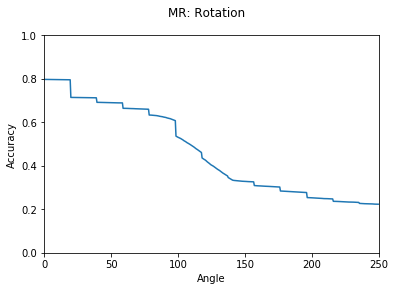

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.axis([0, 250, 0, 1])
plt.plot(np.arange(0,250,0.5),accMat)
plt.xlabel("Angle")
plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

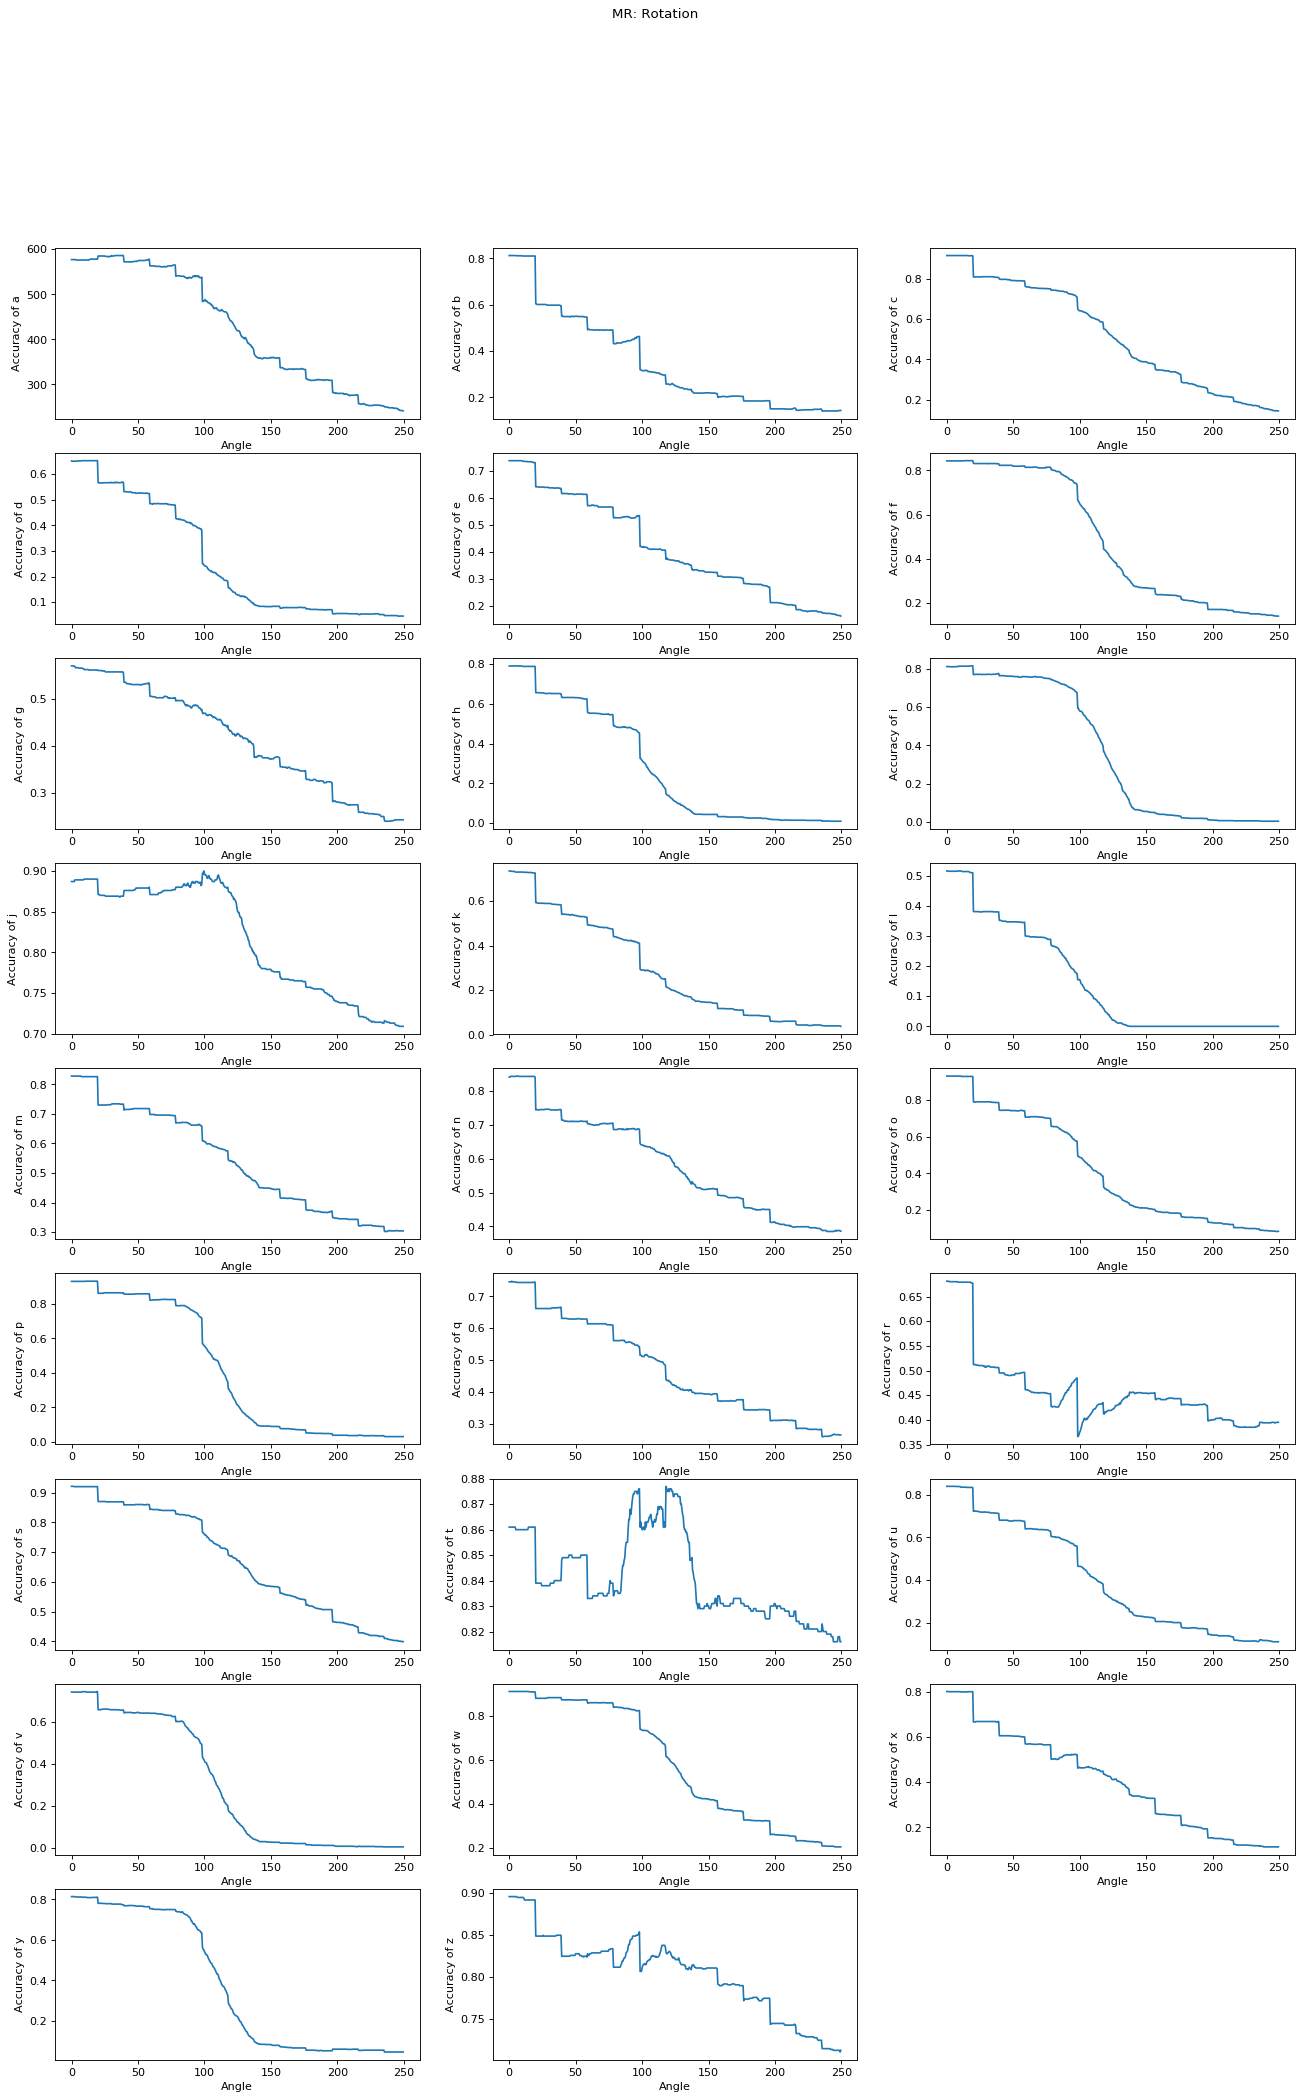

In [22]:
figure(num=None, figsize=(20, 30), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(num_classes):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])
    plt.subplot(9,3,j+1)
    plt.plot(np.arange(0,250,0.5),zero)
    plt.xlabel("Angle")
    plt.ylabel("Accuracy of %s" %chr(97+j))
plt.suptitle("MR: Rotation")
plt.show()

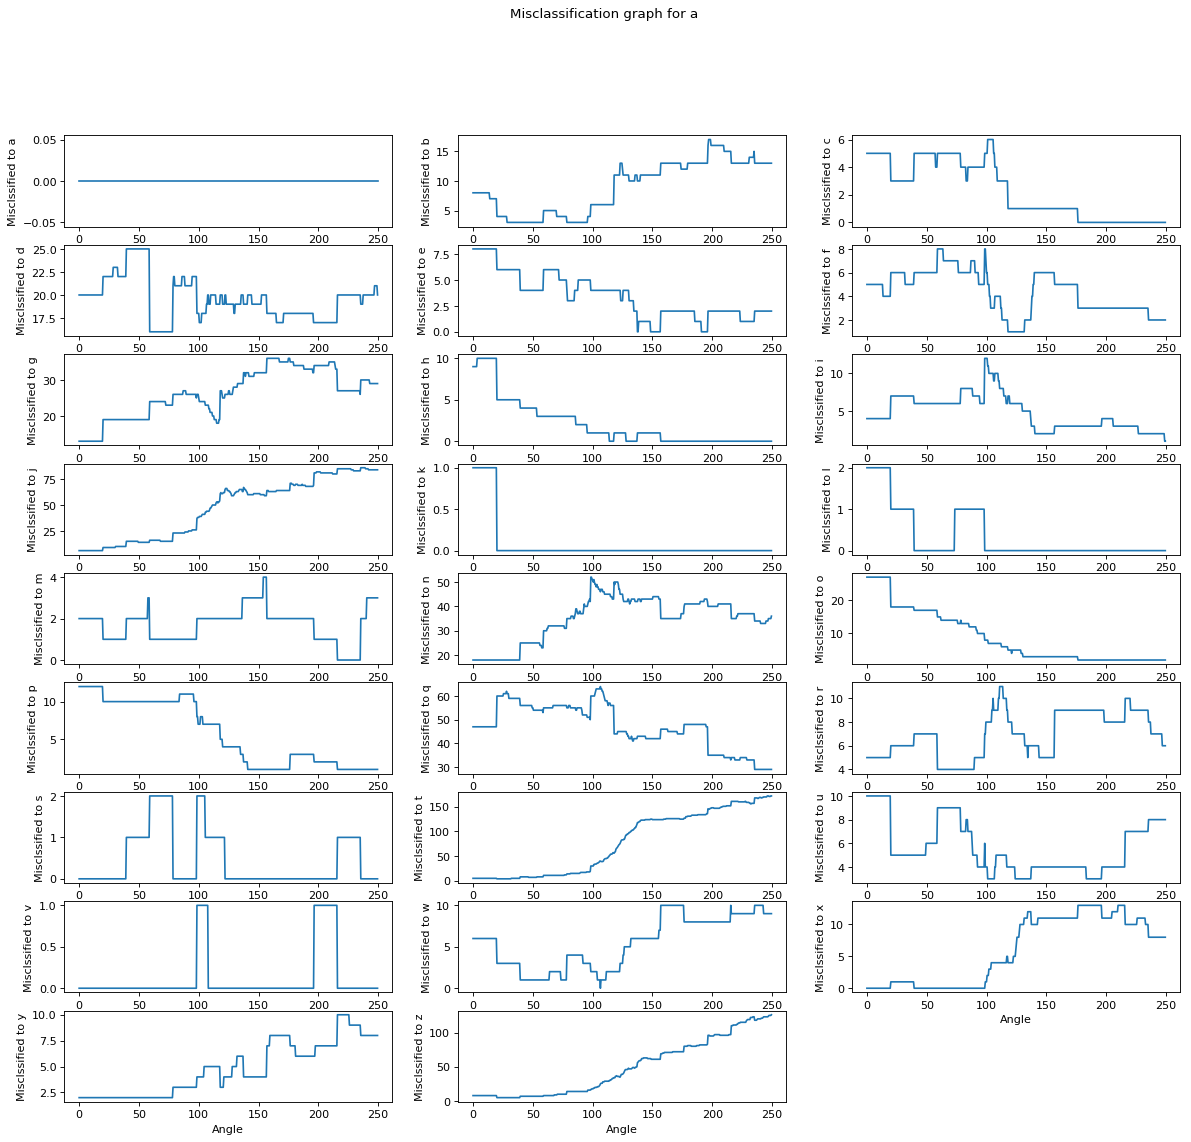

---------------------------------------------------------------------------------------------------------------------


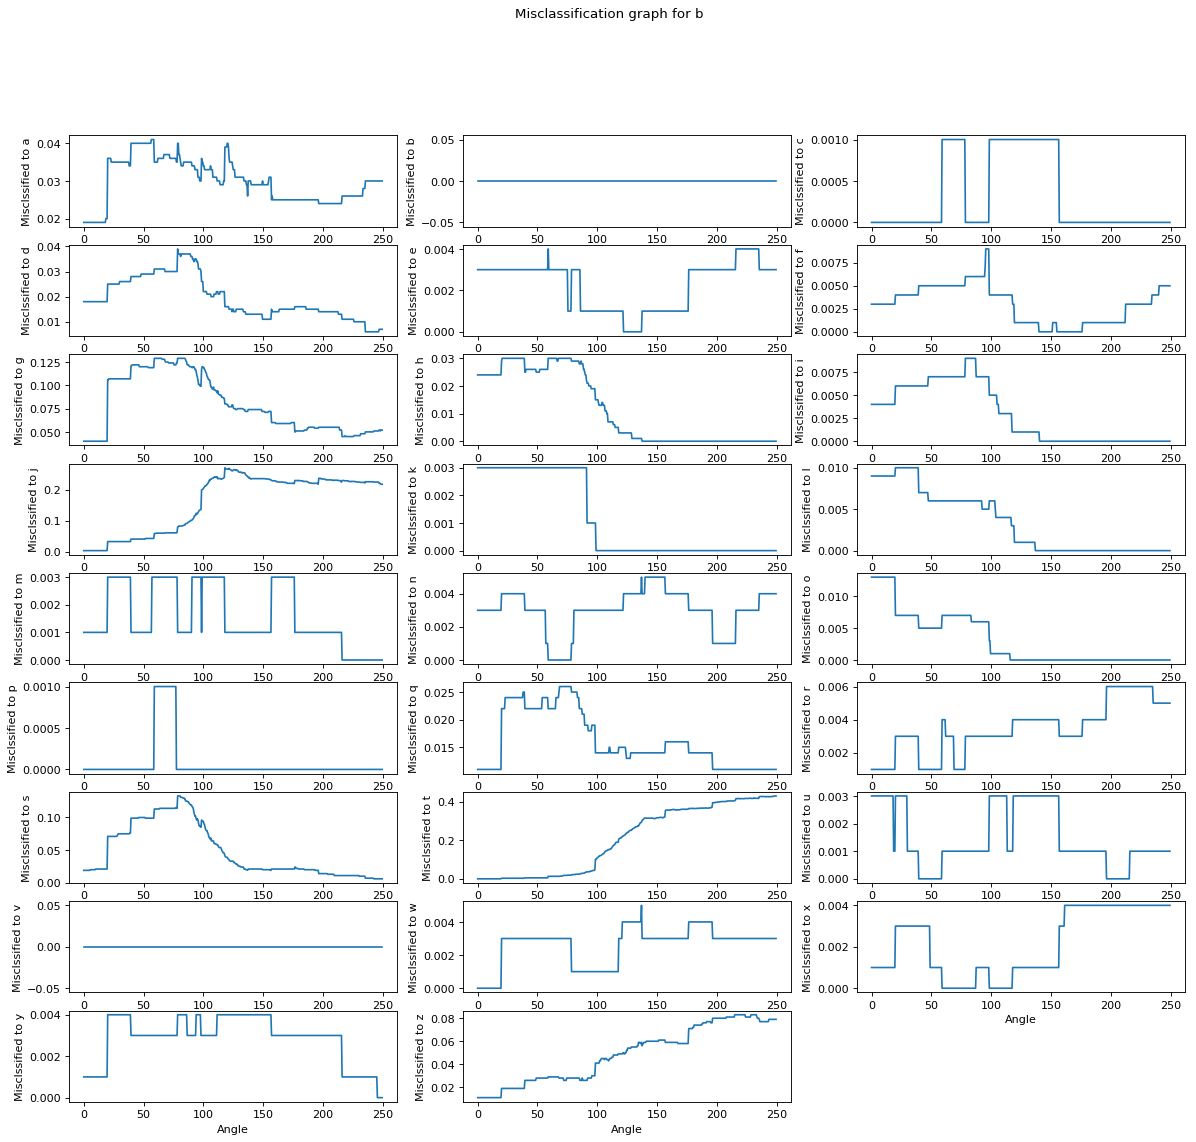

---------------------------------------------------------------------------------------------------------------------


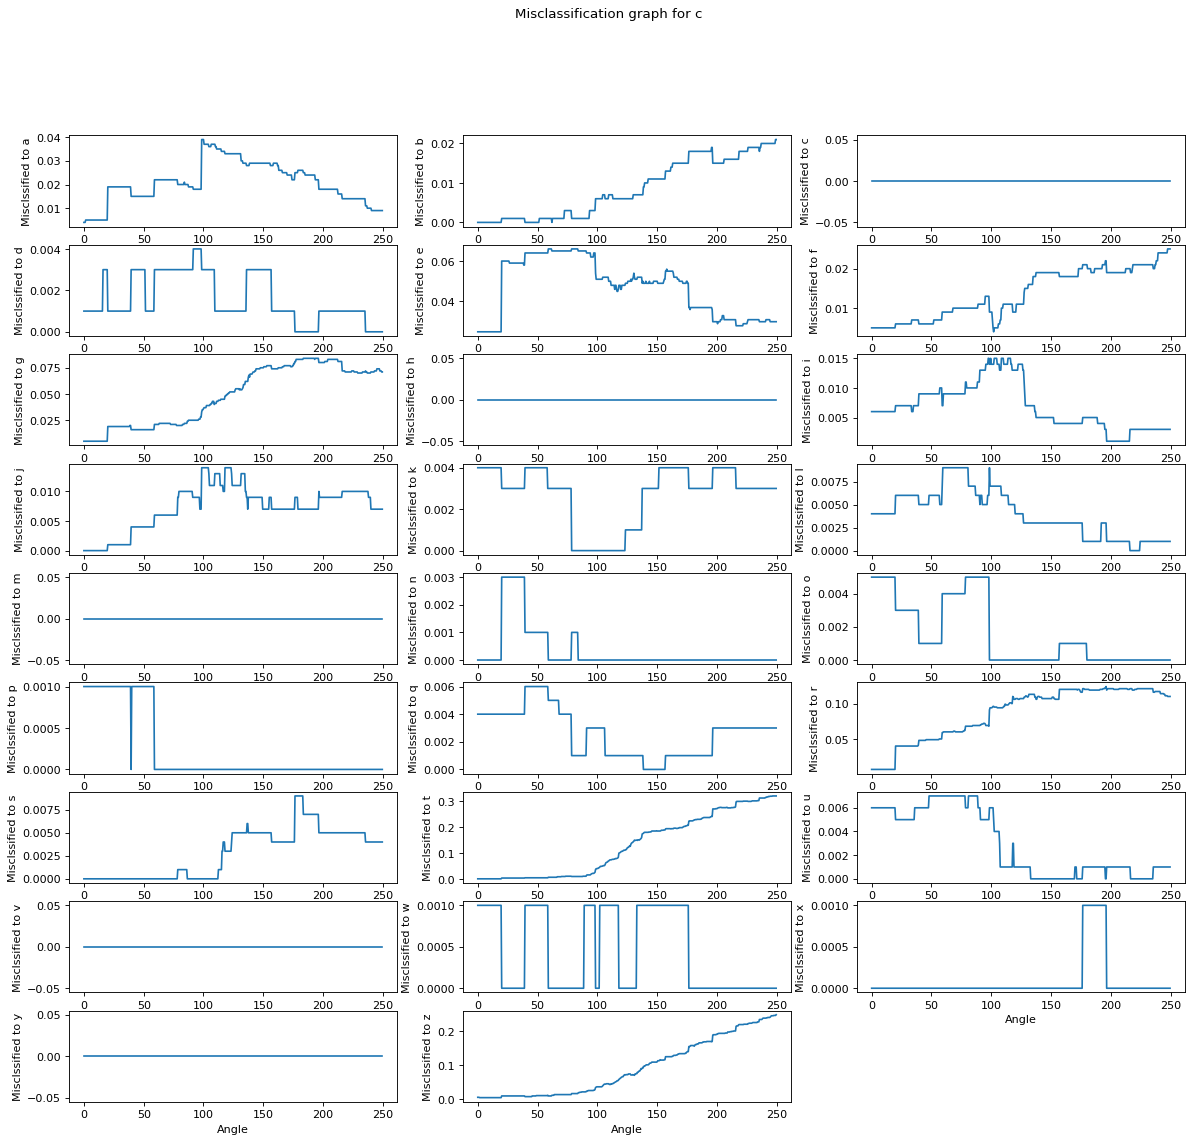

---------------------------------------------------------------------------------------------------------------------


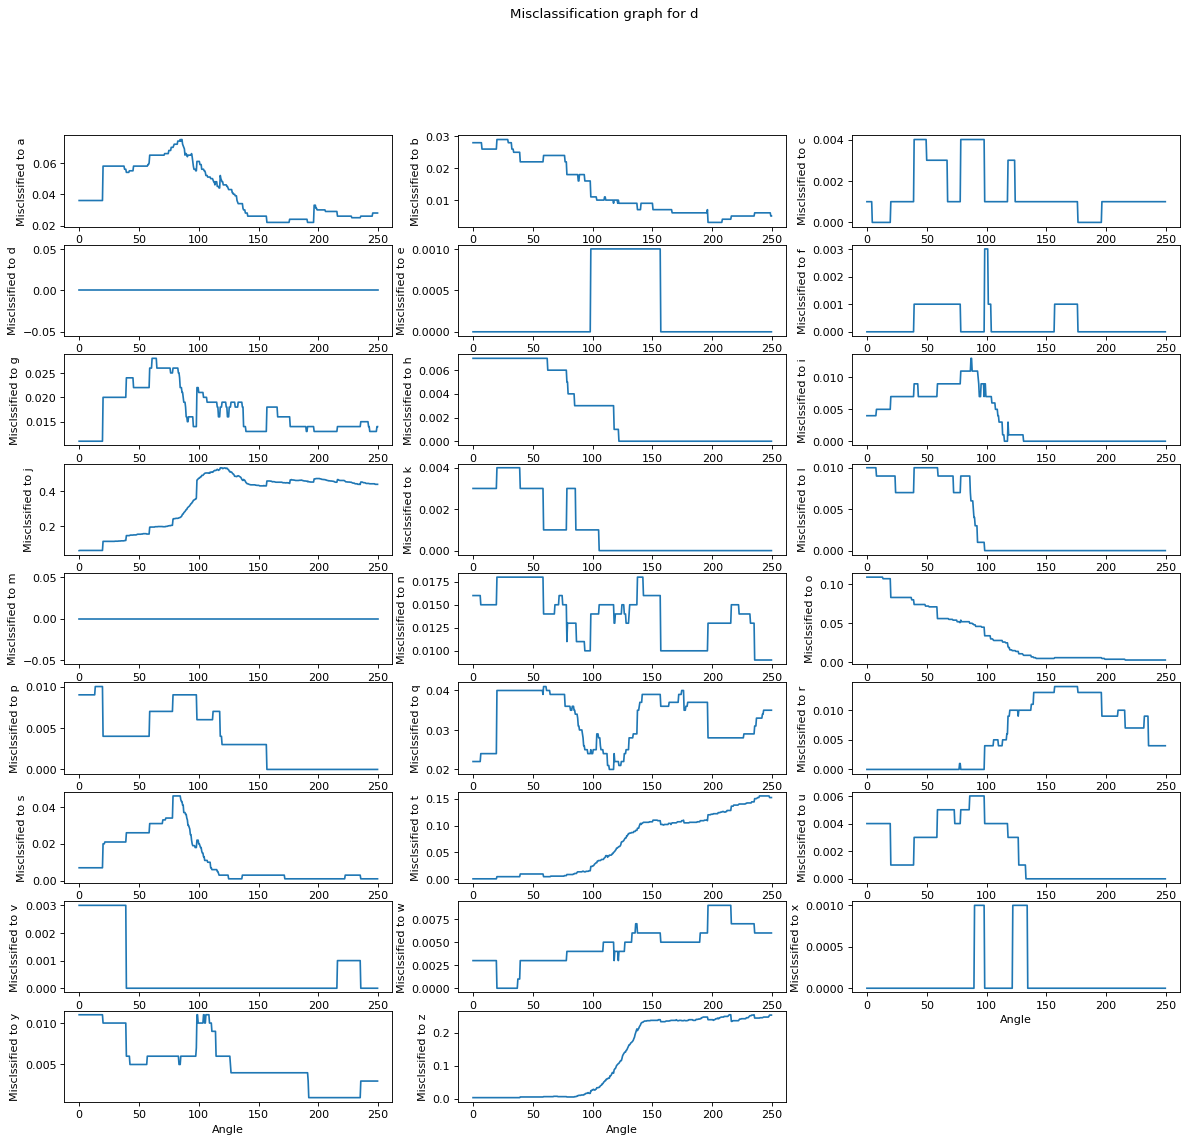

---------------------------------------------------------------------------------------------------------------------


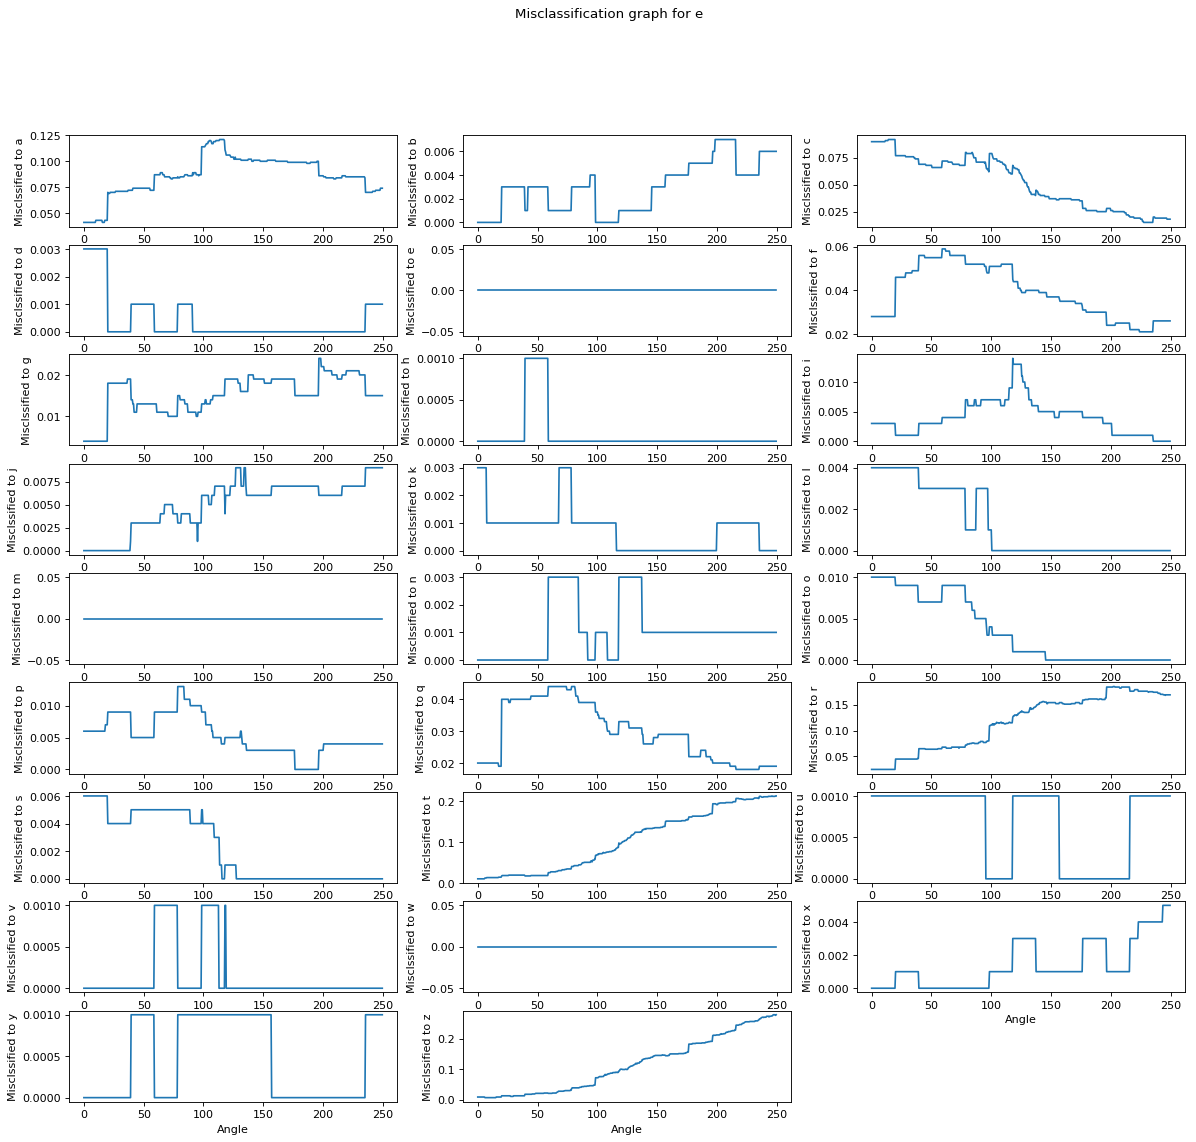

---------------------------------------------------------------------------------------------------------------------


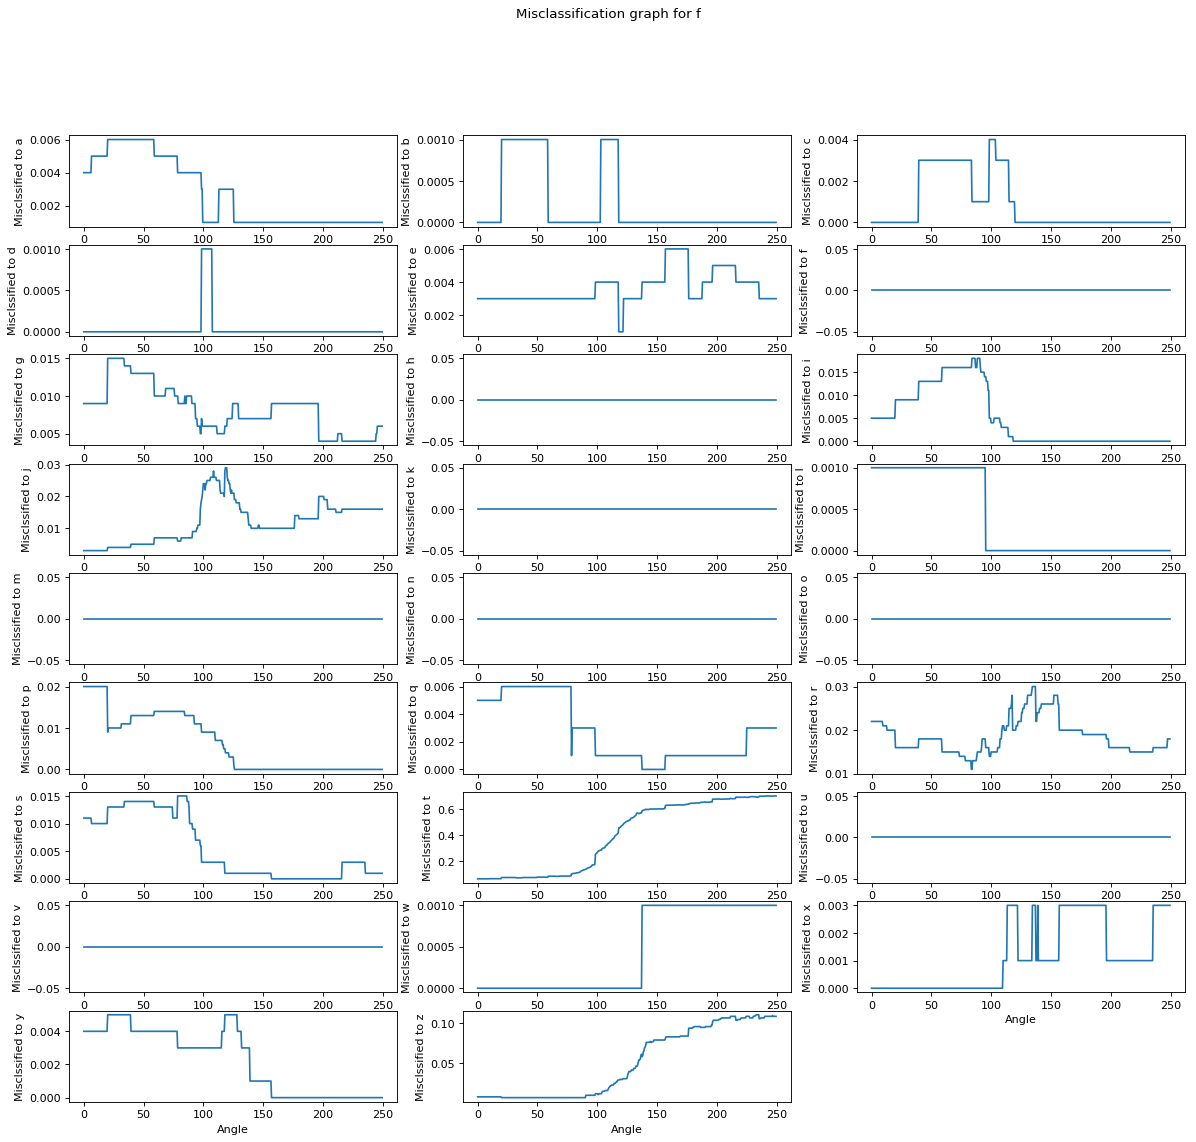

---------------------------------------------------------------------------------------------------------------------


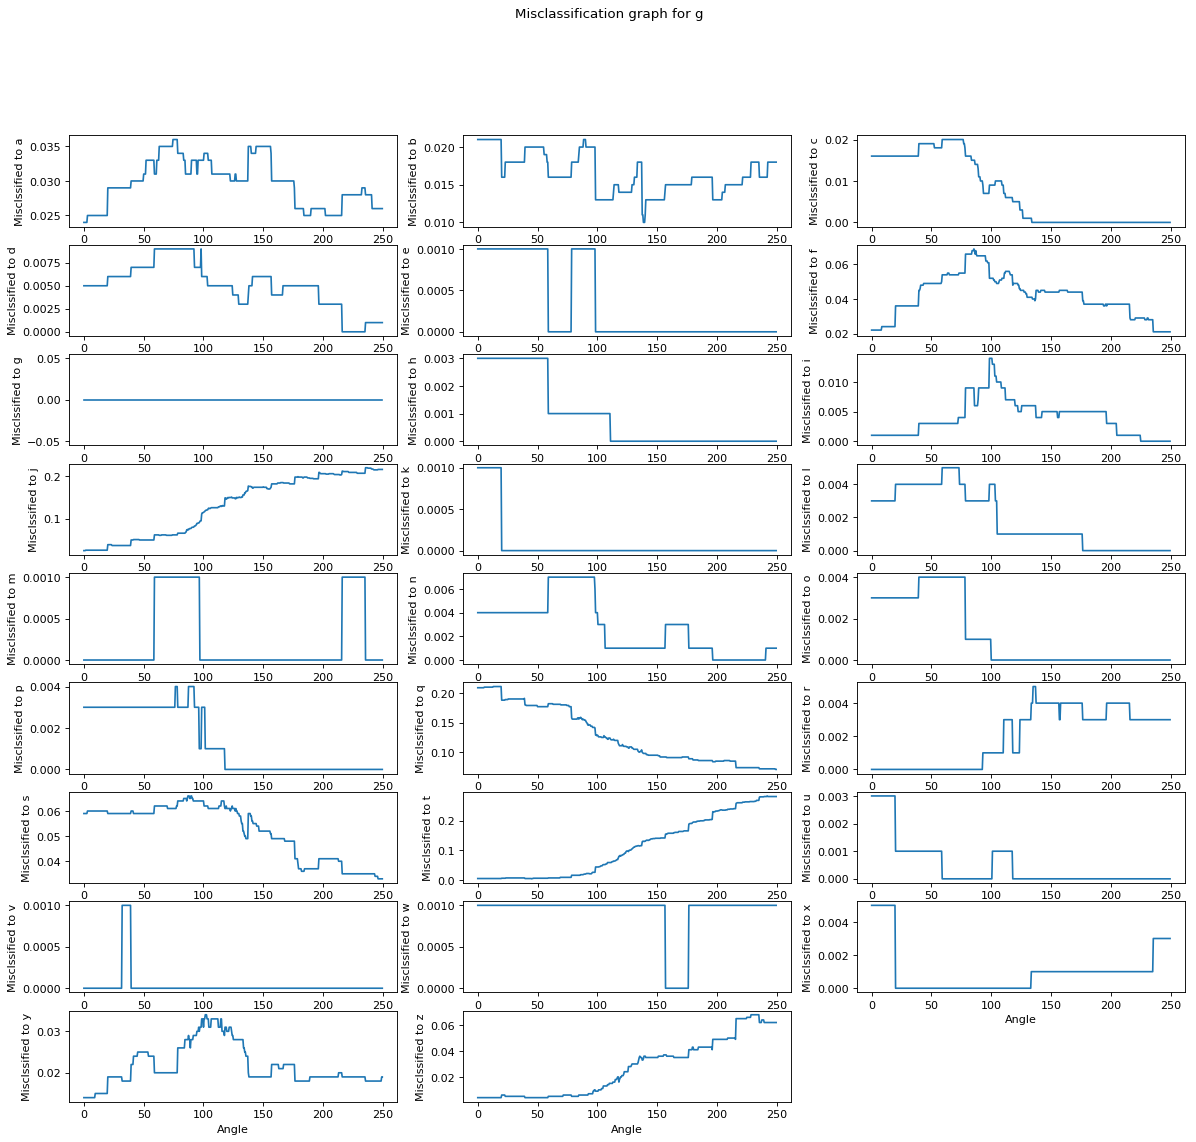

---------------------------------------------------------------------------------------------------------------------


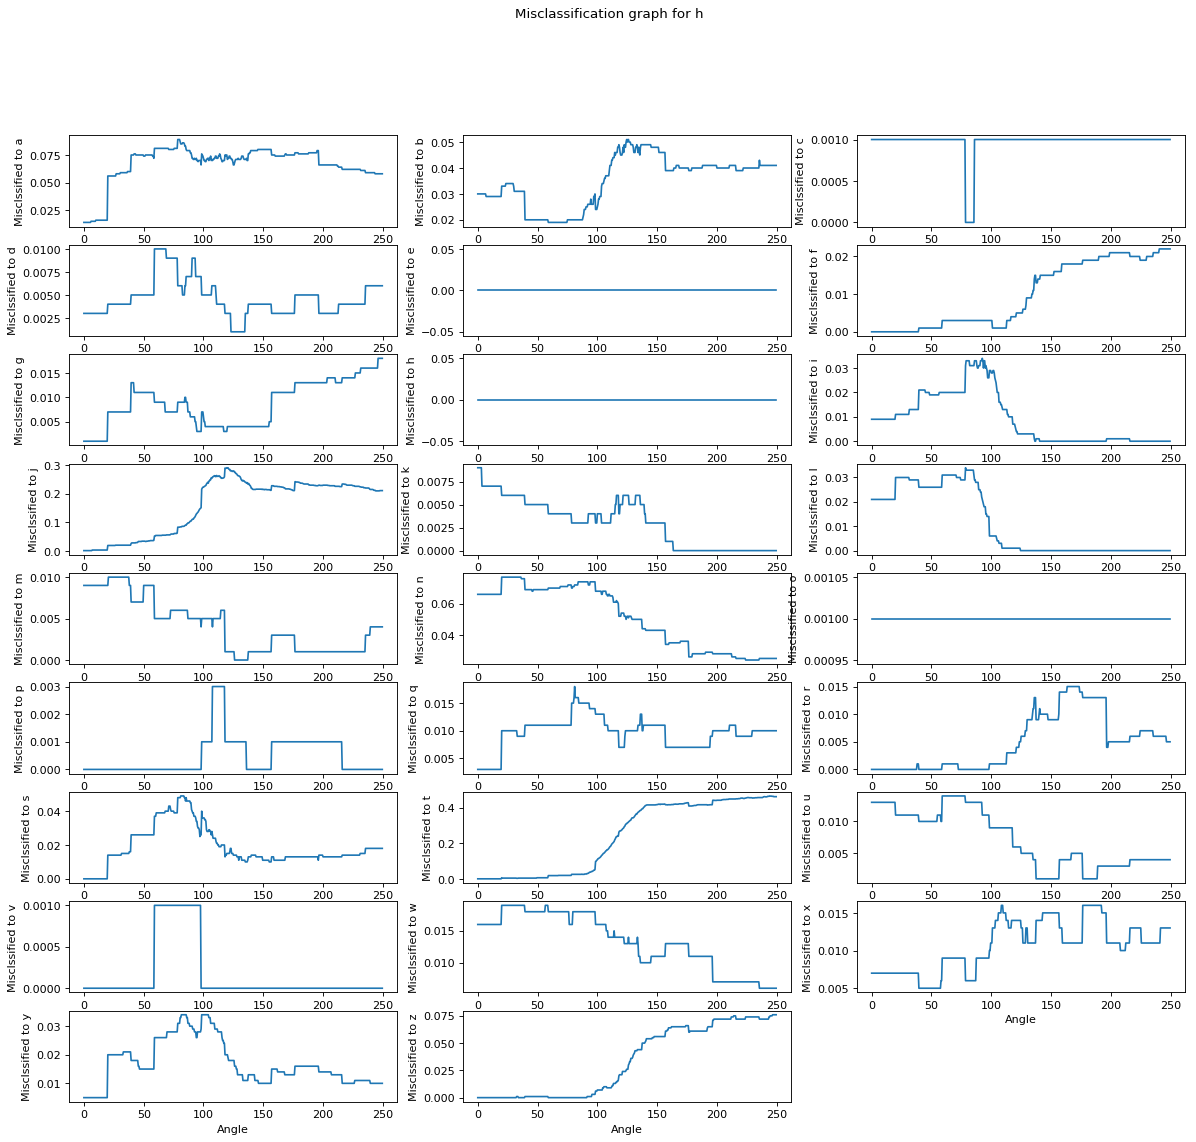

---------------------------------------------------------------------------------------------------------------------


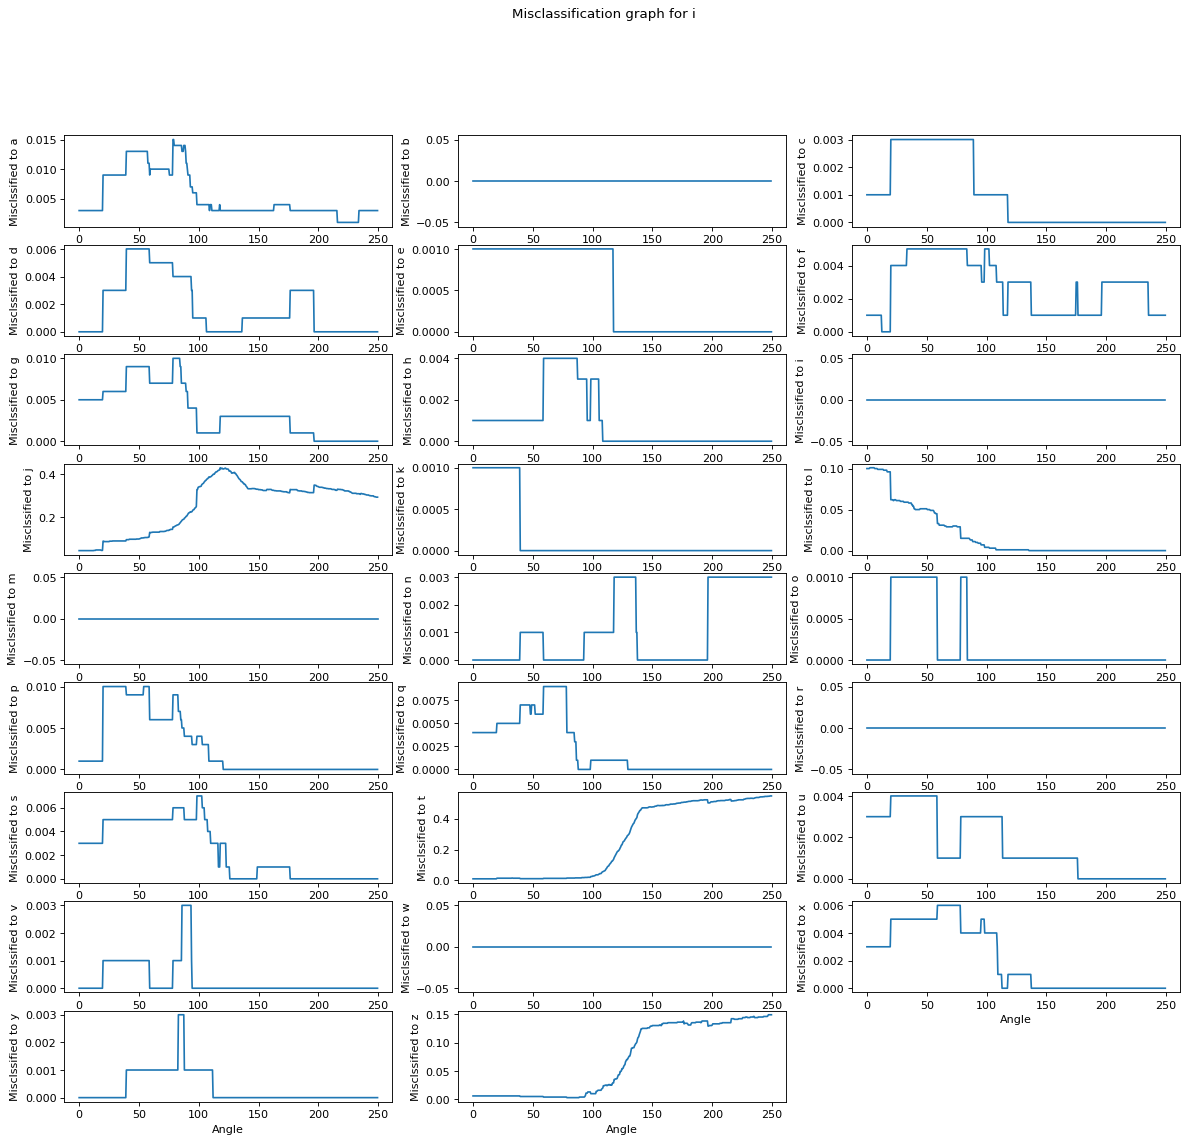

---------------------------------------------------------------------------------------------------------------------


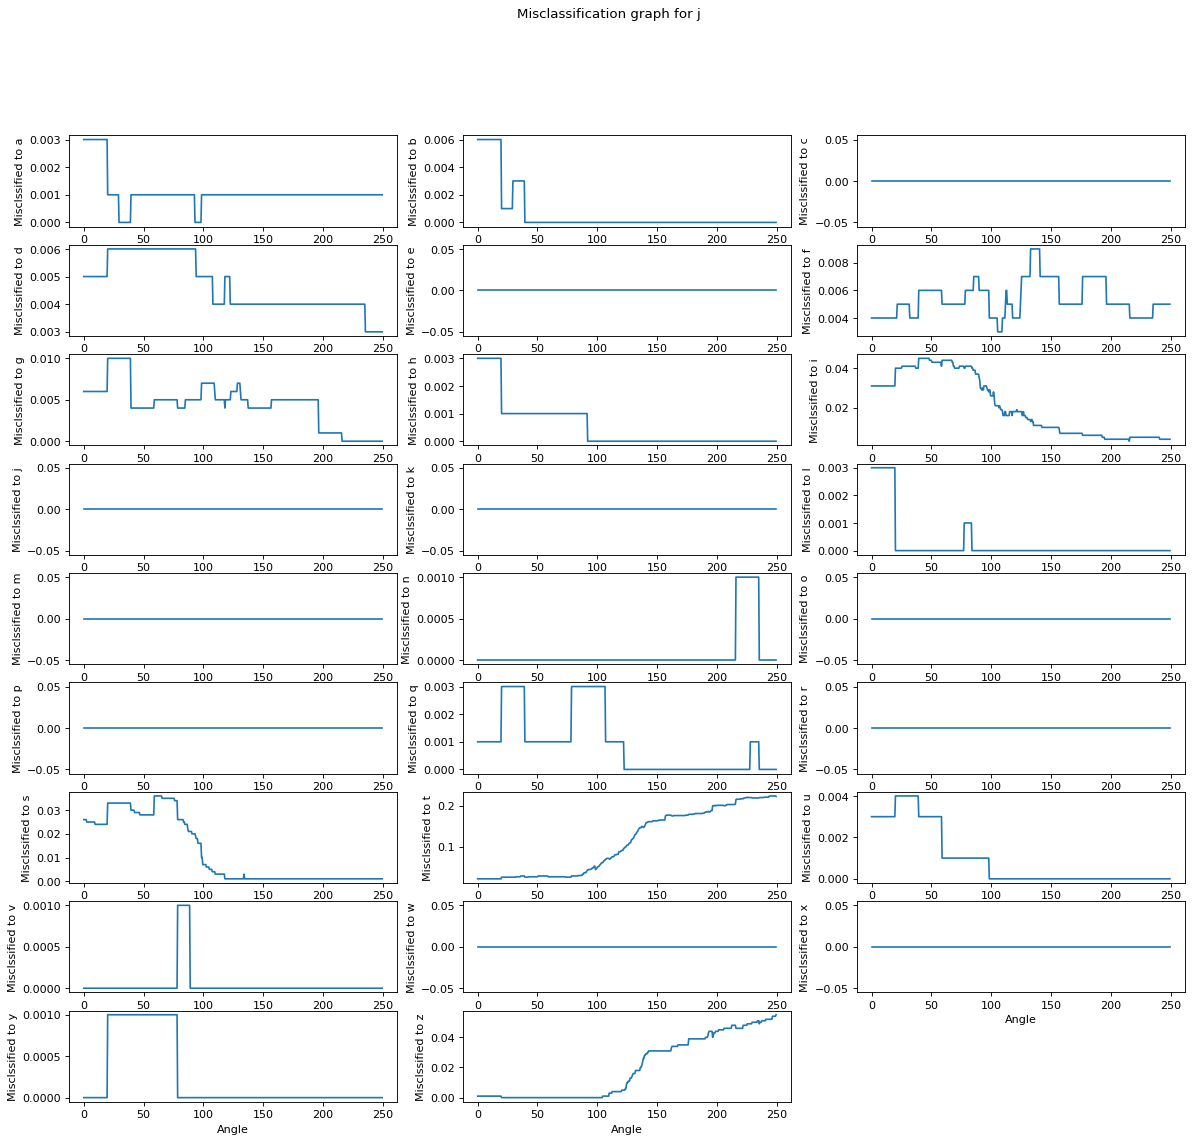

---------------------------------------------------------------------------------------------------------------------


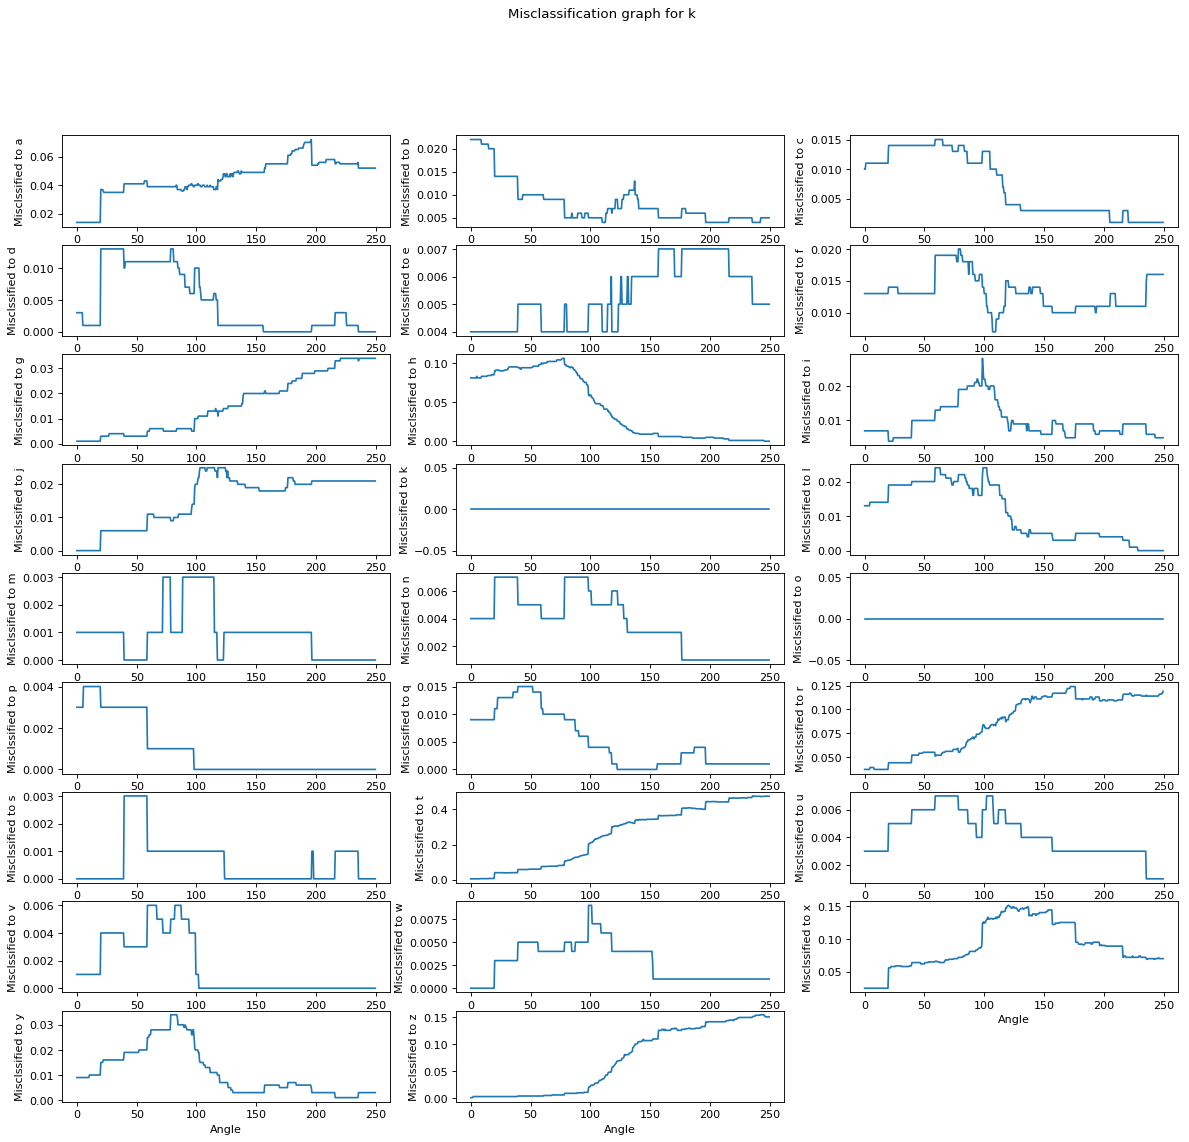

---------------------------------------------------------------------------------------------------------------------


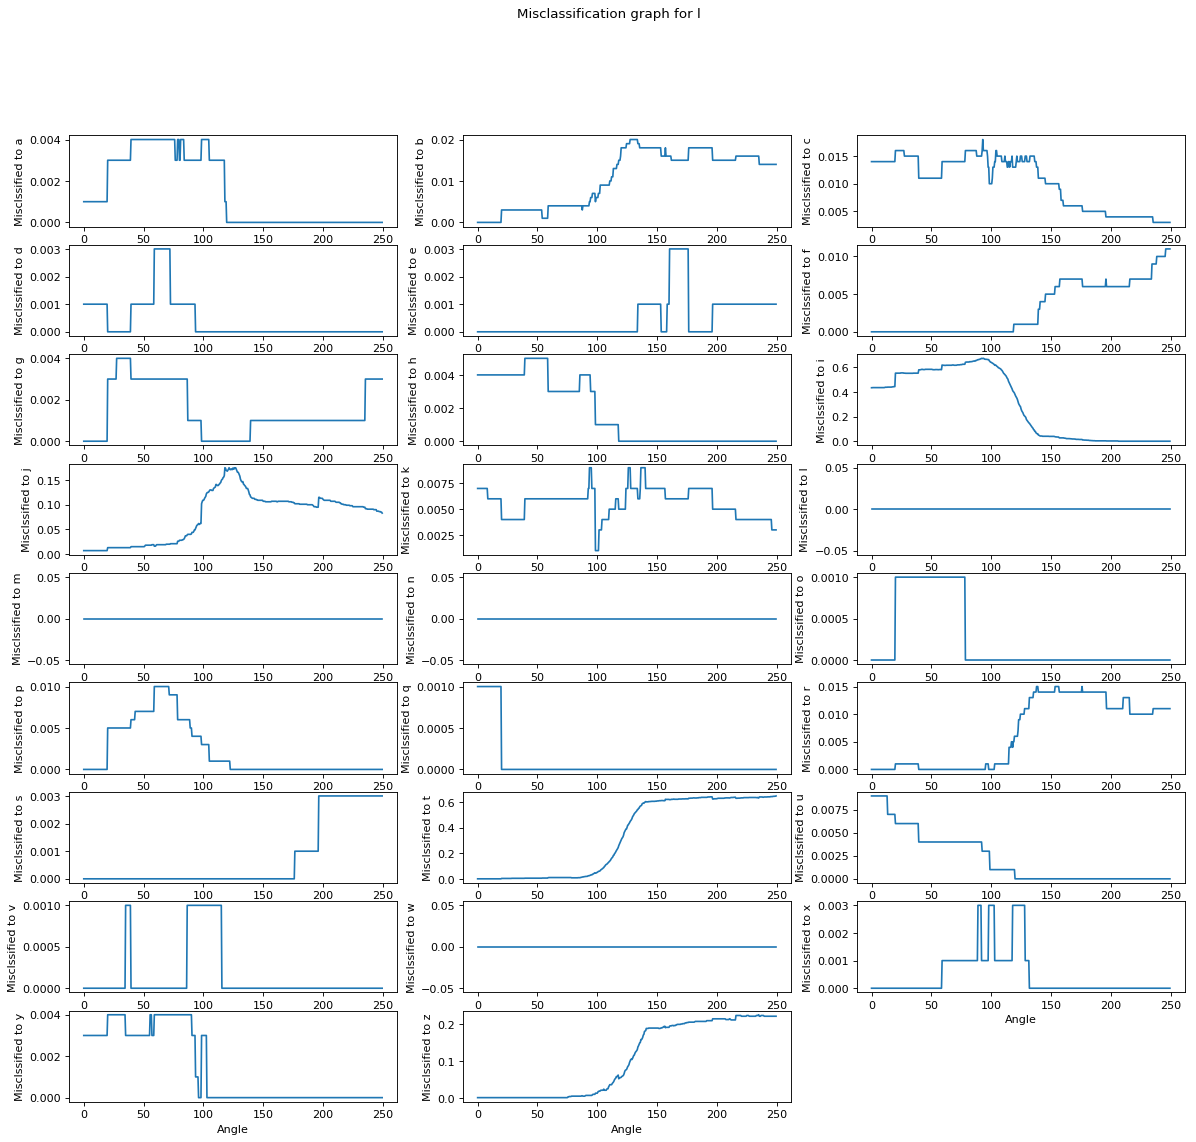

---------------------------------------------------------------------------------------------------------------------


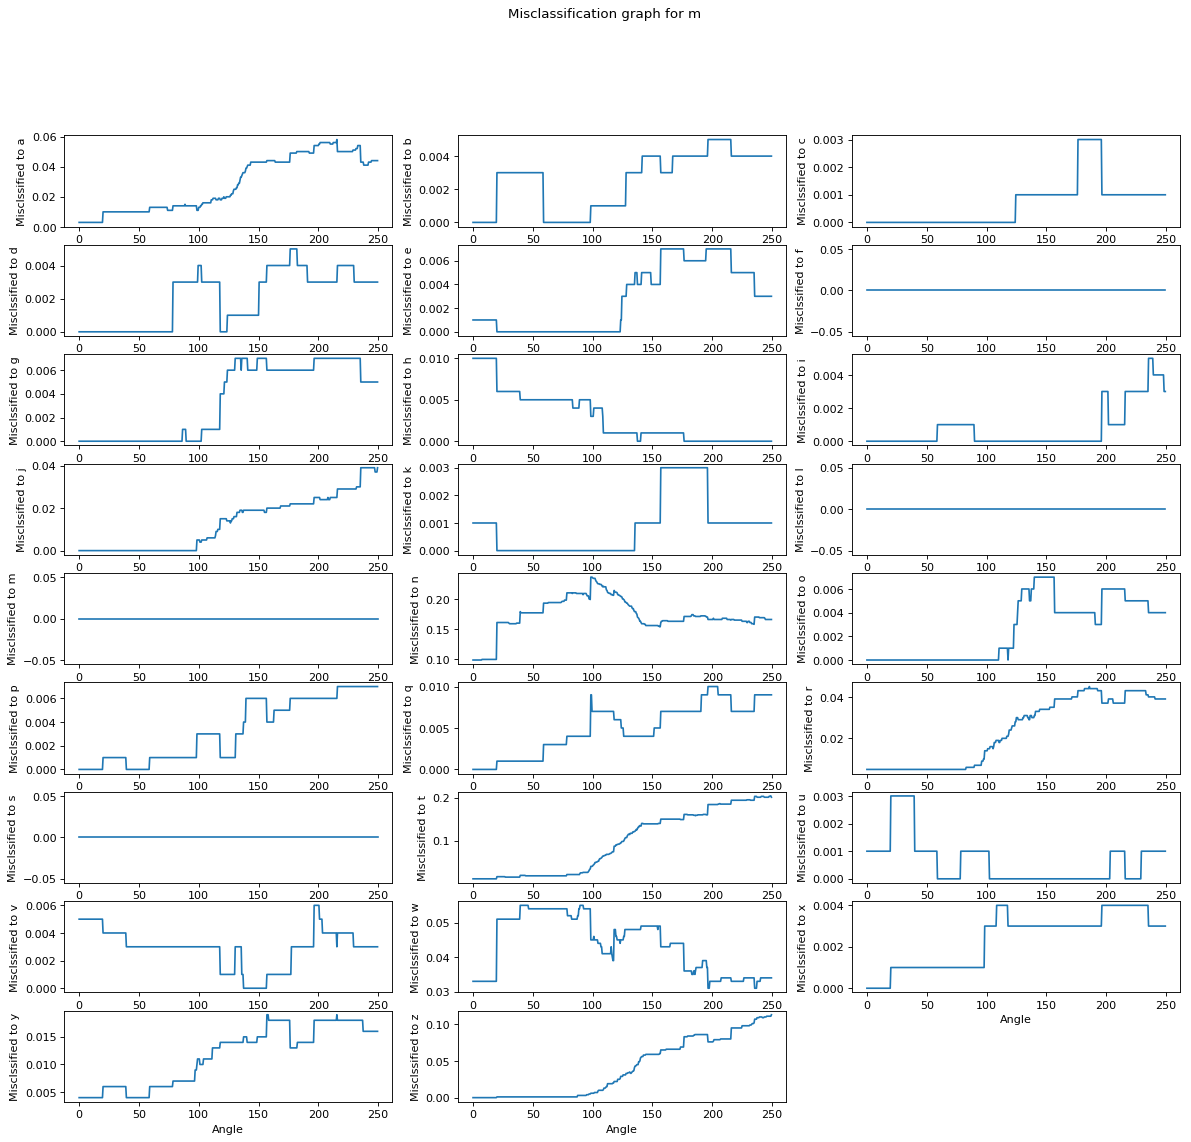

---------------------------------------------------------------------------------------------------------------------


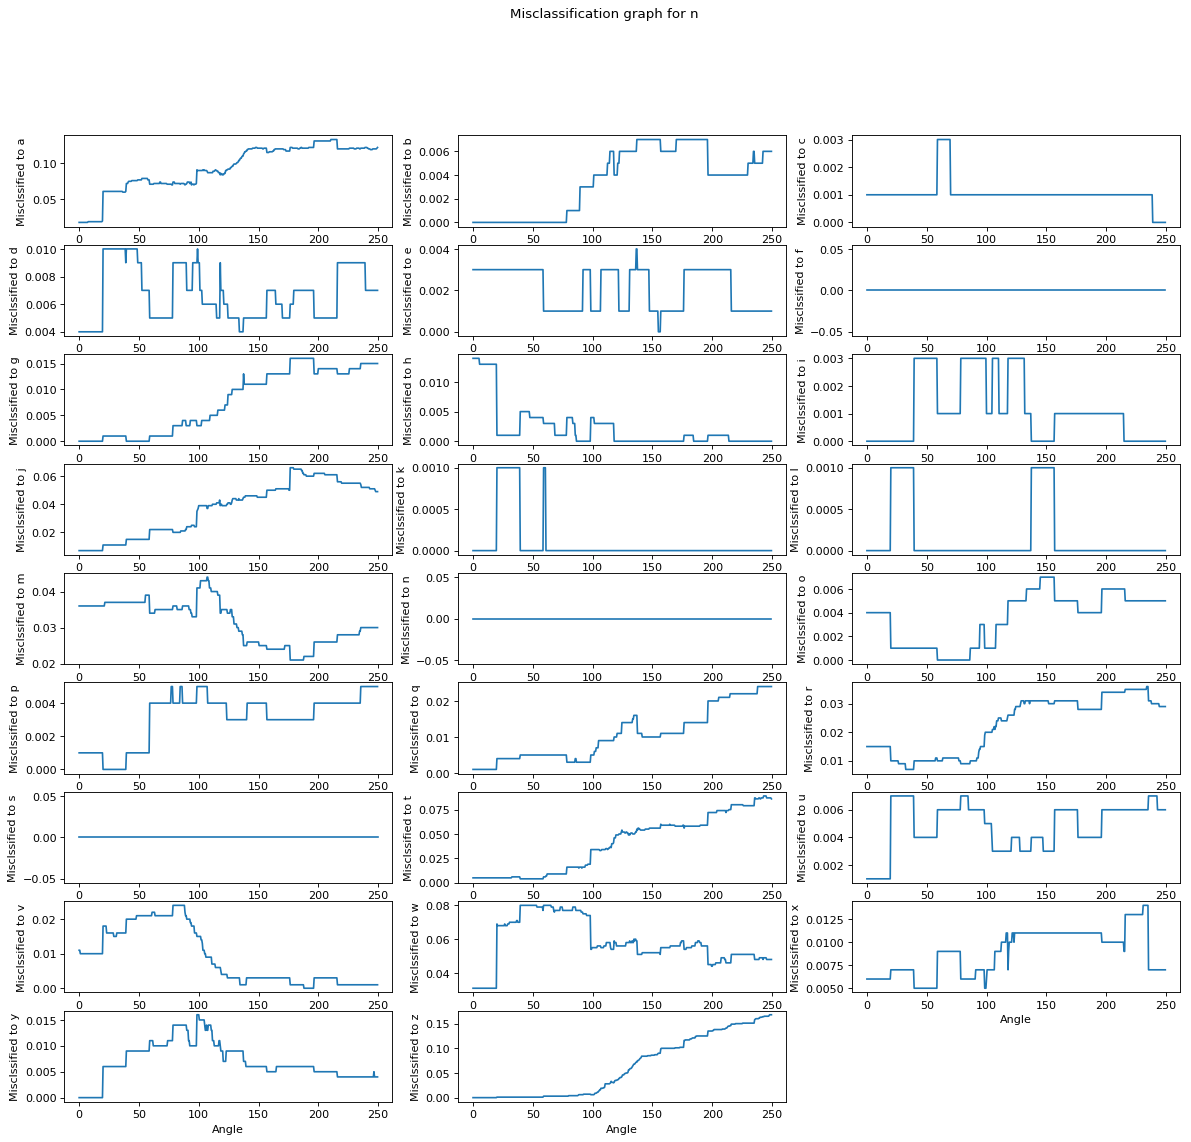

---------------------------------------------------------------------------------------------------------------------


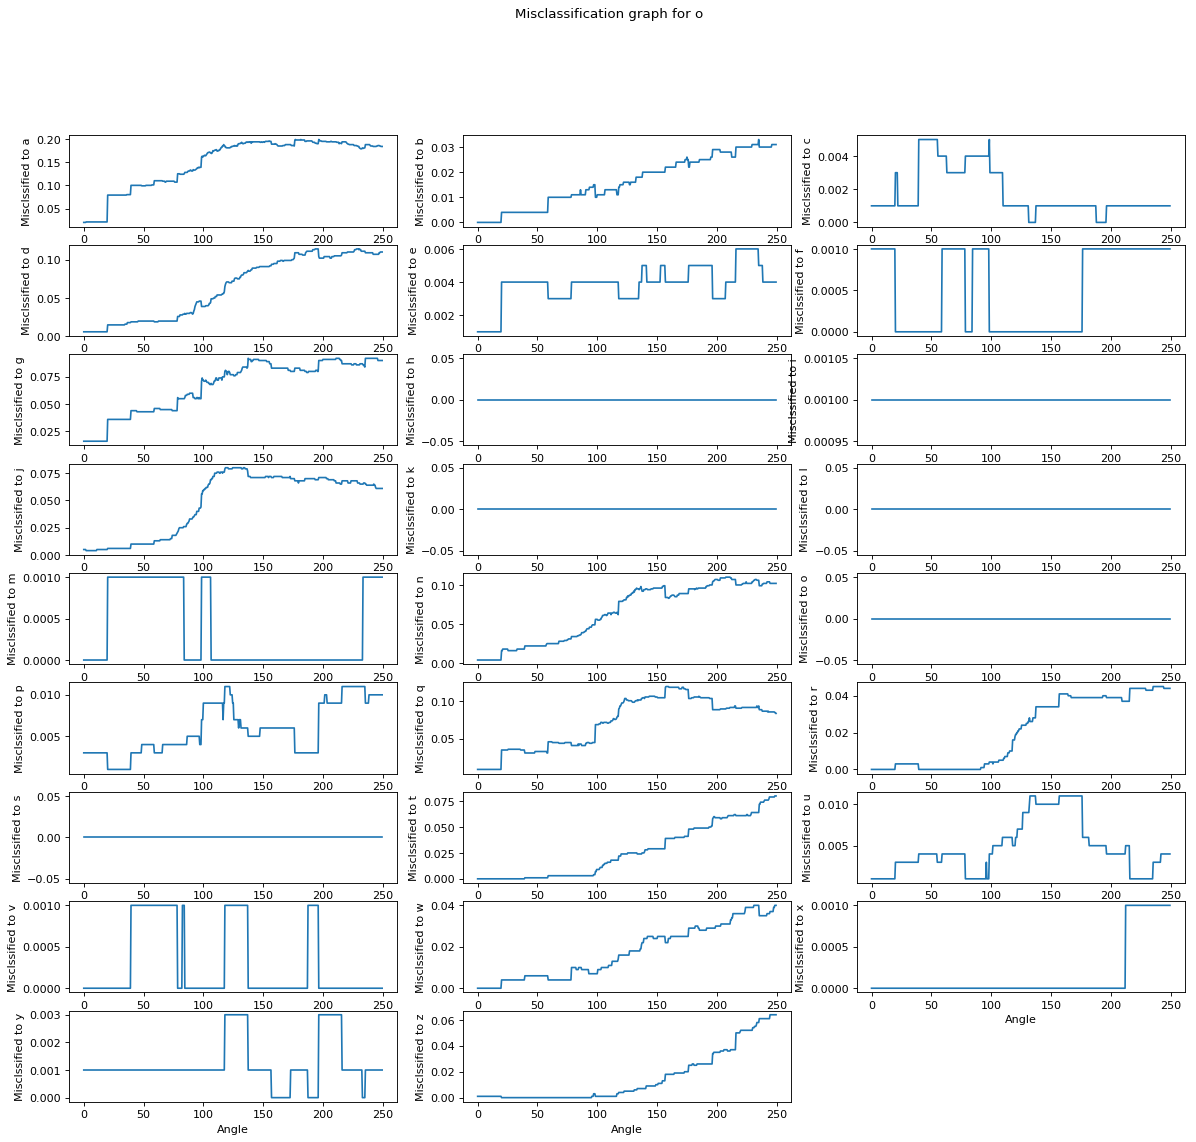

---------------------------------------------------------------------------------------------------------------------


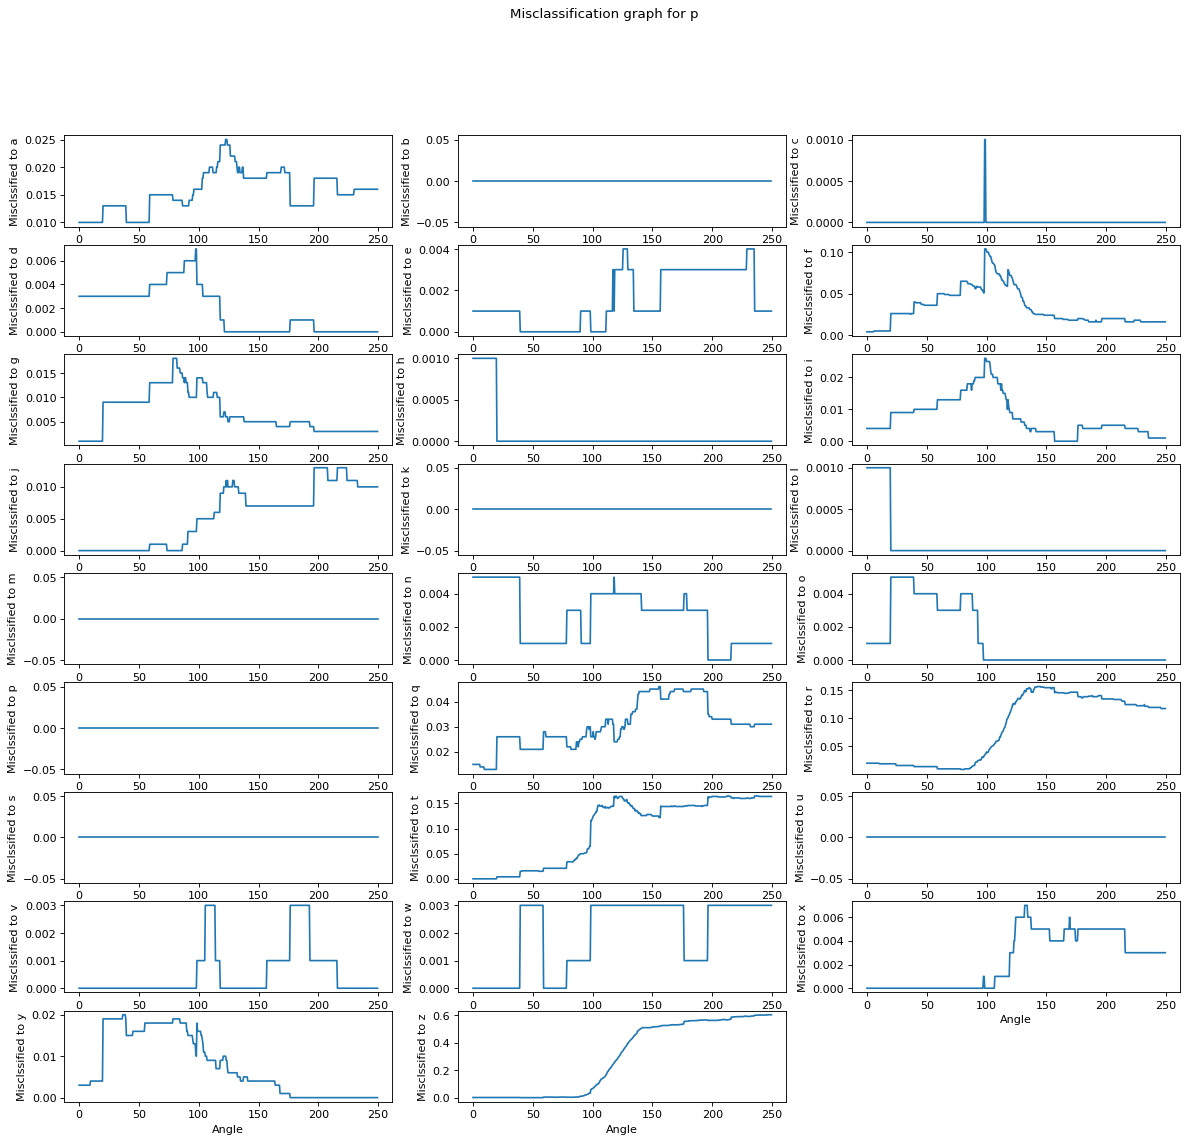

---------------------------------------------------------------------------------------------------------------------


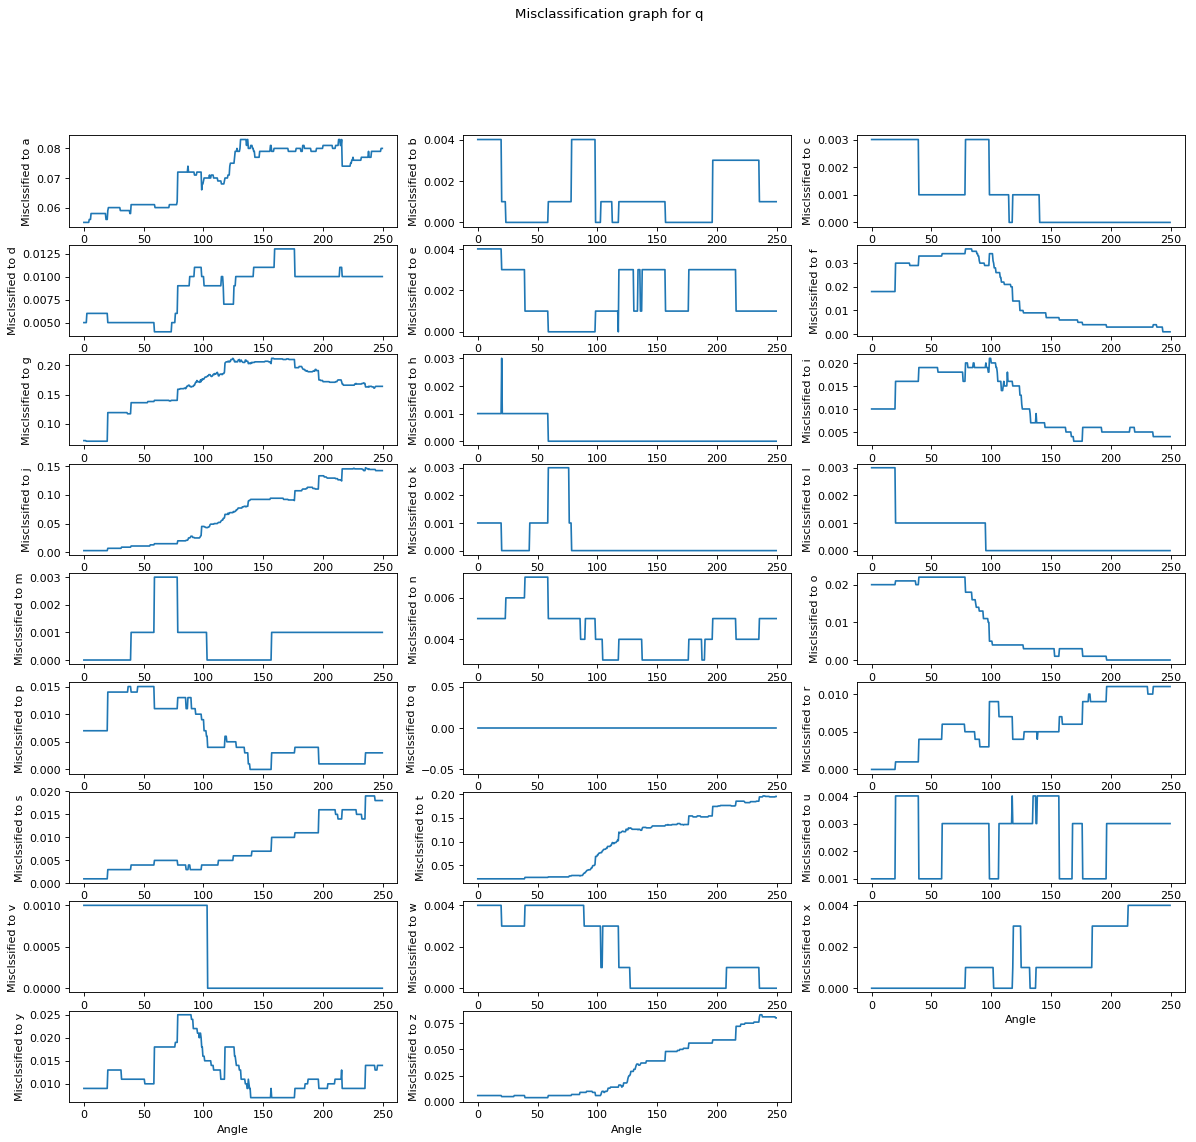

---------------------------------------------------------------------------------------------------------------------


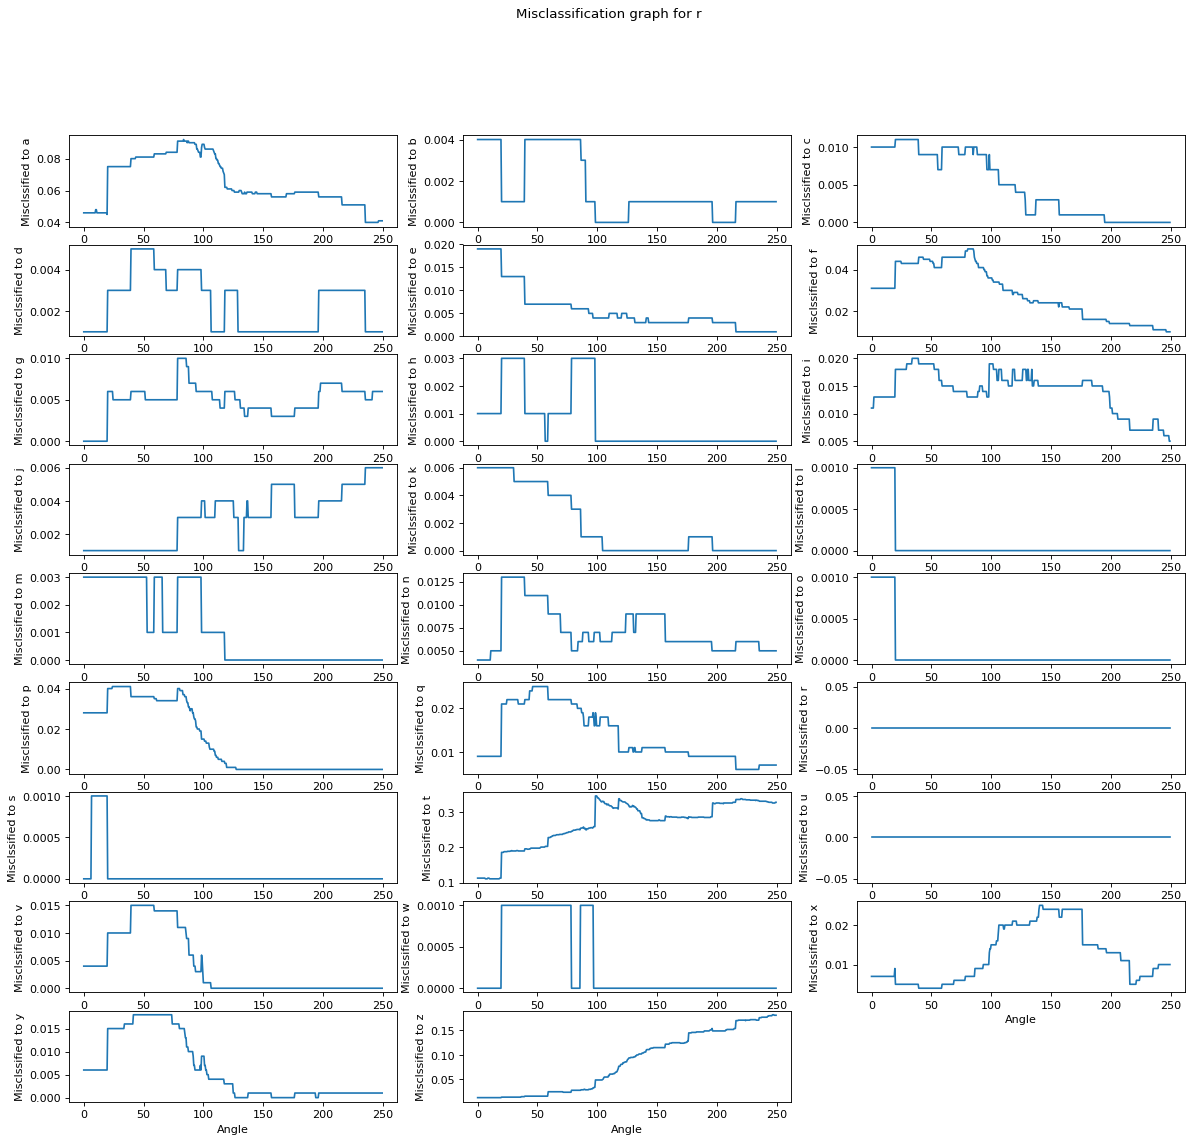

---------------------------------------------------------------------------------------------------------------------


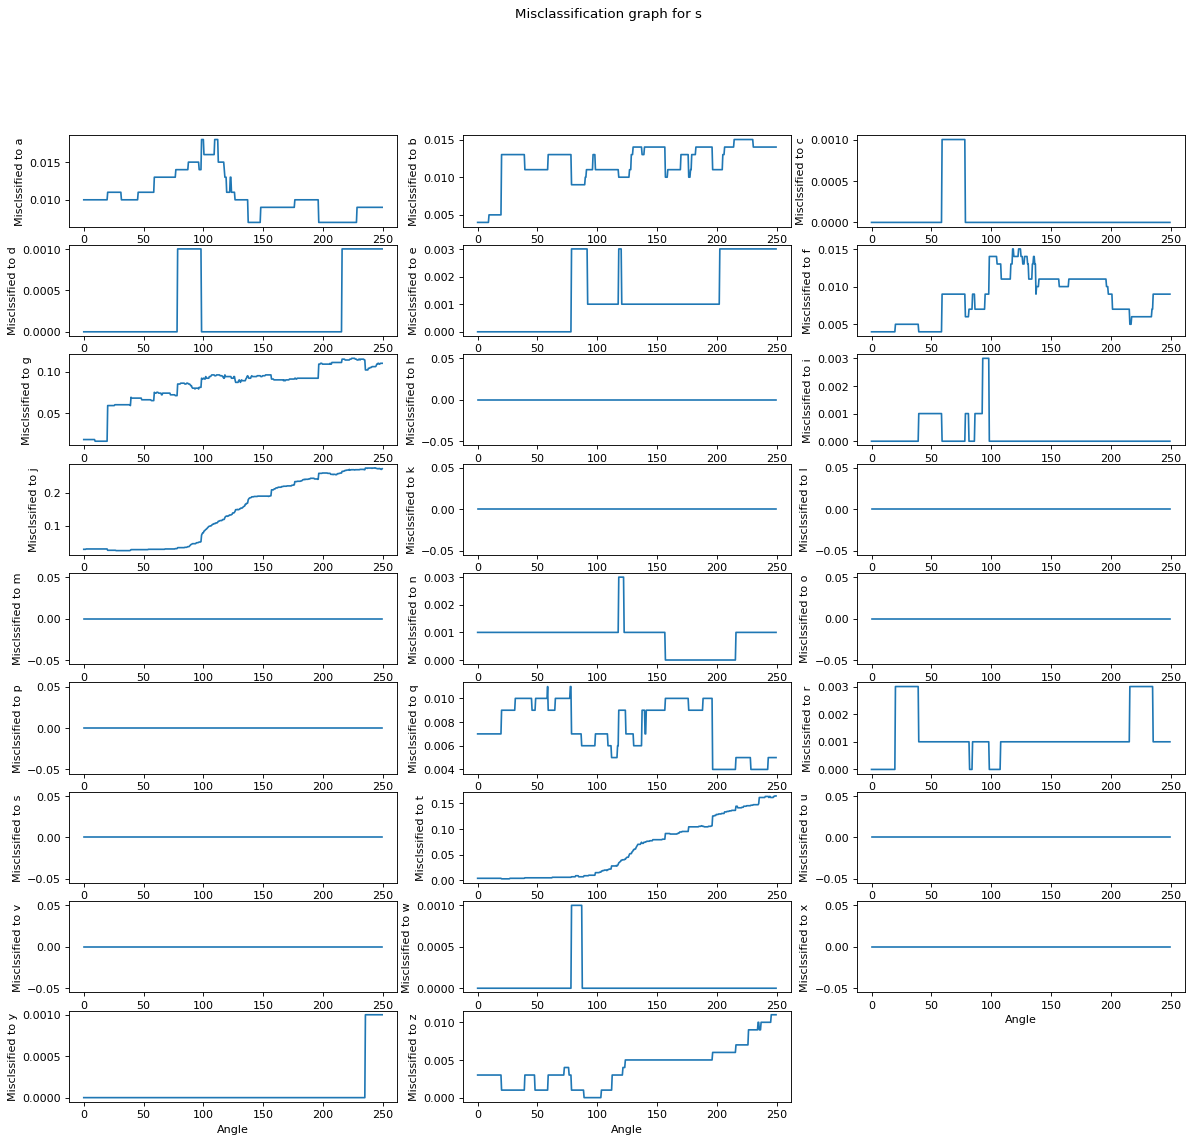

---------------------------------------------------------------------------------------------------------------------


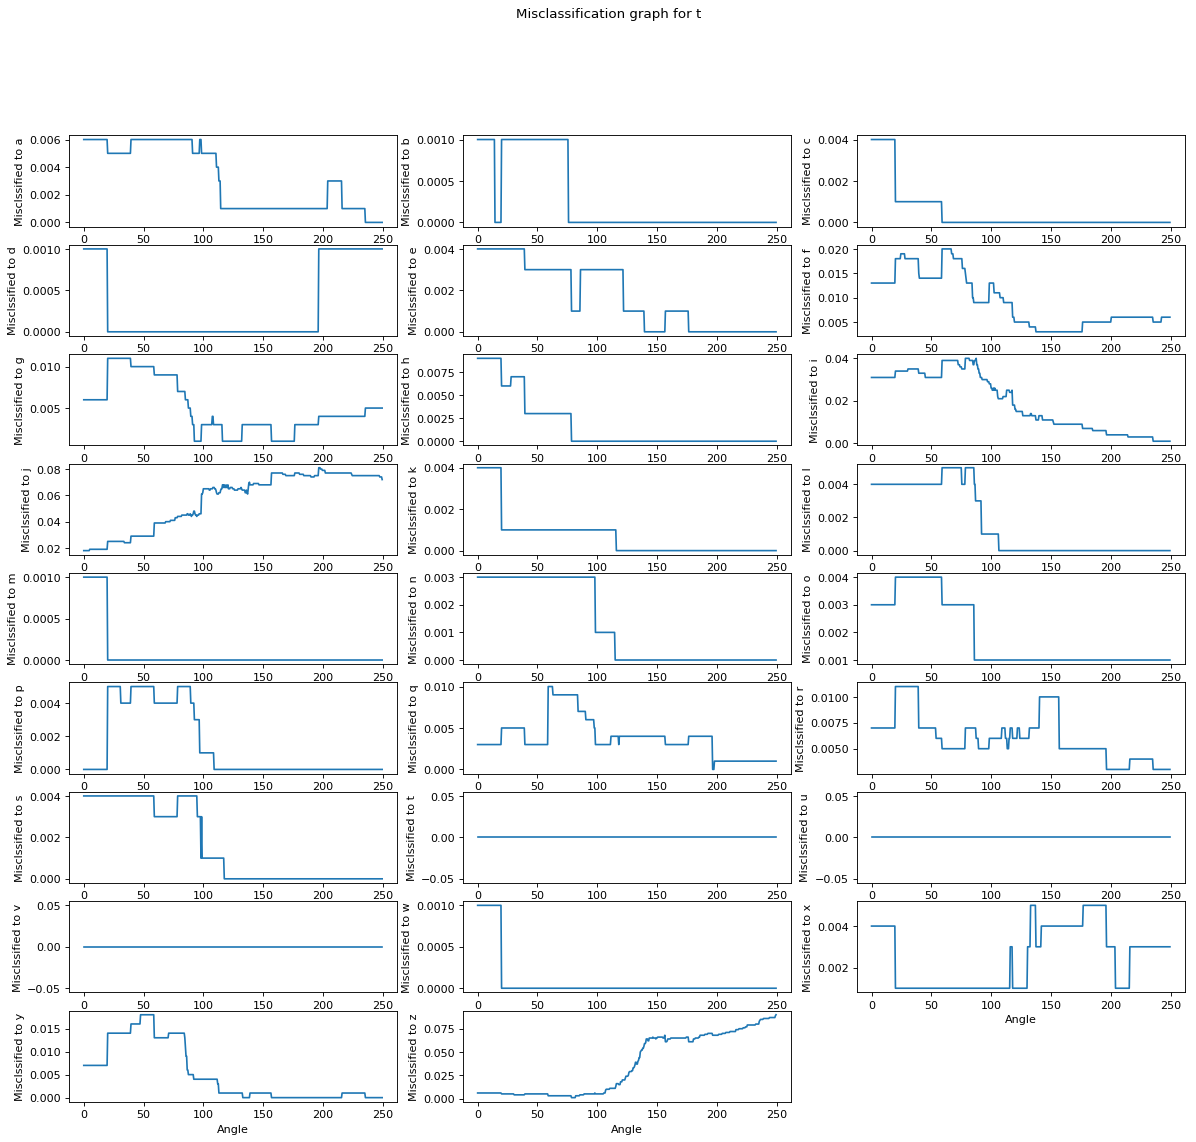

---------------------------------------------------------------------------------------------------------------------


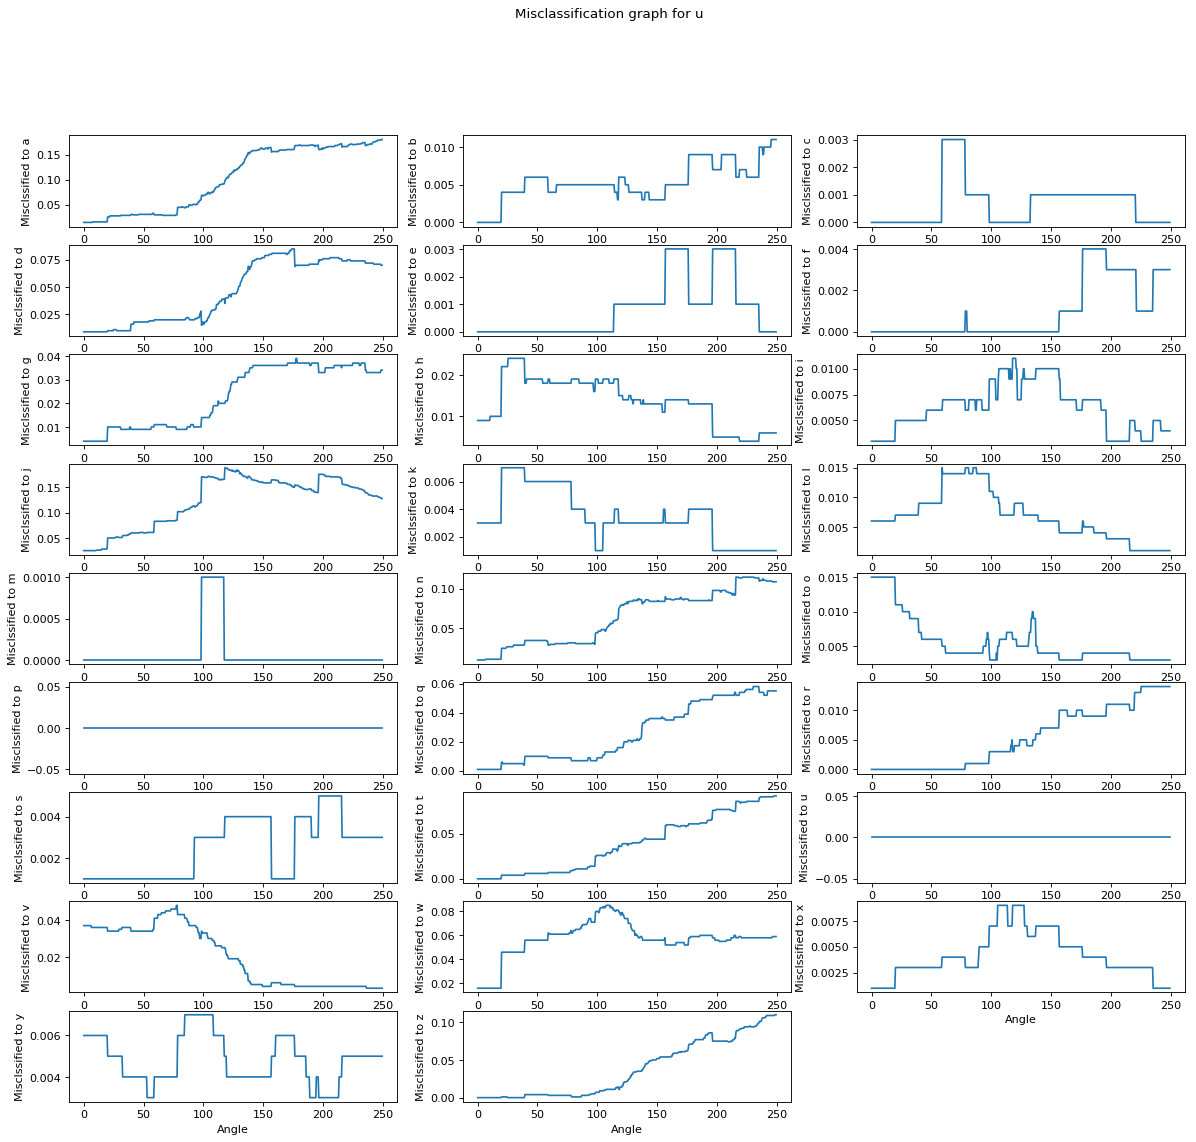

---------------------------------------------------------------------------------------------------------------------


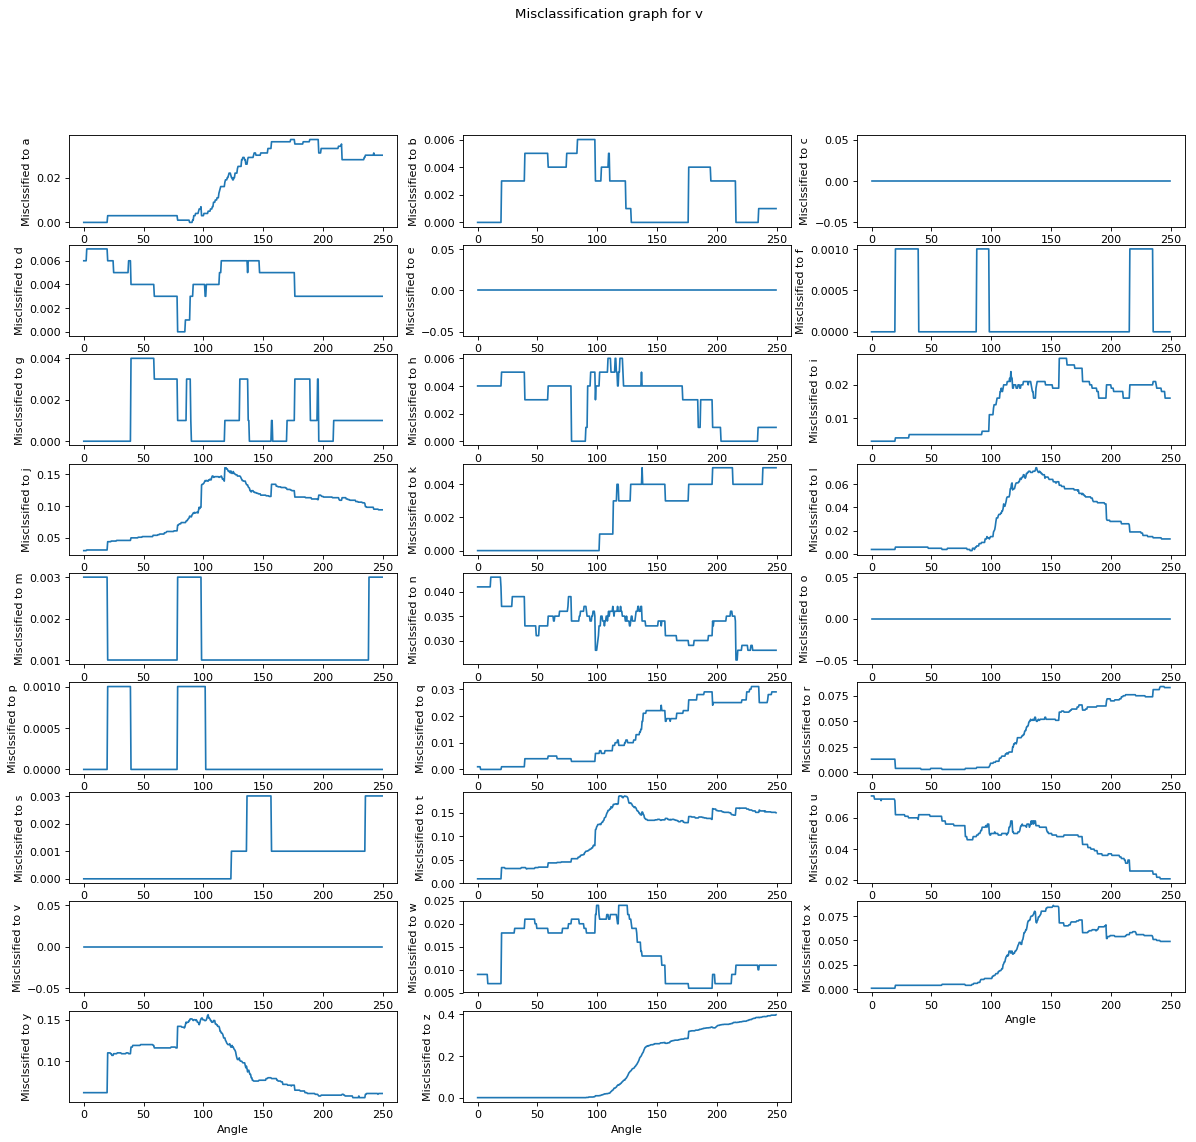

---------------------------------------------------------------------------------------------------------------------


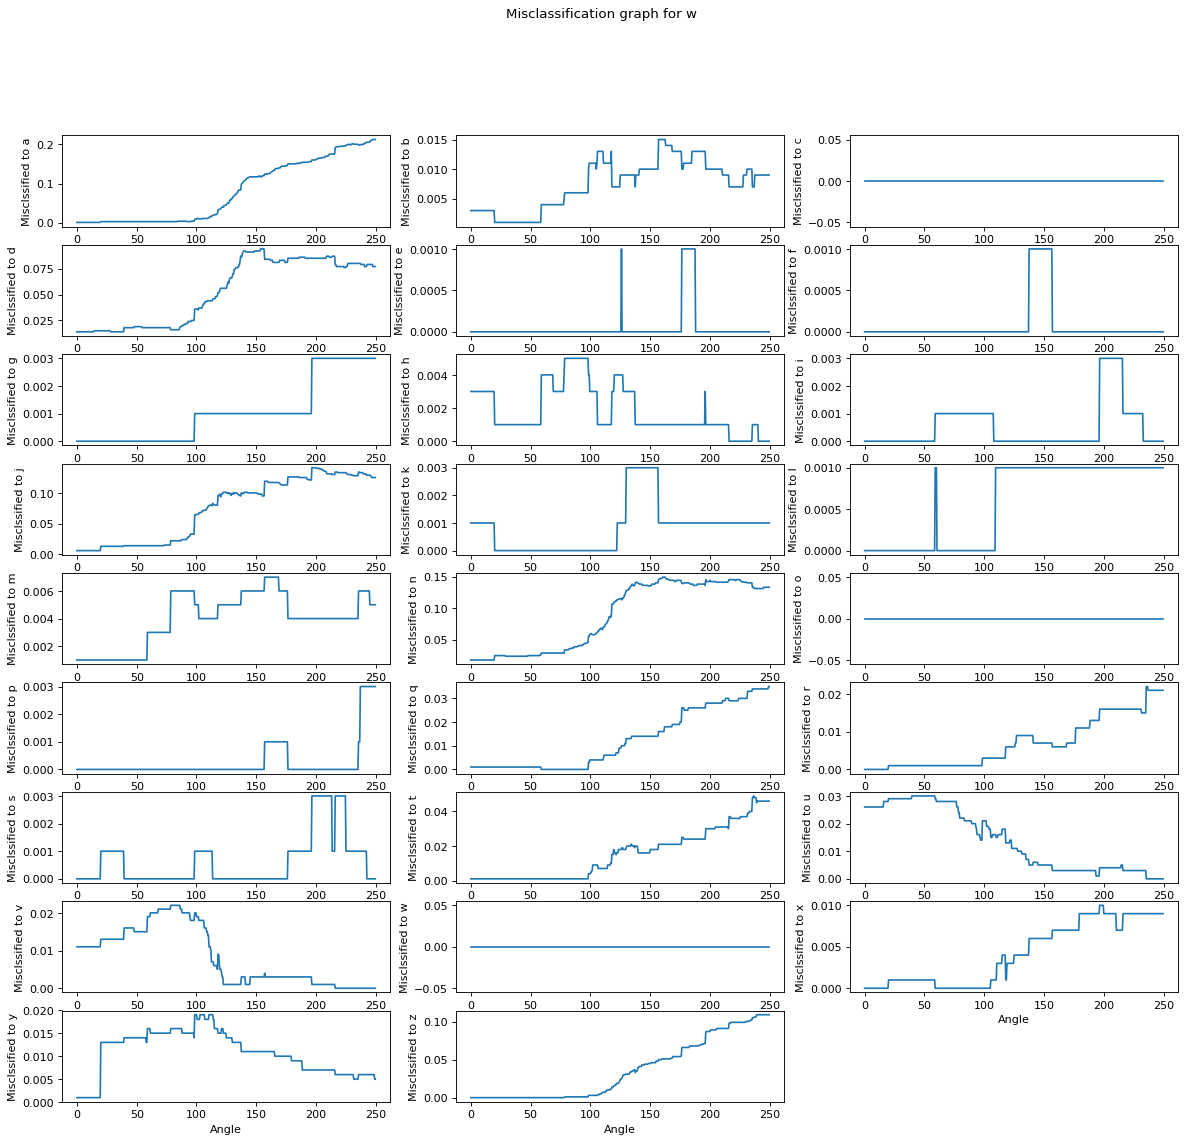

---------------------------------------------------------------------------------------------------------------------


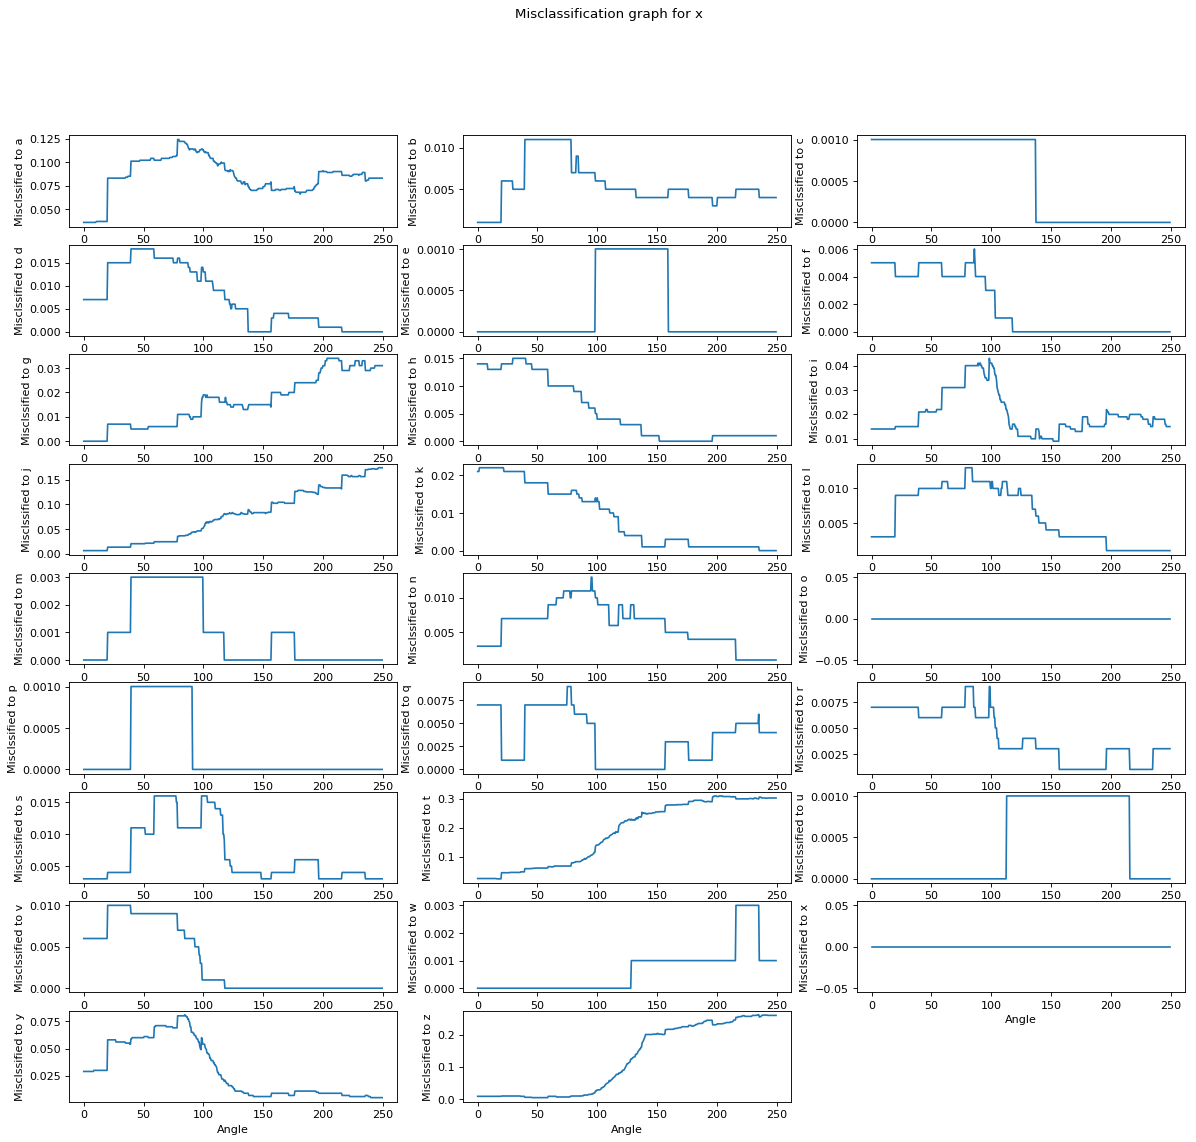

---------------------------------------------------------------------------------------------------------------------


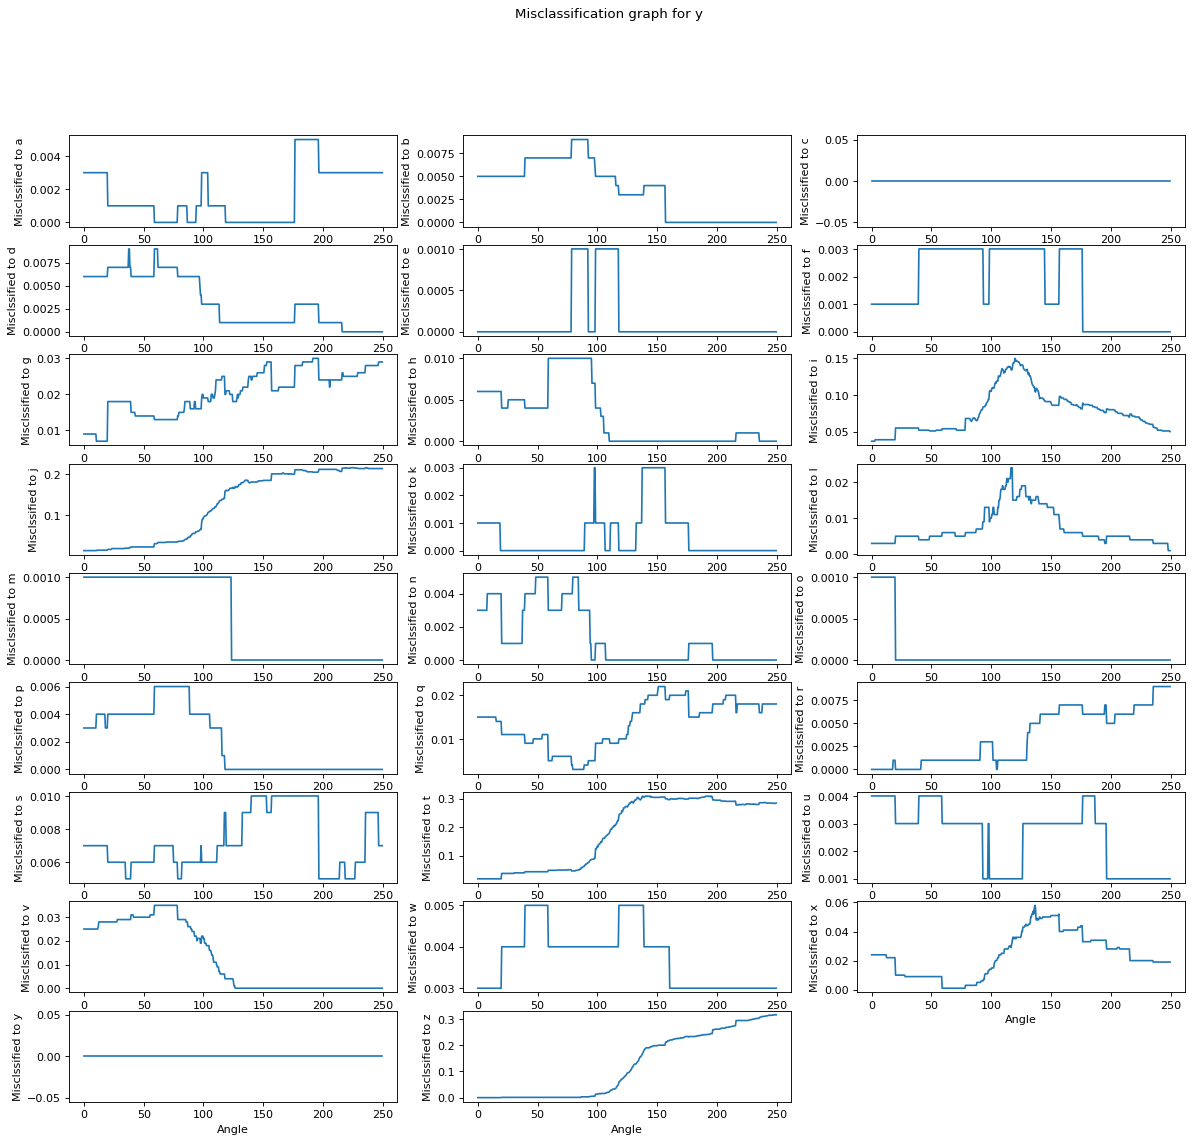

---------------------------------------------------------------------------------------------------------------------


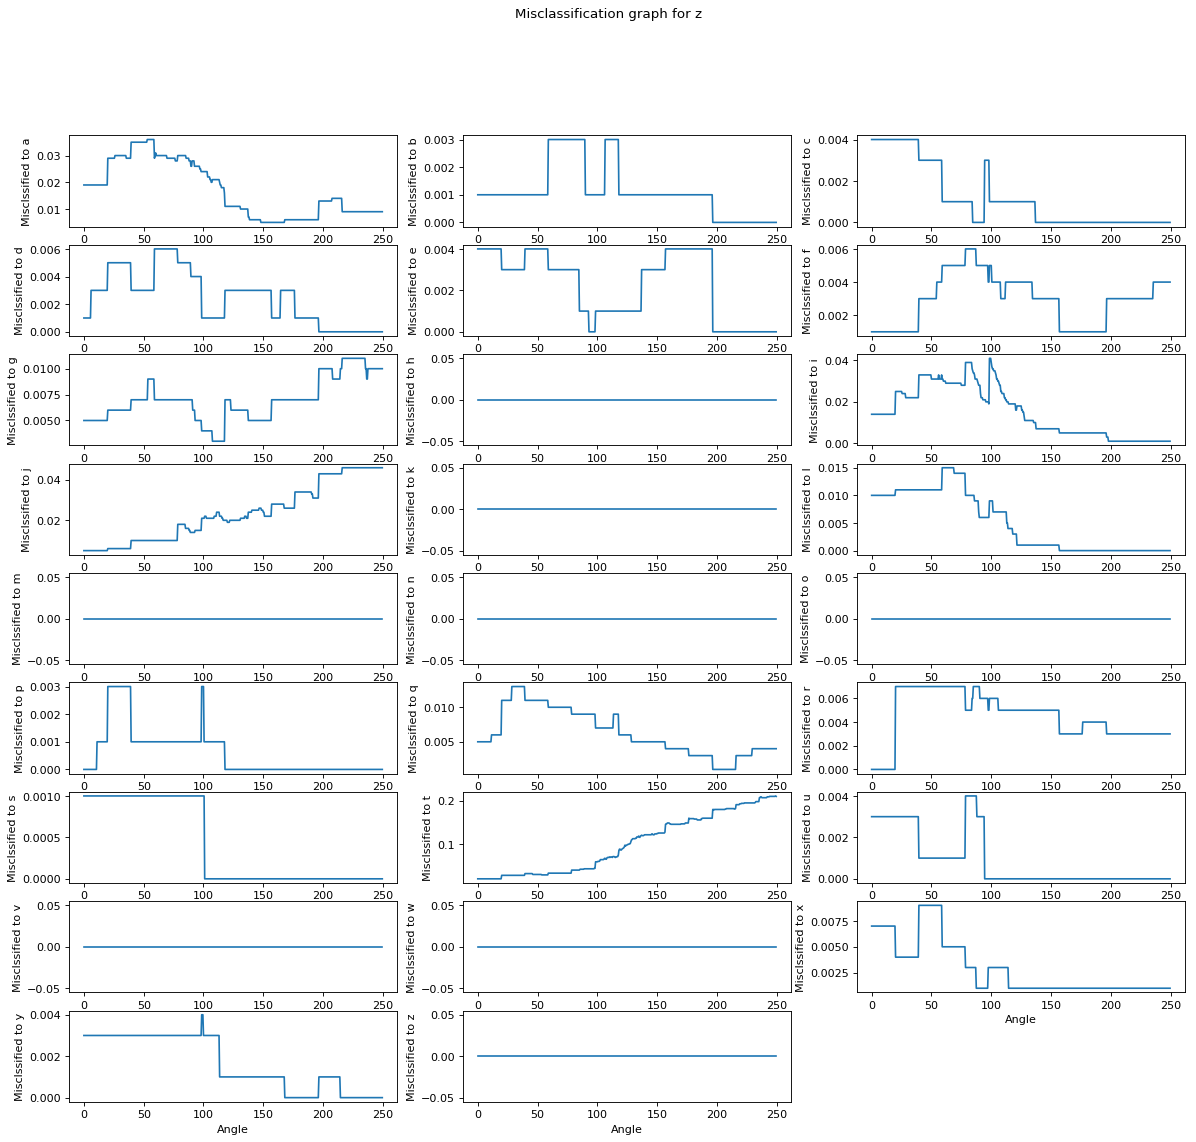

---------------------------------------------------------------------------------------------------------------------


In [23]:
zero = []

for j in range(num_classes):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,num_classes):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k])
        else:
            zero+=eps*[0]       
        plt.subplot(9,3,k+1)
        plt.plot(np.arange(0,250,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %chr(97+k))
    plt.suptitle("Misclassification graph for %s" %(chr(97+j)))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")